# ***Imports***

> ## **Pip install**

In [ ]:
!pip install pymorphy2

In [ ]:
!pip install ufal.udpipe

In [ ]:
!pip uninstall tokenizers

In [ ]:
!pip install tokenizers==0.9.4 simpletransformers --no-cache-dir

> ## **Imports**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import os
os.chdir("/content/drive/MyDrive/Fake news classification")

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from collections import Counter, defaultdict
import gc
from itertools import combinations
from multiprocessing import Pool
import pickle
import re
from string import punctuation
from sys import getsizeof

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sp
import seaborn as sns
import torch
from tqdm import tqdm, trange

In [6]:
from random import seed, choice


RANDOM_STATE = 42
RANDOM_SEED = 42

seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, PredefinedSplit
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, Booster, plot_importance
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, CategoricalNB, ComplementNB
from sklearn.neural_network import MLPClassifier

In [ ]:
from mlxtend.classifier import StackingClassifier, EnsembleVoteClassifier

In [ ]:
import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize, sent_tokenize
from pymorphy2 import MorphAnalyzer
import ufal.udpipe

morph = MorphAnalyzer()

In [ ]:
from simpletransformers.classification import ClassificationModel

# ***Data preparation***

> ## **Data merging**



In [ ]:
df_iz = pd.read_csv('Data/iz_data.csv')
df_meduza = pd.read_csv('Data/meduza_data.csv')
df_newsru = pd.read_csv('Data/newsru_data.csv')
df_pikabu = pd.read_csv('Data/pikabu_data.csv')
df_ria = pd.read_csv('Data/ria_data.csv')
df_vz = pd.read_csv('Data/vz_data.csv')
df_wikinews = pd.read_csv('Data/wikinews_data.csv')
df_lenta = pd.read_csv('Data/lenta_data.csv')
df_interfax = pd.read_csv('Data/interfax_data.csv')
df_panorama = pd.read_csv('Data/panorama_data.csv')

In [ ]:
df_iz['class'] = 'commentary'
df_meduza['class'] = 'persuasive_information'
df_newsru['class'] = 'commentary'
df_pikabu['class'] = 'persuasive_information'
df_ria['class'] = 'commentary'
df_vz['class'] = 'commentary'
df_wikinews['class'] = 'citizen_journalism'
df_lenta['class'] = 'real_news'
df_interfax['class'] = 'real_news'
df_panorama['class'] = 'satire'

In [ ]:
df = pd.concat([
    df_iz, df_meduza, df_newsru, df_pikabu, df_ria,
    df_vz, df_wikinews, df_lenta, df_interfax, df_panorama,
])

df.to_csv('all_news.csv', index=False)
df = pd.read_csv('all_news.csv')

df = df[~df['content'].isna()]
df.index = range(len(df))

In [ ]:
df.to_csv('all_news.csv', index=False)

> ## **All news: url, title, source**

In [ ]:
df = pd.read_csv('all_news.csv')

In [ ]:
df.head()

title  ...       class
0      Полет нормальный  ...  commentary
1   Приоритет министров  ...  commentary
2    Платежные каникулы  ...  commentary
3    Подсели на кредиты  ...  commentary
4  Преодолеть ненависть  ...  commentary

[5 rows x 4 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57275 entries, 0 to 57275
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    57275 non-null  object
 1   content  57275 non-null  object
 2   url      57275 non-null  object
 3   class    57275 non-null  object
dtypes: object(4)
memory usage: 2.2+ MB


In [ ]:
df[df['url'].isna()]

Empty DataFrame
Columns: [title, content, url, class]
Index: []

In [ ]:
df[df['title'].isna()]

Empty DataFrame
Columns: [title, content, url, class]
Index: []

In [ ]:
df[df['content'].isna()]

Empty DataFrame
Columns: [title, content, url, class]
Index: []

In [ ]:
strange_urls = []

def get_source(url):
    if url.startswith('http://www.interfax.ru'):
        return 'interfax.ru'
    if url.startswith('https://iz.ru'):
        return 'iz.ru'
    if url.startswith('http://www.lenta.ru'):
        return 'lenta.ru'
    if url.startswith('https://meduza.io'):
        return 'meduza.io'
    if url.startswith('https://www.newsru.com'):
        return 'newsru.com'
    if url.startswith('https://panorama.pub'):
        return 'panorama.pub'
    if url.startswith('https://pikabu.ru'):
        return 'pikabu.ru'
    if re.match(r'^https://.*ria\.ru.*$', url):
        return 'ria.ru'
    if url.startswith('https://vz.ru'):
        return 'vz.ru'
    if url.startswith('https://ru.wikinews.org'):
        return 'wikinews.org'
    strange_urls.append(url)
    return '-'

In [ ]:
# extracting news sources from urls

df['source'] = df['url'].map(get_source)

In [ ]:
len(strange_urls)

0

In [ ]:
strange_urls

[]

In [ ]:
df['source'].value_counts()

interfax.ru     20874
lenta.ru        18555
wikinews.org     5696
panorama.pub     5595
newsru.com       1558
pikabu.ru        1530
iz.ru            1085
ria.ru            868
vz.ru             866
meduza.io         648
Name: source, dtype: int64

> ## **Data cleaning: source-wise**

In [ ]:
# clean newsru.com

def clean_text(text):
    if text.startswith('"'):
        text = text[1:]
    if text.endswith('"'):
        text = text[:-1]
    elif text.endswith('".'):
        text = text[:-2] + '.'
    return text

data = df[df['source'] == 'newsru.com']['content']
df.loc[df['source'] == 'newsru.com', 'content'] = data.map(clean_text)

In [ ]:
# clean interfax.ru

def clean_text(text):
    string = 'INTERFAX.RU - '
    L = len(string)
    idx = text.find(string)
    if idx != -1:
        text = text[idx + L:]
    return text

data = df[df['source'] == 'interfax.ru']['content']
df.loc[df['source'] == 'interfax.ru', 'content'] = data.map(clean_text)

In [ ]:
# clean ria.ru

def clean_text(text):
    patterns = [
        r'^ *\w+, \d+ \w+ — РИА Новости, \w+ \w+\. ',
        r'^ *\w+, \d+ \w+ — РИА Новости\. ',
        r'Мнение автора может не совпадать с позицией редакции\.?$',
    ]
    for pattern in patterns:
        text = re.sub(pattern, '', text, count=0, flags=re.I)
    return text

data = df[df['source'] == 'ria.ru']['content']
df.loc[df['source'] == 'ria.ru', 'content'] = data.map(clean_text)

In [ ]:
# clean meduza.io

def clean_text(text):
    patterns = [
        r'Фото в анонсе.*\nНапишите нам$',
        r'Фото:.*\nНапишите нам$',
        r'Иллюстраци(и|я):.*\nНапишите нам$',
    ]
    for pattern in patterns:
        text = re.sub(pattern, '', text, count=0, flags=re.I)
    return text

data = df[df['source'] == 'meduza.io']['content']
df.loc[df['source'] == 'meduza.io', 'content'] = data.map(clean_text)

In [ ]:
# clean lenta.ru

def clean_text(text):
    abc = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
    ABC = 'АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ'
    re_date = rf'\d\d:\d\d — +\d+ [{abc}]+( \d\d\d\d)?'

    pattern = rf'Материалы по теме({re_date}«?[{ABC}].*?[^{ABC} ]«?[{ABC}].*?)+[^{ABC} ]«?[{ABC}]'
    m = re.search(pattern, text)
    if m is not None:
        text = text[:m.start()] + '\n' + text[m.end() - 1:]
    bad_re = rf'[^-{ABC} \n«"\'\(][{ABC}]'
    m = re.search(bad_re, text)
    if m is not None:
        text = text[:m.start() + 1] + '\n' + text[m.end() - 1:]
        m = re.search(bad_re, text)
    return text

data = df[df['source'] == 'lenta.ru']['content']
df.loc[df['source'] == 'lenta.ru', 'content'] = data.map(clean_text)

In [ ]:
for i, line in enumerate(df[df['source'] == 'lenta.ru']['content'][:10]):
    print(f'{i}: {line}')

In [ ]:
abc = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
ABC = 'АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ'
re_date = rf'\d\d:\d\d — +\d+ [{abc}]+( \d\d\d\d)?'

print(df[df['source'] == 'lenta.ru']['content'].map(lambda text: re.search(rf'Материалы по теме({re_date}«?[{ABC}].*?[^{ABC} ]«?[{ABC}].*?)+[^{ABC} ]«?[{ABC}]', text) is not None).sum())
print(df[df['source'] == 'lenta.ru']['content'].map(lambda text: re.search(rf'Материалы по теме{re_date}«?[{ABC}]', text) is not None).sum())
print(df[df['source'] == 'lenta.ru']['content'].map(lambda text: re.search(rf'Материалы по теме', text) is not None).sum())

32
52
70


In [ ]:
D = dict()
for line in df[df['source'] == 'lenta.ru']['content']:
    m = re.search(rf'Материалы по теме{re_date}', line)
    if m is not None:
        idx = m.end()
        ch = line[idx:idx + 2]
        D[ch] = D.get(ch, 0) + 1

print(len(D.keys()))
print('Keys:', D.keys())
print('Items:', D.items())
print(sum(D.values()))

> ## **Tokenization**

In [ ]:
def symbols_tokenize(text):
    text = text.replace('ё', 'е').replace('Ё', 'Е').replace('…', '...')
    for c in '“‘':
        text = text.replace(c, '«')
    for c in '”′ʼ’ʺ':
        text = text.replace(c, '»')
    for c in '—-–‑―−‒ー─‐':
        text = text.replace(c, '-')

    m = re.search(r'\w( +-|- +)\w', text)
    while m is not None:
        i, j = m.start(), m.end()
        text = text[:i] + text[i:j].replace(' ', '') + text[j:]
        m = re.search(r'\w( +-|- +)\w', text)

    m = re.search(rf'"[^ ]+"', text)
    while m is not None:
        i, j = m.start(), m.end()
        text = text[:i] + '«' + text[i + 1:j - 1] + '»' + text[j:]
        m = re.search(rf'"[^ ]+"', text)

    m = re.search(rf"'[^ ]+'", text)
    while m is not None:
        i, j = m.start(), m.end()
        text = text[:i] + '«' + text[i + 1:j - 1] + '»' + text[j:]
        m = re.search(rf"'[^ ]+'", text)

    m = re.search(rf'[{abc}\.\?!»][{ABC}]', text)
    while m is not None:
        idx = m.start() + 1
        text = text[:idx] + '\n' + text[idx + 1:]
        m = re.search(rf'[{abc}\.\?!][{ABC}]', text)

    return text

In [ ]:
def handle_datetime(text):
    re_min_or_sec = r'([0-5]\d|0[6-9])'
    re_hour = r'(0|1)\d?|2[0-3]'
    re_time = rf'({re_hour})(:{re_min_or_sec}){{1,2}}'
    re_0_day = r'([0-2]\d|3[01])'
    re_0_month = r'(0\d|1[12])'
    re_day = r'([0-2]?\d|3[01])'
    re_month = r'(0?\d|1[12])'
    re_eng_month = r'(jan(uary)?|feb(ruary)?|mar(ch)?|apr(il)?|may|jun(e)?|jul(y)?|aug(ust)?|sep(tember)?|oct(ober)?|nov(ember)?|dec(ember)?)'
    re_rus_month = r'(январ(ь|я)|феврал(ь|я)|март(а)|апрел(ь|я)|ма(й|я)|июн(ь|я)|июл(ь|я)|август(а)|сентяьр(ь|я)|октябр(ь|я)|ноябр(ь|я)|декабр(ь|я))'

    date_patterns = {
        'yyyy(-|по)yyyy': r'\d{4}( *(по|-|до) *)\d{4}',

        '[d]d[-го] ru_mm[ yyyy[ года]][ в hh:mm[:ss]]': rf'{re_day}(-?о?(е|го))? +{re_rus_month}( +\d{4}( +(года|г\.?))?)?( +(с|к|в|на|,)? +{re_time})?',
        '[d]d[-th] en_mm[ yyyy][ at hh::mm[::ss]]': rf'{re_day}(-?th)? +(of +)?{re_eng_month}( +\d{4})?( +at +{re_time})?',

        'yyyy-mm[-dd]': rf'\d{{4}}-{re_0_month}(-{re_0_day})?',
        'dd-mm-yyyy': rf'{re_0_day}-{re_0_month}-\d{{4}}',

        '[h]h:mm[:ss]': re_time,

        '[m]m/[d]d/[yy]yy': rf'{re_month}/{re_day}/(\d\d){{1,2}}',
        'dd.mm.[yy]yy': rf'{re_0_day}\.{re_0_month}\.(\d\d){{1,2}}',
    }

    for pattern in date_patterns.values():
        text = re.sub(pattern, ' <DATETIME> ', text)
    return text

In [ ]:
def special_tokenize(text):
    re_digit_symbols = r'⅔⅓¾½¼³²₂₅₁₀\%/\$№€#₽£\*\+×∼℃º°→\^∞÷'
    re_integer = r'\d[ \'\d]*'
    re_float = rf'{re_integer}[,\./]{re_integer}'

    patterns = {  # fixed order!
        '<EMOJI>': r'[￼🎊🥶❄️🔦🏢🛋👁♻🌿👫🐉😎⚔💊💋🎤👨🏻👩🏼🎨⏳🎙💳✈🛂🚑🚃📱🏨🍔🎭🛍🚗🛳🚄😊🚀ツ❤💪📸✊⚽😅✪⭐🦇🔴🖤🍊🌊😂🔥❗‍♂🇷🇺🥊🇸📝🦁👉⚡🤯💻✨🌃⚪💍🐐🆚🇹😨☺⚫🎉✌👏🔵😀💖🇧👻☝👍🤔🗣👋💛❌📋📲🍾🎄🎁🧑🦲😭✔😃😉⁦⁩📹🎾😡💉🗓💚🚨🖥🤤🇯🇵🏠⏱Ә💥ù🙌🎥🤘💯🤲🙅🤣📷👑🖋⁣🤗✅🤠♦💗🤸🙃🤍🧝🏽🥳🐾🙏😬👎̈💣🔫😍💧🌸💐♬🤴👸👶👊💙🦋🤎💃☀🐘⚜]',
        '<URL>': r'(https? ?: ?//)?[a-zA-Z0-9\./\?:@_=#-]+\.[a-zA-Z]{2,6}[a-zA-Z0-9\.&%/\?:@_=#-]*',
        '<NUM>': rf'[{re_digit_symbols} ]*({re_float}|{re_integer})[{re_digit_symbols} ]*',
        '<UTF>': r'[óíêý­ ́̆öקלפיèáūōü§ÓĘ·™@Å„®à저는오래전부터서울을구경하고싶었습니다안녕세요어디에버스표를살수있까복궁은매우아름답도시의망보기좋곳이입감사합정말맛징가움직여드레즈소주몇건물비행접와같생겼ç얼굴바르크림추천해한국식라떼트Ēé\ƒÉņāžīļķēšú Šôä~ії‌¸⁃•►`â¯|●こんにちはў ÜÁ‎µřò➡îćã✍⃣ңүөҡӨҙәғҠһҺҫ▼▲․¡ЄėℹåІ▫ÚÇموقعالحترفين☘ìģ𝙎𝙪𝙯𝙮𝘾𝙤𝙧𝙩𝙚єΠοδσφαιρτήςηΑΕΚΝάμνΣκλώόεγέńυθίπωßčΟΜÍᴢᴀʜʙɪÀÖ©♀ñşَأُّهذِآْكإٌبسطدۖۚىؤłęχą∙ıČÆβ法维拉韦ů𝒮𝓊𝓃𝓈𝑒𝓉𝓇𝒸𝒽ğ⁰øðï𝐶𝑎𝑚𝑖𝑙ЎЈ]',
    }

    for token, pattern in patterns.items():
        text = re.sub(pattern, f' {token} ', text)
    return text

In [ ]:
def handle_punctuation(text):
    punct = '.,!?:();«»'
    strange_symbols = [c for c in text if not (c.isalnum() or c in punct or c.isspace() or c in '<>-')]
    for c in punct:
        text = text.replace(c, f' {c} ')
    for c in strange_symbols:
        text = text.replace(c, '')
    text = text.replace('. . .', '...')

    return text

In [ ]:
def remove_spaces(text):
    for s in ['\r', '\n\n']:
        text = text.replace(s, '\n')
    for c in ['	⁠', ' ', ' ', '\t', '⠀']:
        text = text.replace(c, ' ')
    text = re.sub(r'  +', ' ', text)
    return text.strip()

In [ ]:
def do_all_the_magic(text):
    return remove_spaces(handle_punctuation(special_tokenize(handle_datetime(symbols_tokenize(text)))))

In [ ]:
print(df['content'][0])

Итоги прошедших выборов в Европейский парламент (ЕП) в целом соответствуют прогнозам: катастрофы не случилось, но политический ландшафт становится более разнообразным. Евроскептики и близкие к ним правопопулистские партии незначительно увеличили свое представительство — со 150 до 180 мандатов, что составляет четверть депутатского корпуса.
Также сложно говорить о доминировании евроскептиков в отдельных странах ЕС. Да, партия Марин Ле Пен во Франции получила 24% голосов и заняла первое место, и это важный символ. Однако остальные французские партии, более или менее активно поддерживающие евроинтеграцию, вместе получили 76% голосов. Также важно понимать, что большинство континентальных евроскептиков не требуют роспуска Евросоюза или выхода своей страны из ЕС. Их цель — возврат на национальный уровень части полномочий в отдельных сферах.
Второй тренд — сокращение влияния центристских партий. Этот процесс продолжается уже около 20 лет. По итогам прошедших выборов эти партии впервые получили

In [ ]:
print(do_all_the_magic(df['content'][0]))

Итоги прошедших выборов в Европейский парламент ( ЕП ) в целом соответствуют прогнозам : катастрофы не случилось , но политический ландшафт становится более разнообразным . Евроскептики и близкие к ним правопопулистские партии незначительно увеличили свое представительство - со <NUM> до <NUM> мандатов , что составляет четверть депутатского корпуса . 
Также сложно говорить о доминировании евроскептиков в отдельных странах ЕС . Да , партия Марин Ле Пен во Франции получила <NUM> голосов и заняла первое место , и это важный символ . Однако остальные французские партии , более или менее активно поддерживающие евроинтеграцию , вместе получили <NUM> голосов . Также важно понимать , что большинство континентальных евроскептиков не требуют роспуска Евросоюза или выхода своей страны из ЕС . Их цель - возврат на национальный уровень части полномочий в отдельных сферах . 
Второй тренд - сокращение влияния центристских партий . Этот процесс продолжается уже около <NUM> лет . По итогам прошедших выб

In [ ]:
df.loc[:, 'content'] = df['content'].map(lambda text: do_all_the_magic(text))

> ## **Final dataset dump**

In [ ]:
df.head()

title  ... source
0      Полет нормальный  ...  iz.ru
1   Приоритет министров  ...  iz.ru
2    Платежные каникулы  ...  iz.ru
3    Подсели на кредиты  ...  iz.ru
4  Преодолеть ненависть  ...  iz.ru

[5 rows x 5 columns]

In [ ]:
df = df[~df['content'].isna()]
len(df)

57190

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57190 entries, 0 to 57274
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    57190 non-null  object
 1   content  57190 non-null  object
 2   url      57190 non-null  object
 3   class    57190 non-null  object
 4   source   57190 non-null  object
dtypes: object(5)
memory usage: 2.6+ MB


In [ ]:
df.to_csv('special_tokenized_news.csv', index=False)

In [17]:
df = pd.read_csv('special_tokenized_news.csv')

In [ ]:
df['class'].value_counts()

real_news                 39429
citizen_journalism         5611
satire                     5595
commentary                 4377
persuasive_information     2178
Name: class, dtype: int64

In [ ]:
df['source'].value_counts()

interfax.ru     20874
lenta.ru        18555
wikinews.org     5611
panorama.pub     5595
newsru.com       1558
pikabu.ru        1530
iz.ru            1085
ria.ru            868
vz.ru             866
meduza.io         648
Name: source, dtype: int64

In [ ]:
list(df['class'].value_counts())

[39429, 5611, 5595, 4377, 2178]

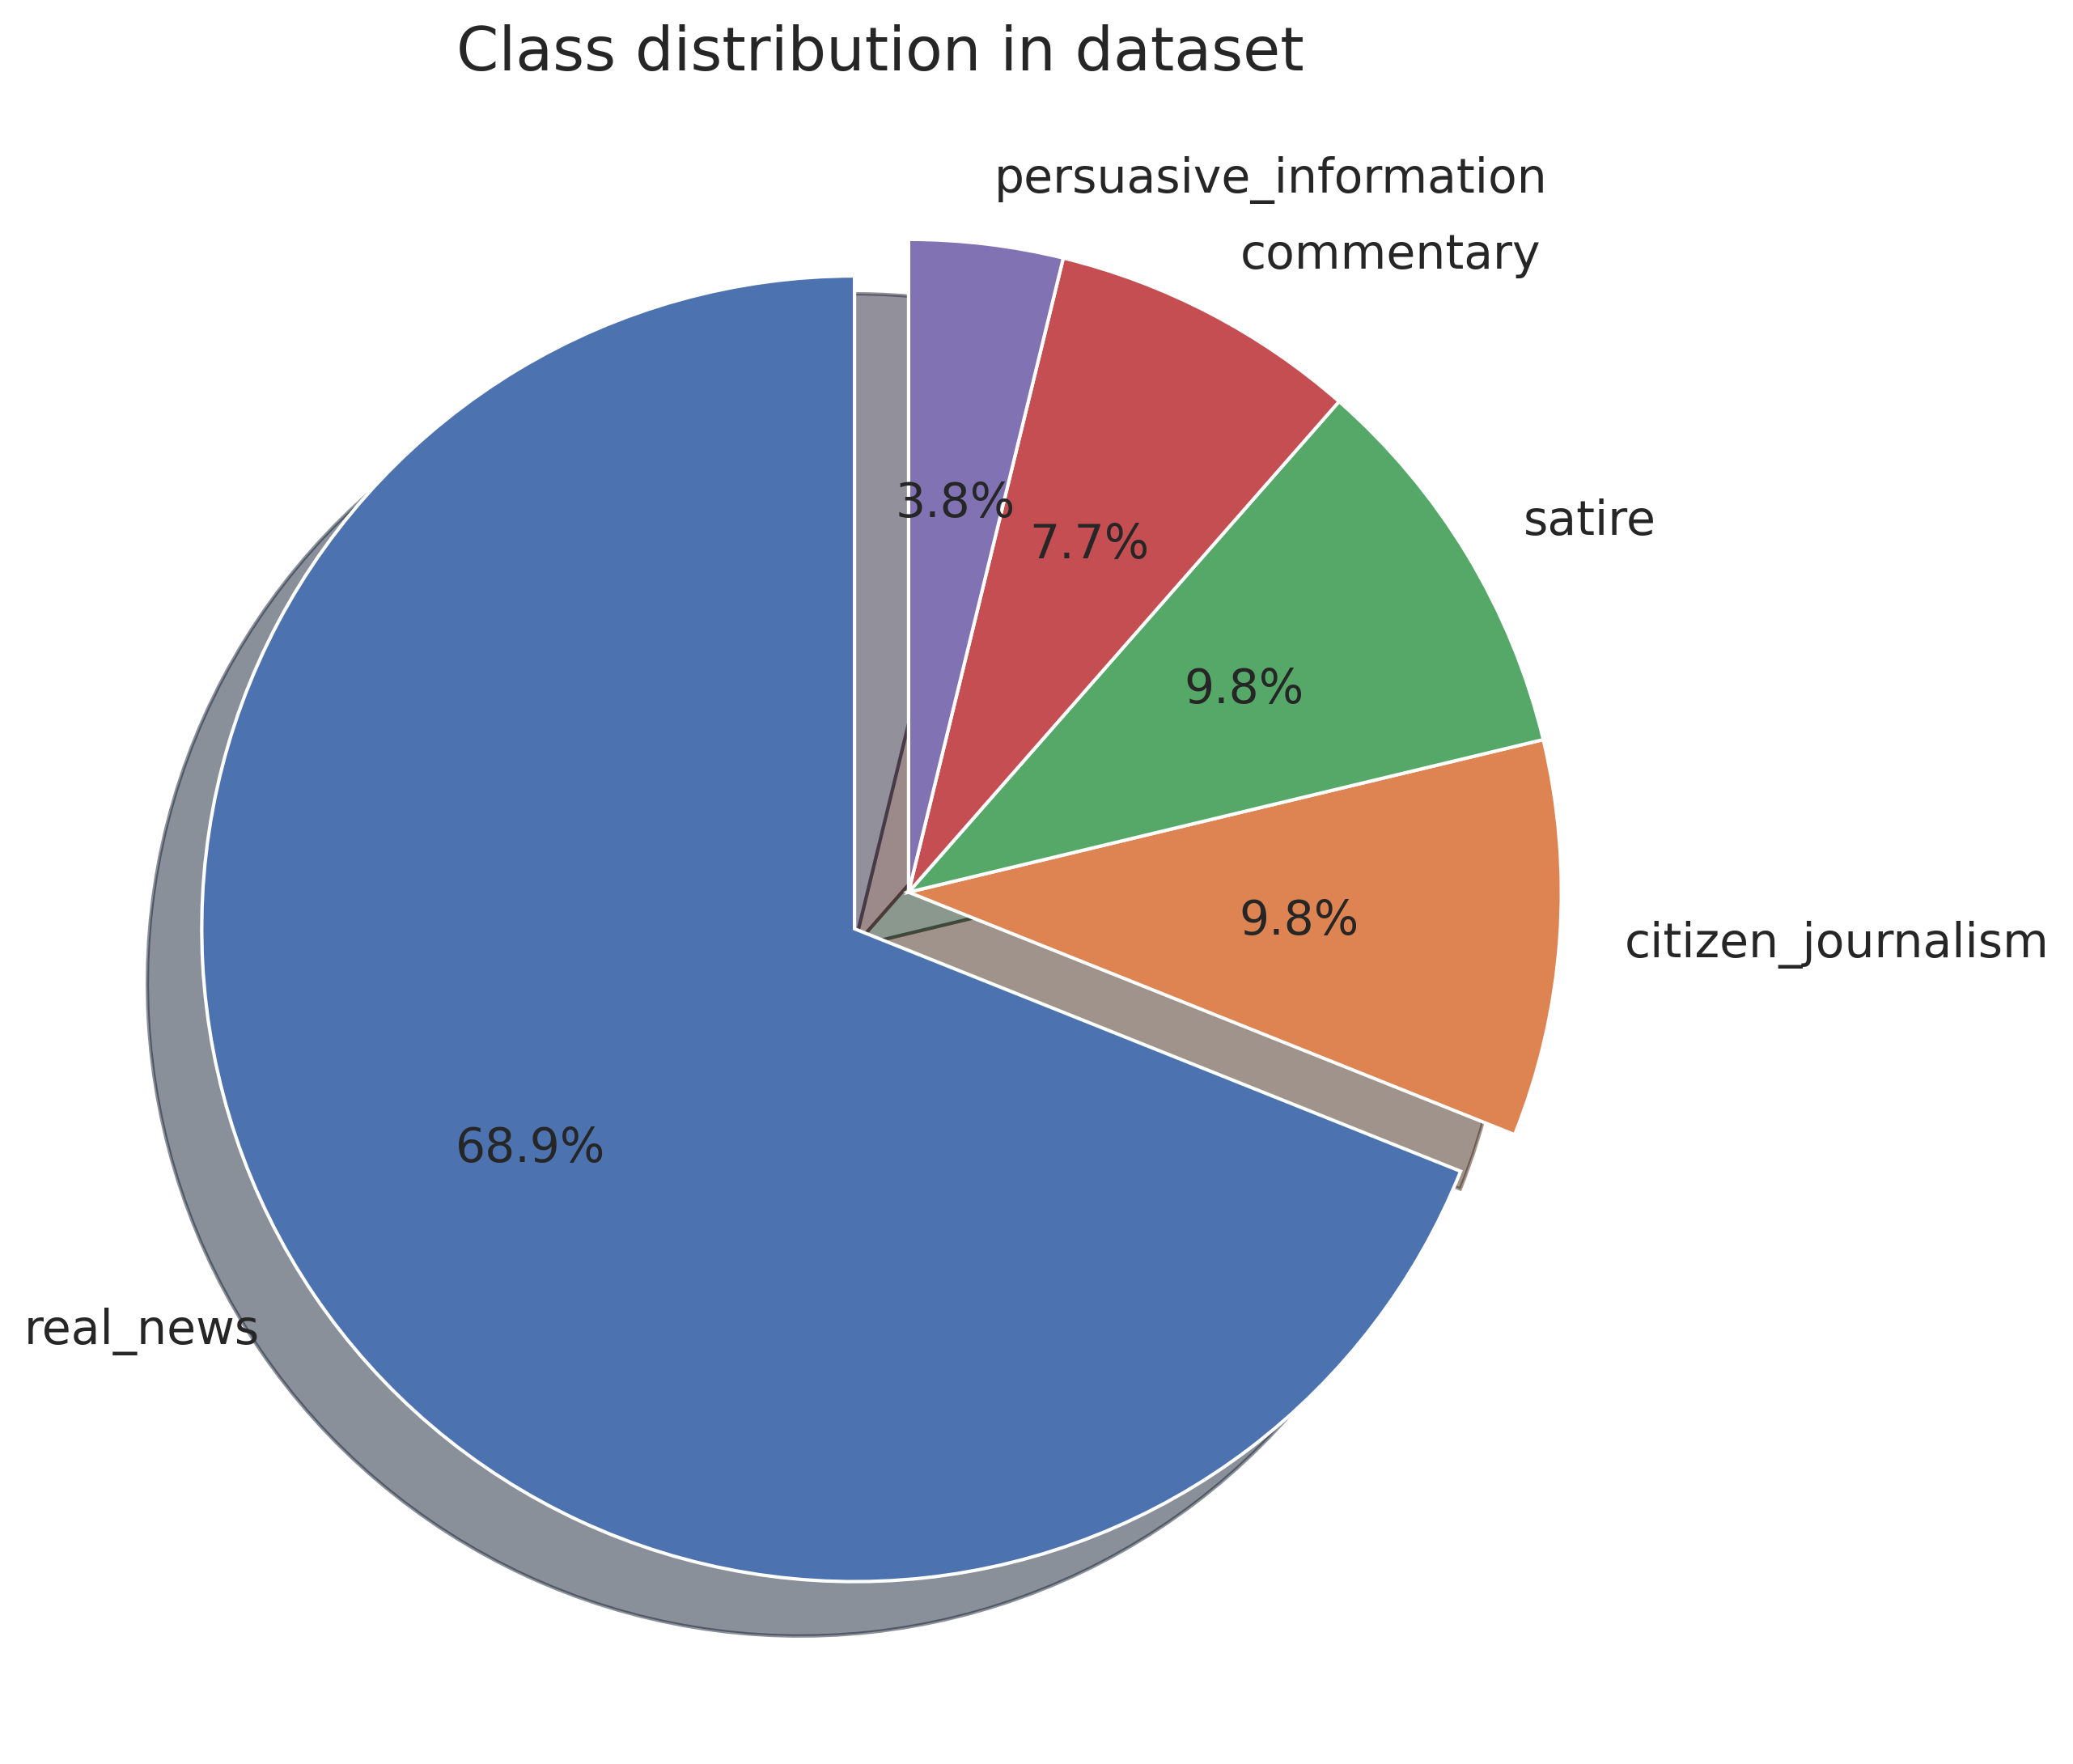

In [32]:
labels = list(df['class'].value_counts().index)
sizes = list(df['class'].value_counts())
explode = [0.1, 0, 0, 0, 0]

fig, ax = plt.subplots(figsize=(8, 9), dpi=300)
ax.pie(sizes,
       explode=explode,
       labels=labels,
       autopct='%1.1f%%',
       shadow=True,
       startangle=90,
       textprops={
           'fontsize': 14,
        })
ax.axis('equal')
ax.set_title('Class distribution in dataset',
             fontdict={
                 'fontsize': 18,
            })
plt.savefig('Images/class_distr.png', bbox_inches='tight')
plt.show()

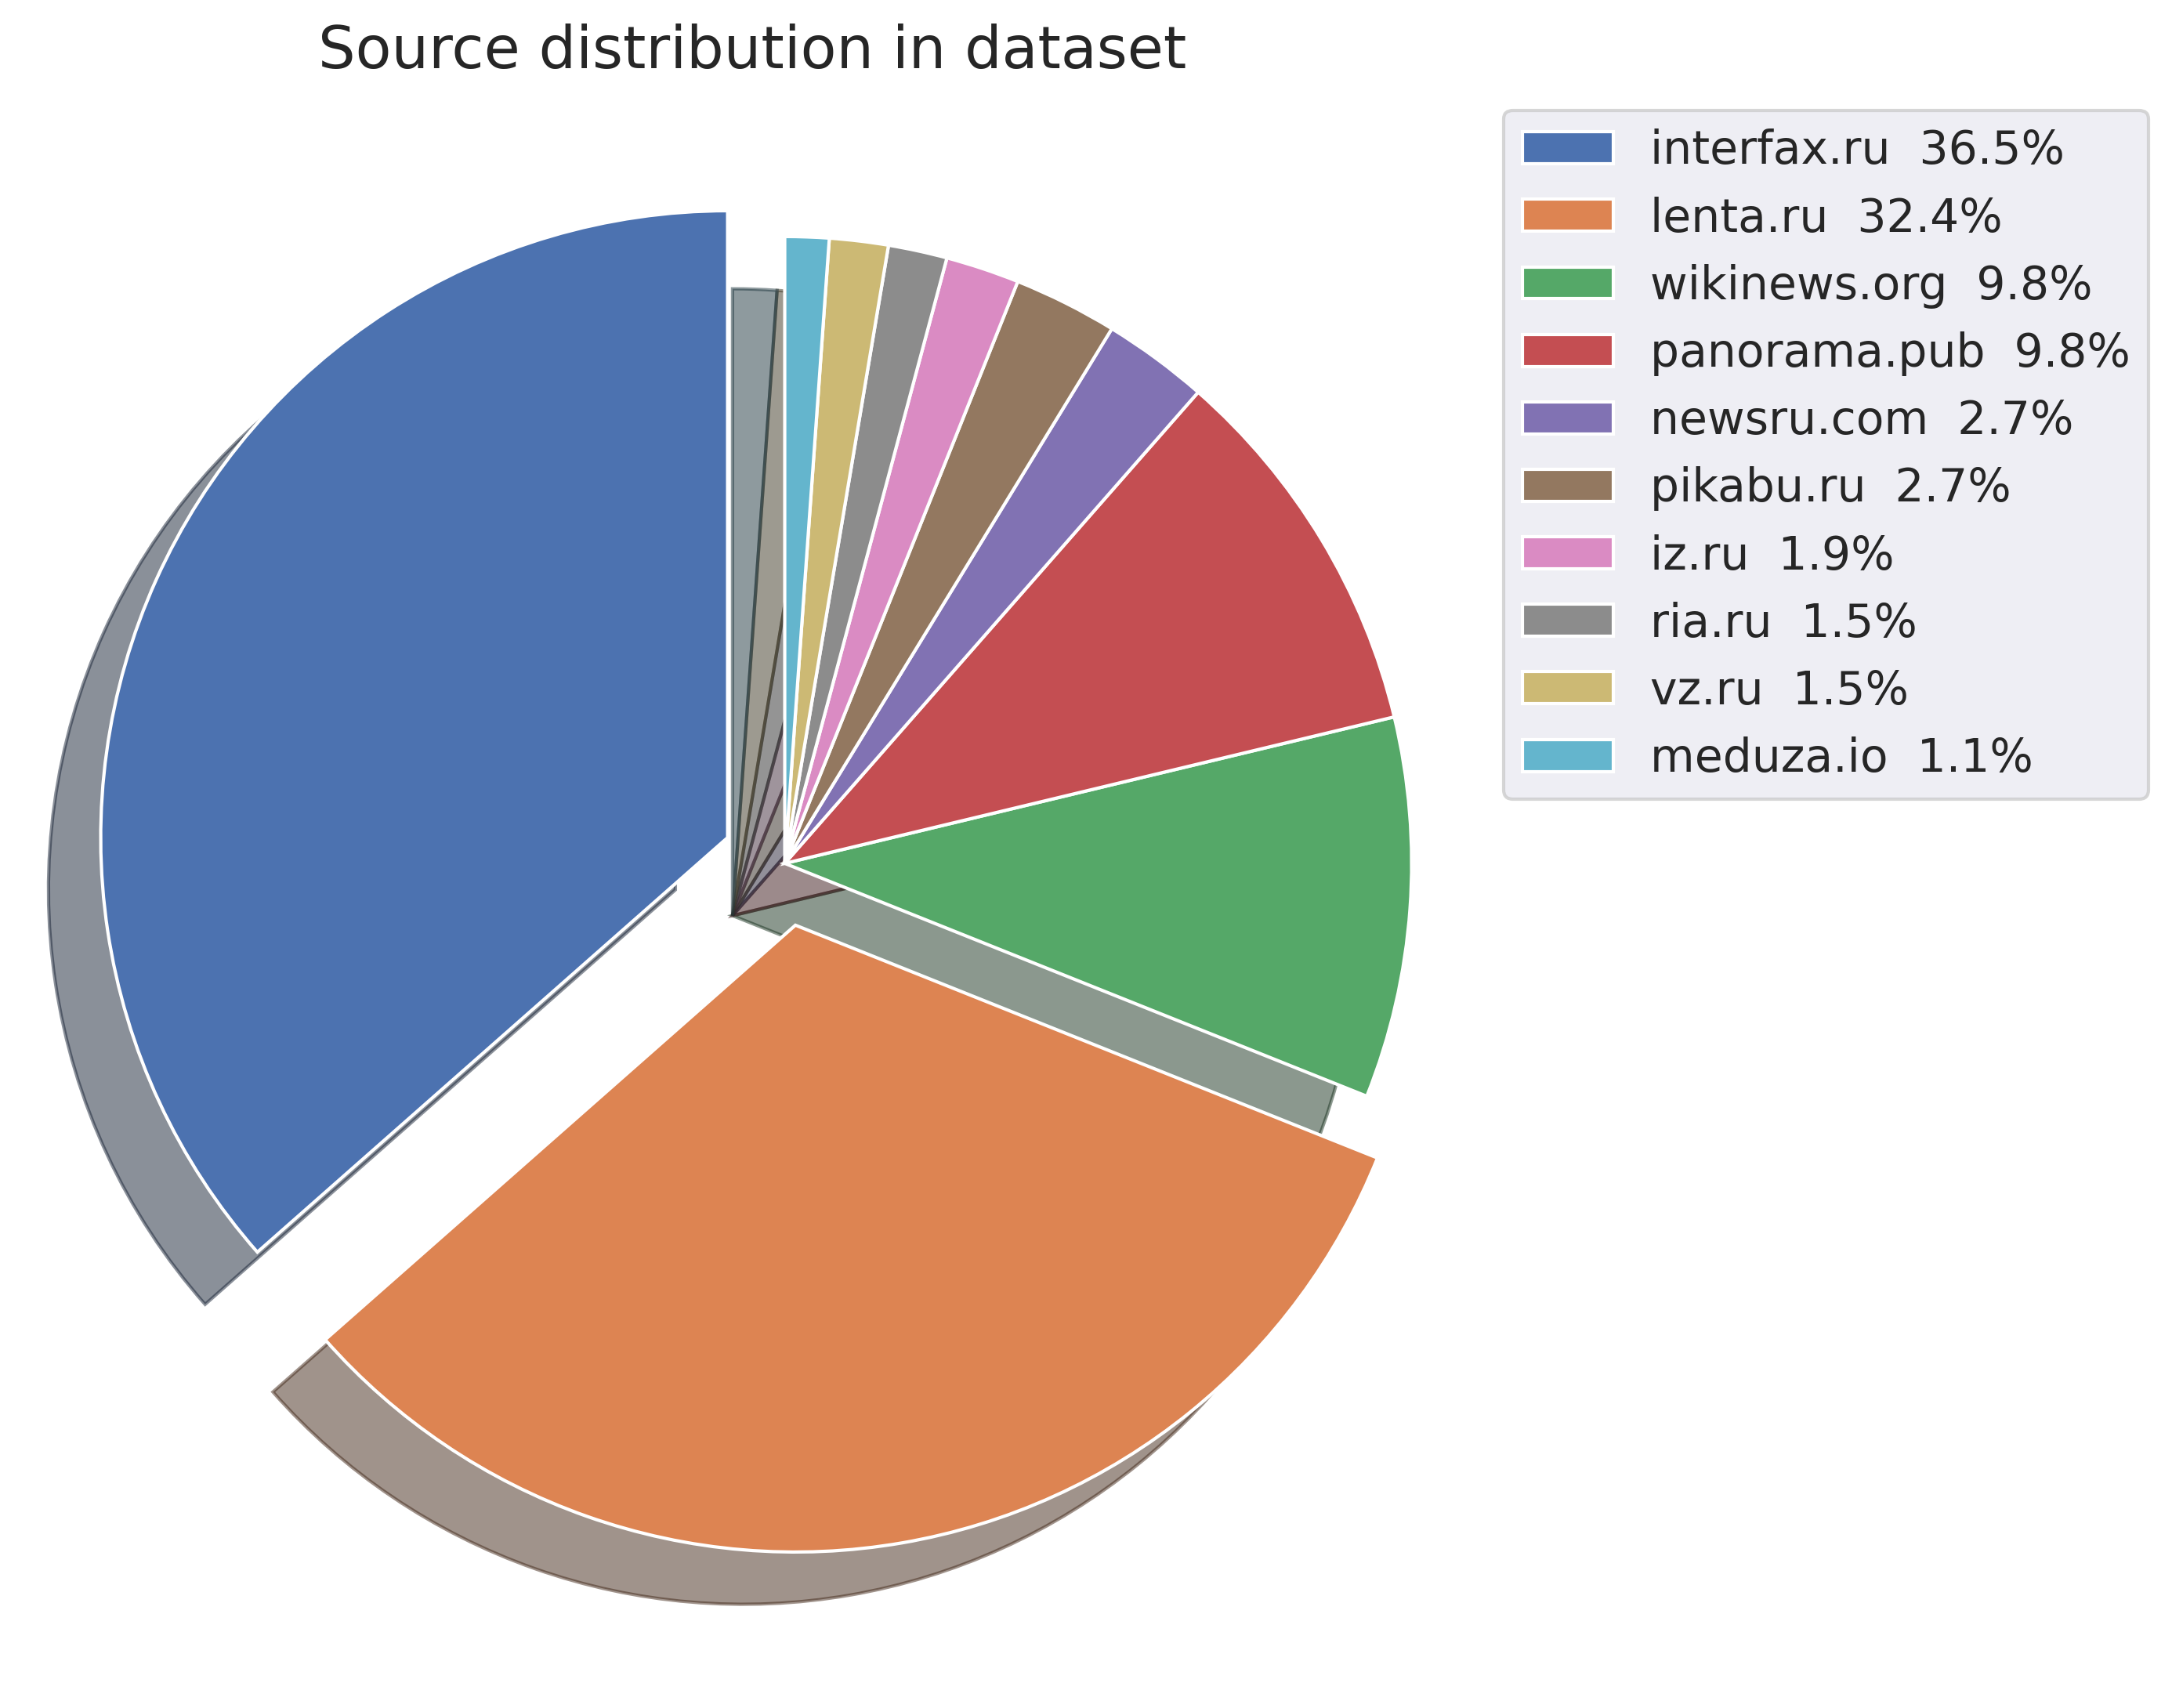

In [33]:
labels = list(df['source'].value_counts().index)
sizes = list(df['source'].value_counts())
explode = [0.1, 0.1, 0, 0, 0, 0, 0, 0, 0, 0]

fig, ax = plt.subplots(figsize=(8, 9), dpi=300)
ax.pie(sizes,
       explode=explode,
       shadow=True,
       startangle=90)
ax.axis('equal')
ax.set_title('Source distribution in dataset',
             fontdict={
                 'fontsize': 18,
             })

percents = [sz / sum(sizes) * 100 for sz in sizes]
plt.legend(
    labels=[f'{label}  {sz:1.1f}%' for label, sz in zip(labels, percents)],
    bbox_to_anchor=(1,1),
    prop={
        'size': 14,
    })
plt.savefig('Images/source_distr.png', bbox_inches='tight')
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57190 entries, 0 to 57189
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    57190 non-null  object
 1   content  57190 non-null  object
 2   url      57190 non-null  object
 3   class    57190 non-null  object
 4   source   57190 non-null  object
dtypes: object(5)
memory usage: 2.2+ MB


In [ ]:
df.tail()

title  ...        source
57185  Российские эксперты усомнились в подлинности к...  ...  panorama.pub
57186  Американская АЭС временно прекратит работу из-...  ...  panorama.pub
57187  В Государственную думу внесён законопроект об ...  ...  panorama.pub
57188  В Голливуде не могут начать съёмки историческо...  ...  panorama.pub
57189  Минздрав ФРГ: газообразная версия вакцины от P...  ...  panorama.pub

[5 rows x 5 columns]

# ***Feature extraction***

> ## **Feature extraction: morphology (pymorphy2)**

In [ ]:
MORPH_MIN_PROB = 0.1

def get_pos_features(text):
    res = Counter()
    for word in text.split():
        ps = morph.parse(word)
        tags = set(p.tag.POS for p in ps)
        probs = {tag: sum(p.score for p in ps if p.tag.POS == tag) for tag in tags}
        for tag, prob in probs.items():
            if tag is not None and prob >= MORPH_MIN_PROB:
                res[str(tag)] += 1
    return res

In [ ]:
for i in trange(100):
    _ = get_pos_features(df['content'][i])

In [ ]:
NUM_WORKERS = 32  # get_pos_features should be paralleled! (16-32 workers)


POS_TAGS = [
    'NOUN', 'ADJF', 'ADJS', 'COMP', 'VERB', 'INFN', 'PRTF', 'PRTS', 'GRND',
    'NUMR', 'ADVB', 'NPRO', 'PRED', 'PREP', 'CONJ', 'PRCL', 'INTJ',
    'LATN', 'PNCT', 'NUMB', 'intg', 'real', 'ROMN', 'UNKN',
]
df_pos = pd.DataFrame(np.zeros((len(df), len(POS_TAGS))), columns=POS_TAGS, dtype=int)

In [ ]:
df_pos.head()

NOUN  ADJF  ADJS  COMP  VERB  INFN  ...  PNCT  NUMB  intg  real  ROMN  UNKN
0     0     0     0     0     0     0  ...     0     0     0     0     0     0
1     0     0     0     0     0     0  ...     0     0     0     0     0     0
2     0     0     0     0     0     0  ...     0     0     0     0     0     0
3     0     0     0     0     0     0  ...     0     0     0     0     0     0
4     0     0     0     0     0     0  ...     0     0     0     0     0     0

[5 rows x 24 columns]

In [ ]:
with Pool(NUM_WORKERS) as pool:
    workers = [
        pool.apply_async(get_pos_features, args=(text,))
        for text in df['content']
    ]
    for i, w in enumerate(tqdm(workers)):
        cnt = w.get()
        for tag, val in cnt.items():
            df_pos.loc[i][tag] = val

In [ ]:
df_pos.loc[-5:]

NOUN  ADJF  ADJS  COMP  VERB  INFN  ...  PNCT  NUMB  intg  real  ROMN  UNKN
0       296   143  11.0   6.0    52  18.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
1       198    86  12.0   3.0    43  15.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
2       334   134  14.0   6.0    58  23.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
3       241    94  10.0   9.0    50  30.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
4       166    94  13.0   2.0    52  16.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
...     ...   ...   ...   ...   ...   ...  ...   ...   ...   ...   ...   ...   ...
57185   109    56  10.0   3.0    41  11.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
57186    83    23   4.0   0.0    15   7.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
57187   106    36   2.0   2.0    14   5.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
57188    80    28   5.0   0.0    25  10.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
57189    34    19   1.0   0.0     7   4.0  ...   0.0   0.0   0.0   0.0   0.0   0.0

[57190 rows x 24 columns]

In [ ]:
df_pos.shape

(57190, 24)

In [ ]:
df_pos.to_csv('Features/df_pos.csv', index=False)

In [ ]:
df_pos = pd.read_csv('Features/df_pos.csv')

> ## **Feature extraction: syntax (UDPipe, SynTagRus model)**

In [ ]:
syntax_model = ufal.udpipe.Model.load('Features/russian-syntagrus-ud-2.5-191206.udpipe')
syntax_pipeline = ufal.udpipe.Pipeline(syntax_model,
                                       'tokenize',
                                       ufal.udpipe.Pipeline_DEFAULT_get(),
                                       ufal.udpipe.Pipeline_DEFAULT_get(),
                                       'conllu')

In [ ]:
def get_syntax_features(text):
    res = Counter()
    processed = syntax_pipeline.process(text)
    for line in processed.split('\n'):
        line = line.strip()
        if line and not line.startswith('#'):
            deprel = line.split('\t')[7]
            res[deprel] += 1
    return res

In [ ]:
for i in trange(100):
    _ = get_syntax_features(df['content'][i])

In [ ]:
NUM_WORKERS = 32  # get_syntax_features should be paralleled! (16-32 workers)


SYNTAX_TAGS = [
    'acl', 'acl:relcl', 'advcl', 'advmod', 'amod', 'appos', 'aux', 'aux:pass',
    'case', 'cc', 'ccomp', 'compound', 'conj', 'cop', 'csubj', 'csubj:pass',
    'dep', 'det', 'discourse', 'expl', 'fixed', 'flat', 'flat:foreign', 'flat:name',
    'iobj', 'mark', 'nmod', 'nsubj', 'nsubj:pass', 'nummod', 'nummod:entity',
    'nummod:gov', 'obj', 'obl', 'orphan', 'parataxis', 'punct', 'root',
    'vocative', 'xcomp',
]

In [ ]:
df_syntax_dicts = []

In [ ]:
def continue_syntax_featuring(idx=0):
    with Pool(NUM_WORKERS) as pool:
        workers = [
            pool.apply_async(get_syntax_features, args=(text,))
            for text in df['content'][idx:]
        ]
        for i, w in enumerate(tqdm(workers)):
            df_syntax_dicts.append(w.get())

In [ ]:
pickle.dump(df_syntax_dicts, open('Features/df_syntax_dicts.sav', 'wb'))

In [ ]:
df_syntax_dicts = pickle.load(open('Features/df_syntax_dicts.sav', 'rb'))

In [ ]:
len(df_syntax_dicts)

57190

In [ ]:
continue_syntax_featuring(0)

In [ ]:
df_syntax = pd.DataFrame(df_syntax_dicts, dtype=int).fillna(0)

for col in SYNTAX_TAGS:
    if col not in df_syntax.columns:
        df_syntax[col] = 0
        print(col)

for col in df_syntax.columns:
    df_syntax[col] = df_syntax[col].astype(int)

dep
vocative


In [ ]:
df_syntax.head()

nsubj  amod  nmod  case  punct  ...  expl  flat  nummod:entity  dep  vocative
0     54   106   126    81    114  ...     0     0              0    0         0
1     35    56    72    71     91  ...     0     0              0    0         0
2     47   104   165   143    123  ...     0     0              0    0         0
3     42    72   121    78     91  ...     0     0              0    0         0
4     44    46    44    51    110  ...     0     0              0    0         0

[5 rows x 40 columns]

In [ ]:
df_syntax.to_csv('Features/df_syntax.csv', index=False)

In [ ]:
df_syntax = pd.read_csv('Features/df_syntax.csv')

> ## **Feature extraction: symbols (CountVectorizer)**

In [ ]:
def symbols_tokenize(text):
    tokens = []
    for word in text.split():
        if word in ['<URL>', '<NUM>', '<DATETIME>', '<UTF>', '<EMOJI>']:
            tokens.append(word)
        else:
            for c in word:
                tokens.append(c)
    return tokens

In [ ]:
symbols_vect = CountVectorizer(tokenizer=symbols_tokenize,
                               ngram_range=(1, 2),
                               stop_words=[])
df_symbols = symbols_vect.fit_transform(df['content'].tolist())

In [ ]:
df_symbols.shape

(57190, 4754)

In [ ]:
pickle.dump(df_symbols, open('Features/df_symbols.sav', 'wb'))
pickle.dump(symbols_vect, open('Features/symbols_vect.sav', 'wb'))

In [ ]:
df_symbols = pickle.load(open('Features/df_symbols.sav', 'rb'))
symbols_vect = pickle.load(open('Features/symbols_vect.sav', 'rb'))

> ## **Feature extraction: TF-IDF**

In [ ]:
def tfidf_tokenize(text):
    return list(map(lambda word: morph.parse(word)[0].normal_form, text.split()))

In [ ]:
tfidf_y = df['class']

tfidf_vect = TfidfVectorizer(tokenizer=tfidf_tokenize,
                             max_df=1.0,
                             min_df=10,
                             ngram_range=(1, 2),
                             max_features=100000,
                             stop_words=[])
tfidf_X = tfidf_vect.fit_transform(df['content'].tolist())

In [ ]:
tfidf_X.shape, tfidf_y.shape

((57190, 100000), (57190,))

In [ ]:
D_enum_class = {
    'real_news': 0,
    'citizen_journalism': 1,
    'satire': 2,
    'commentary': 3,
    'persuasive_information': 4,
}

In [ ]:
tfidf_y = tfidf_y.map(lambda s: D_enum_class[s])

In [ ]:
pickle.dump(tfidf_X, open('Features/tfidf_X.sav', 'wb'))
pickle.dump(tfidf_y, open('Features/tfidf_y.sav', 'wb'))
pickle.dump(tfidf_vect, open('Features/tfidf_vect.sav', 'wb'))

In [ ]:
tfidf_X = pickle.load(open('Features/tfidf_X.sav', 'rb'))
tfidf_y = pickle.load(open('Features/tfidf_y.sav', 'rb'))
tfidf_vect = pickle.load(open('Features/tfidf_vect.sav', 'rb'))

> ## **Feature extraction: lengths**

In [ ]:
df_lens = pd.DataFrame(index=range(len(df)),
                       columns=['LengthSentences', 'LengthTokens', 'LengthSymbols'],
                       dtype=int)

for i, line in enumerate(tqdm(df['content'])):
    sent_len = len(sent_tokenize(line))
    word_len = len(line.split())
    symb_len = len(symbols_tokenize(line))
    df_lens.iloc[i] = [sent_len, word_len, symb_len]

for col in ['LengthSentences', 'LengthTokens', 'LengthSymbols']:
    df_lens[col] = df_lens[col].astype(int)

100%|██████████| 57190/57190 [01:04<00:00, 886.48it/s] 


In [ ]:
df_lens.head()

LengthSentences  LengthTokens  LengthSymbols
0               46           838           5062
1               30           621           3306
2               33           968           5399
3               39           700           4086
4               30           625           2962

In [ ]:
df_lens.to_csv('Features/df_lens.csv', index=False)

In [8]:
df_lens = pd.read_csv('Features/df_lens.csv')

In [9]:
df_lens.sum(axis=0)

LengthSentences      871570
LengthTokens       16185025
LengthSymbols      84002537
dtype: int64

In [ ]:
df_lens.mean(axis=0)

LengthSentences      15.239902
LengthTokens        283.004459
LengthSymbols      1468.832611
dtype: float64

In [ ]:
df_lens.describe()

LengthSentences  LengthTokens  LengthSymbols
count     57190.000000  57190.000000   57190.000000
mean         15.239902    283.004459    1468.832611
std          15.869286    296.124557    1487.415981
min           1.000000      1.000000       1.000000
25%           8.000000    152.000000     793.000000
50%          11.000000    204.000000    1079.000000
75%          15.000000    283.000000    1491.750000
max         559.000000   9529.000000   61930.000000

In [ ]:
len(df.loc[df_lens[df_lens['LengthSentences'] > 200].index])

19

In [ ]:
len(df_lens[df_lens['LengthSentences'] > 46]) / len(df_lens) * 100

4.8942122748732295

In [ ]:
df_lens.quantile(np.arange(0.05, 1, 0.05), axis=0)

LengthSentences  LengthTokens  LengthSymbols
0.05              5.0          83.0         425.00
0.10              6.0         109.0         561.00
0.15              7.0         126.0         655.00
0.20              8.0         140.0         730.00
0.25              8.0         152.0         793.00
0.30              9.0         163.0         853.00
0.35              9.0         173.0         909.00
0.40             10.0         183.0         964.00
0.45             11.0         193.0        1022.00
0.50             11.0         204.0        1079.00
0.55             12.0         215.0        1142.00
0.60             12.0         228.0        1209.00
0.65             13.0         243.0        1283.00
0.70             14.0         260.0        1372.00
0.75             15.0         283.0        1491.75
0.80             17.0         315.0        1657.00
0.85             20.0         368.0        1932.00
0.90             26.0         489.0        2534.10
0.95             46.0         869.0        4476.55

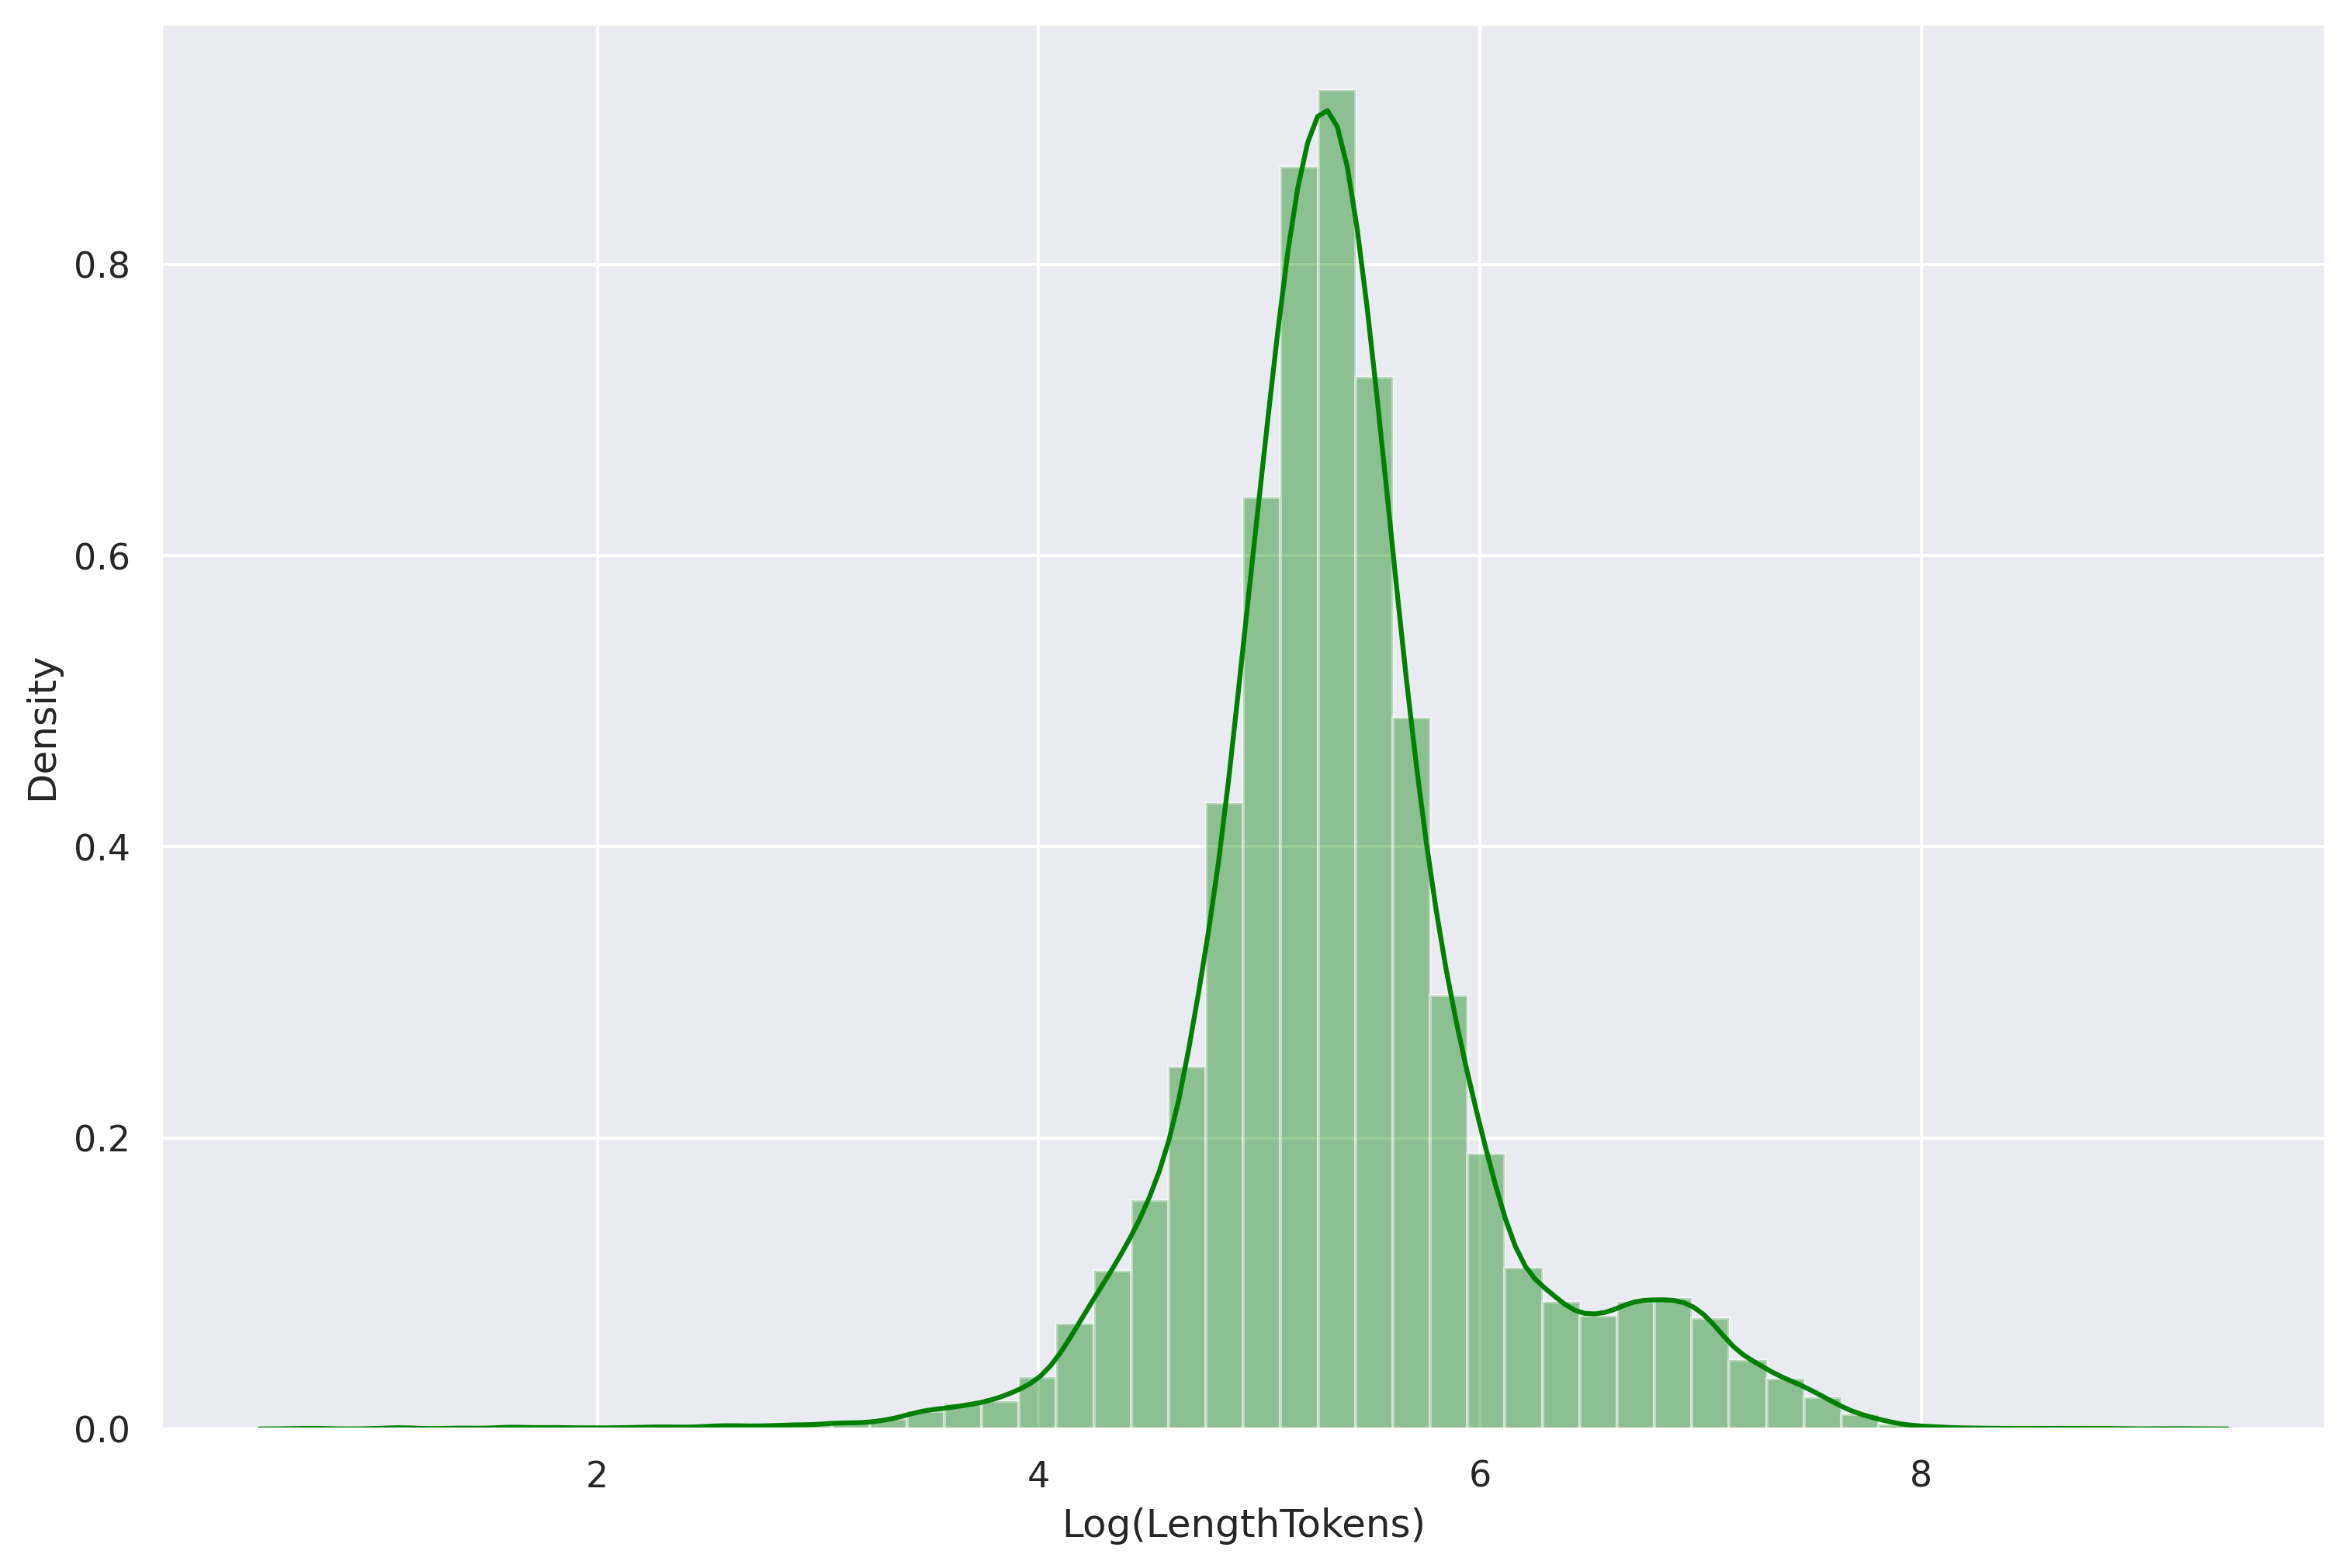

In [39]:
sns.set(rc={
    'figure.figsize':(12, 8),
    'figure.dpi': 300,
})
ax = sns.distplot(np.log1p(df_lens['LengthTokens']), color='green')
ax.set_xlabel('Log(LengthTokens)');
plt.savefig('Images/len_tokens.png', bbox_inches='tight')

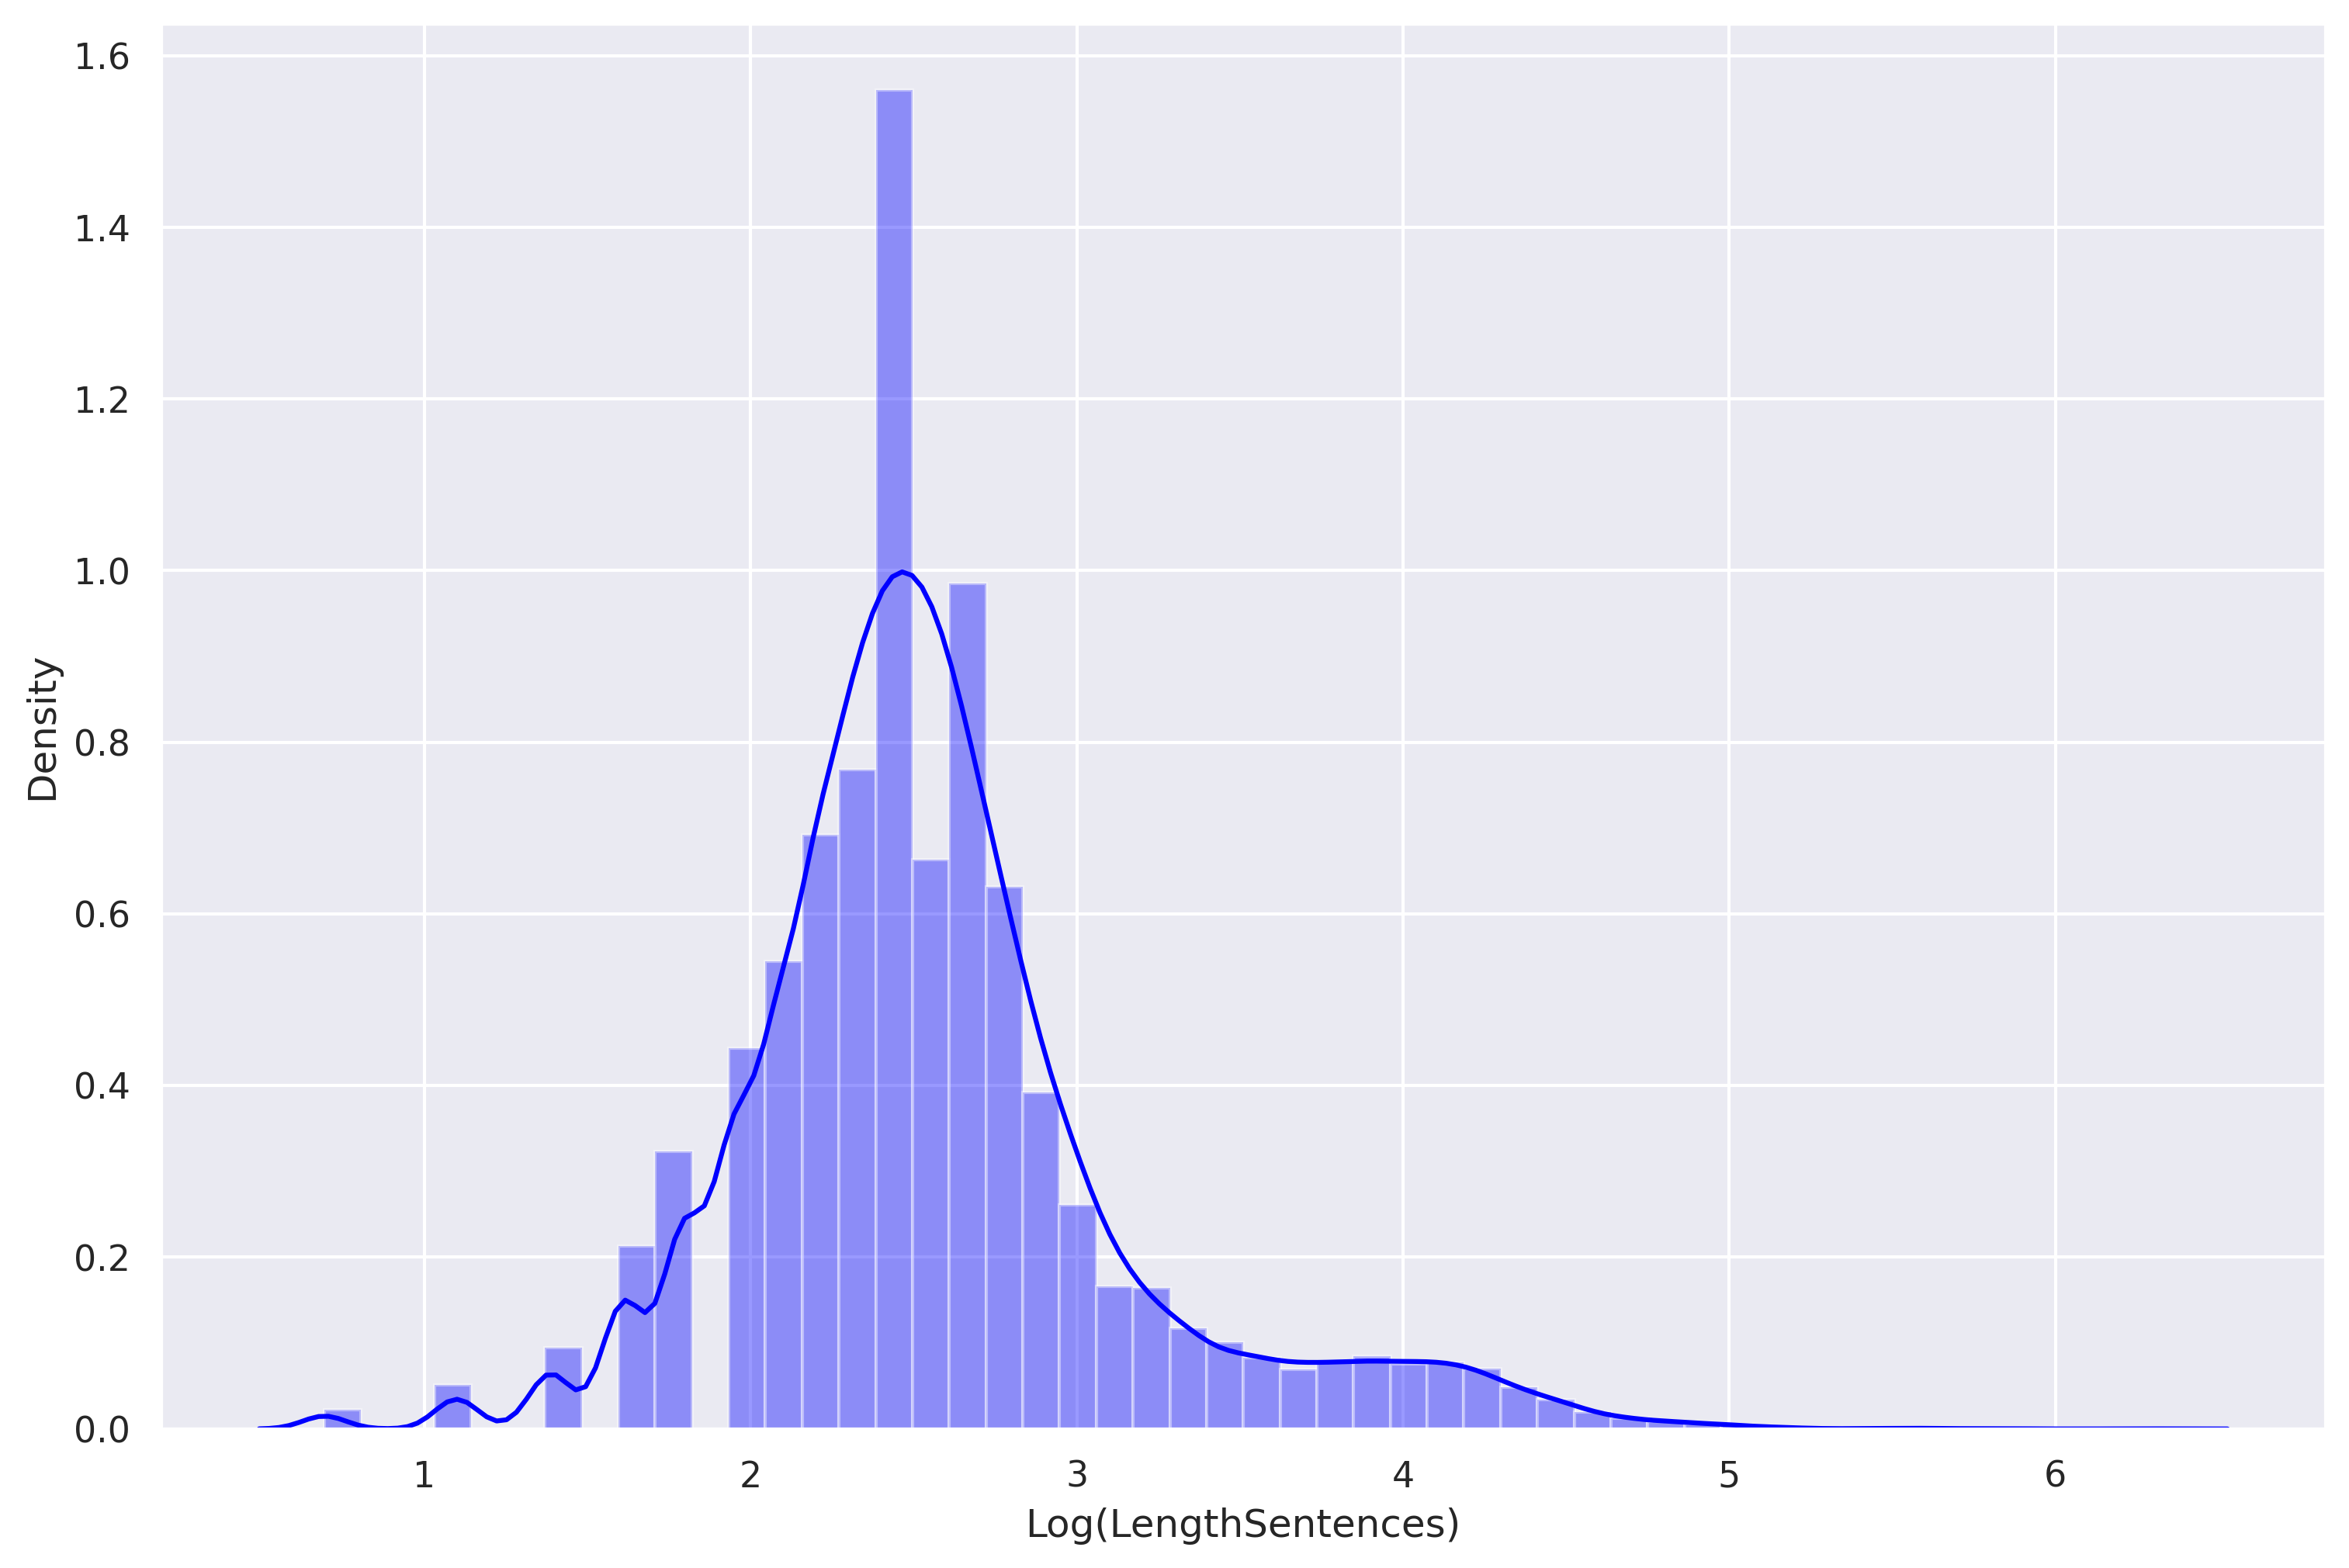

In [36]:
sns.set(rc={
    'figure.figsize':(12, 8),
    'figure.dpi': 300,
})
ax = sns.distplot(np.log1p(df_lens['LengthSentences']), color='blue')
ax.set_xlabel('Log(LengthSentences)');
plt.savefig('Images/len_sentences.png', bbox_inches='tight')

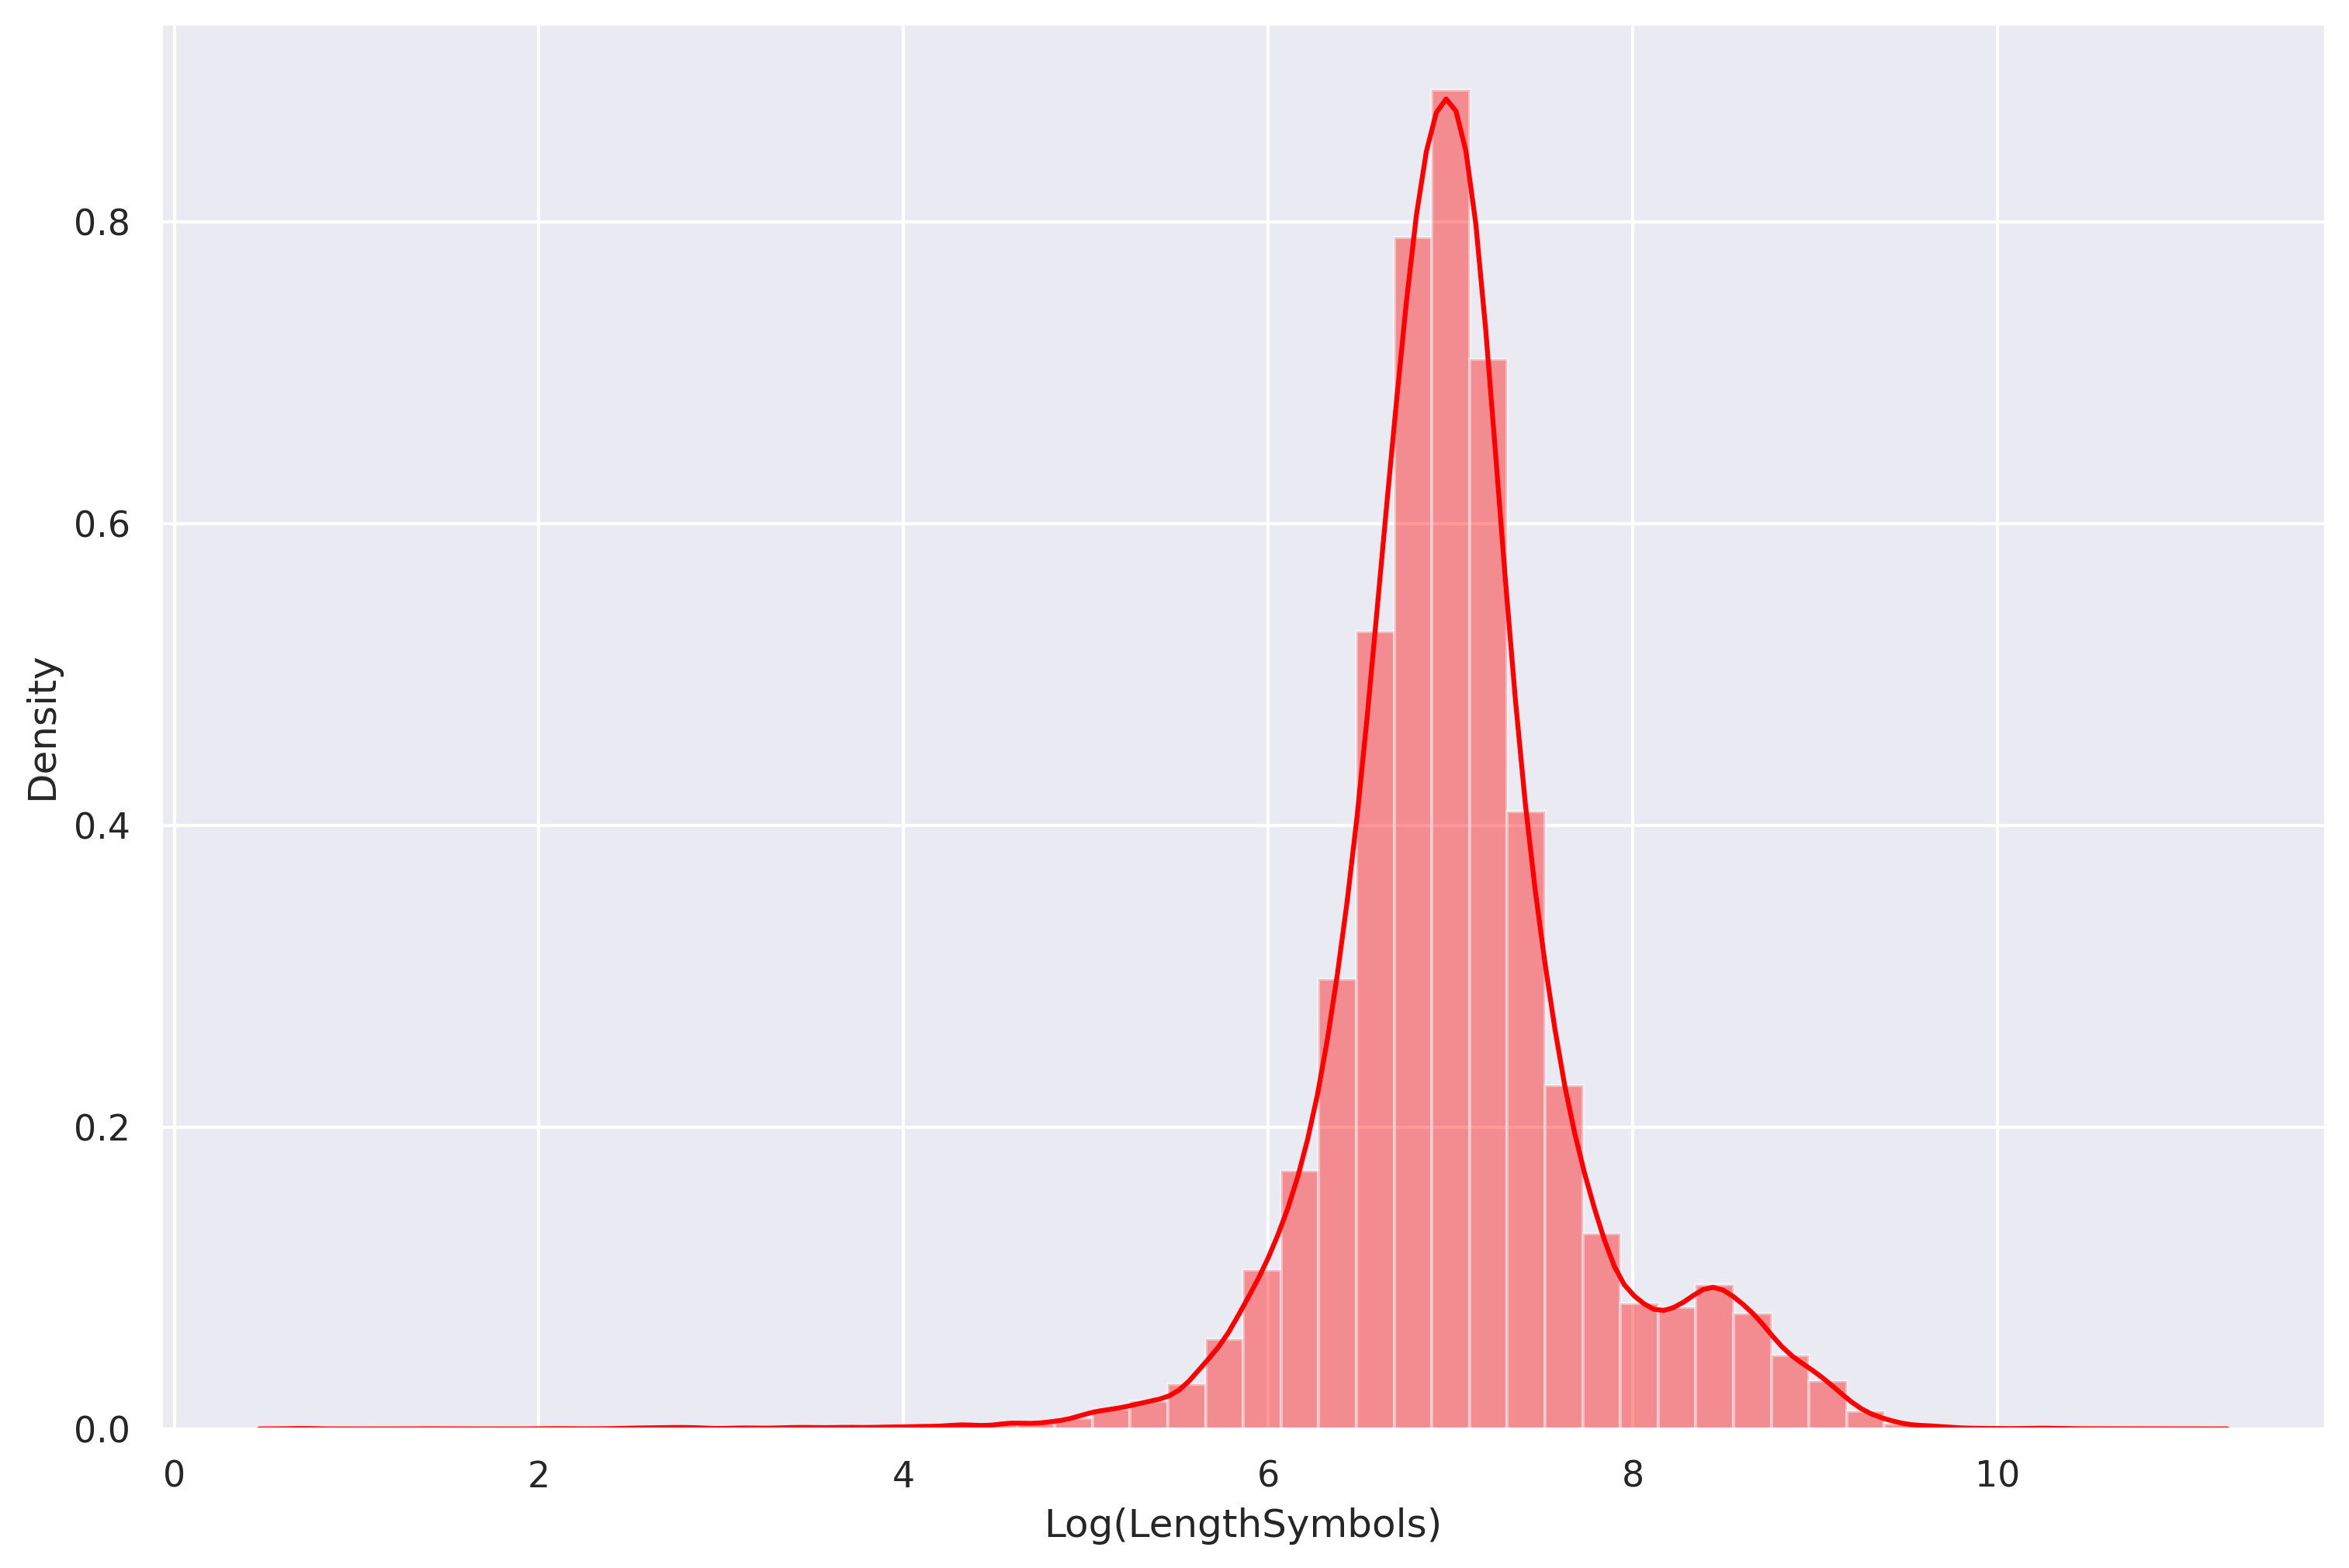

In [38]:
sns.set(rc={
    'figure.figsize':(12, 8),
    'figure.dpi': 300,
})
ax = sns.distplot(np.log1p(df_lens['LengthSymbols']), color='red')
ax.set_xlabel('Log(LengthSymbols)');
plt.savefig('Images/len_symbols.png', bbox_inches='tight')

> ## **Feature extraction: embeddings (SkipGram)**

In [ ]:
embs = dict()

with open('Features/news_upos_skipgram_300_5_2019.txt', 'r', encoding='utf-8') as fin:
    N, K = map(int, fin.readline().split())
    for i, line in tqdm(enumerate(fin), total=249318):
        word, *vals = line.strip().split()
        word = word[:word.find('_')]
        vals = list(map(float, vals))
        embs[word] = np.array(vals)

100%|██████████| 249318/249318 [00:32<00:00, 7576.93it/s]


In [ ]:
len(embs)

215875

In [ ]:
embs['президент']

In [ ]:
NUM_WORKERS = 32


df_embs = pd.DataFrame(index=range(len(df)), columns=['SkipGramEmbedding'])

In [ ]:
def get_skipgram_features(text):  # what about 5 special tokens? especially <NUM>
    tokens = [morph.parse(word)[0].normal_form for word in text.split()]
    text_embs = np.array([embs.get(word, np.zeros(300)) for word in tokens])
    return text_embs.mean(axis=0)

In [ ]:
with Pool(NUM_WORKERS) as pool:
    workers = [
        pool.apply_async(get_skipgram_features, args=(text,))
        for text in df['content']
    ]
    for i, w in enumerate(tqdm(workers)):
        df_embs.iloc[i]['SkipGramEmbedding'] = w.get()

In [ ]:
for i in trange(300):
    df_embs[f'SkipGramEmbedding_{i + 1}'] = pd.Series([x[i] for x in df_embs['SkipGramEmbedding']])
df_embs = df_embs.drop(columns=['SkipGramEmbedding'])

100%|██████████| 300/300 [00:15<00:00, 19.02it/s]


In [ ]:
df_embs.head()

SkipGramEmbedding_1  ...  SkipGramEmbedding_300
0            -0.038616  ...               0.030724
1            -0.051322  ...               0.016295
2            -0.039518  ...               0.034383
3            -0.028365  ...               0.046547
4             0.006870  ...               0.055312

[5 rows x 300 columns]

In [ ]:
df_embs.to_csv('Features/df_embs.csv', index=False)

In [ ]:
df_embs = pd.read_csv('Features/df_embs.csv')

> ## **Merging dense features together**

In [ ]:
data_features = pd.concat([df_pos, df_syntax, df_embs, df_lens], axis=1)

In [ ]:
data_features.head()

NOUN  ADJF  ADJS  ...  LengthSentences  LengthTokens  LengthSymbols
0   296   143  11.0  ...               46           838           5062
1   198    86  12.0  ...               30           621           3306
2   334   134  14.0  ...               33           968           5399
3   241    94  10.0  ...               39           700           4086
4   166    94  13.0  ...               30           625           2962

[5 rows x 367 columns]

In [ ]:
data_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57190 entries, 0 to 57189
Columns: 367 entries, NOUN to LengthSymbols
dtypes: float64(320), int64(47)
memory usage: 160.1 MB


In [ ]:
print(f'Size = {getsizeof(data_features) / (1024 * 1024)} Mb')

Size = 160.13145446777344 Mb


In [ ]:
data_sources = df['source']

In [ ]:
data_sources.to_csv('Features/data_sources.csv', index=False)

> ## **Train-test split: dense features + indices**

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(data_features, test_size=0.1, random_state=RANDOM_STATE, stratify=data_sources)
df_train, df_valid = train_test_split(df_train, test_size=1/9, random_state=RANDOM_STATE, stratify=data_sources[df_train.index])
df_mini_train, _ = train_test_split(df_train, train_size=1/8, random_state=RANDOM_STATE, stratify=data_sources[df_train.index])

train_indices = df_train.index
mini_train_indices = df_mini_train.index
test_indices = df_test.index
valid_indices = df_valid.index

df_train['class'] = df.loc[train_indices, 'class']
df_mini_train['class'] = df.loc[mini_train_indices, 'class']
df_test['class'] = df.loc[test_indices, 'class']
df_valid['class'] = df.loc[valid_indices, 'class']

df_train.index = range(len(df_train))
df_mini_train.index = range(len(df_mini_train))
df_test.index = range(len(df_test))
df_valid.index = range(len(df_valid))

In [ ]:
df_train['class']

0                    satire
1                 real_news
2                 real_news
3        citizen_journalism
4                 real_news
                ...        
45747             real_news
45748             real_news
45749             real_news
45750             real_news
45751             real_news
Name: class, Length: 45752, dtype: object

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45752 entries, 0 to 45751
Columns: 368 entries, NOUN to class
dtypes: float64(320), int64(47), object(1)
memory usage: 128.5+ MB


In [ ]:
df_mini_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5719 entries, 0 to 5718
Columns: 368 entries, NOUN to class
dtypes: float64(320), int64(47), object(1)
memory usage: 16.1+ MB


In [ ]:
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5719 entries, 0 to 5718
Columns: 368 entries, NOUN to class
dtypes: float64(320), int64(47), object(1)
memory usage: 16.1+ MB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5719 entries, 0 to 5718
Columns: 368 entries, NOUN to class
dtypes: float64(320), int64(47), object(1)
memory usage: 16.1+ MB


In [ ]:
pickle.dump(train_indices, open('Data for models/train_indices.sav', 'wb'))
pickle.dump(mini_train_indices, open('Data for models/mini_train_indices.sav', 'wb'))
pickle.dump(test_indices, open('Data for models/test_indices.sav', 'wb'))
pickle.dump(valid_indices, open('Data for models/valid_indices.sav', 'wb'))

In [ ]:
df_train.to_csv('Data for models/train.csv', index=False)
df_mini_train.to_csv('Data for models/mini_train.csv', index=False)
df_valid.to_csv('Data for models/dev.csv', index=False)
df_test.to_csv('Data for models/test.csv', index=False)

In [ ]:
df_train.head()

NOUN  ADJF  ADJS  ...  LengthTokens  LengthSymbols               class
0    53    18   0.0  ...           161            815              satire
1    71    29   1.0  ...           200           1270           real_news
2    67    21   0.0  ...           210           1182           real_news
3    72    47   8.0  ...           240           1228  citizen_journalism
4    92    31   1.0  ...           271           1473           real_news

[5 rows x 368 columns]

In [ ]:
df_train = pd.read_csv('Data for models/train.csv')
df_mini_train = pd.read_csv('Data for models/mini_train.csv')
df_valid = pd.read_csv('Data for models/dev.csv')
df_test = pd.read_csv('Data for models/test.csv')

In [ ]:
train_indices = pickle.load(open('Data for models/train_indices.sav', 'rb'))
mini_train_indices = pickle.load(open('Data for models/mini_train_indices.sav', 'rb'))
test_indices = pickle.load(open('Data for models/test_indices.sav', 'rb'))
valid_indices = pickle.load(open('Data for models/valid_indices.sav', 'rb'))

# ***Model selection: BERT (full-text)***

> ### Estimators + data

In [ ]:
D_enum_class = {
    'real_news': 0,
    'citizen_journalism': 1,
    'satire': 2,
    'commentary': 3,
    'persuasive_information': 4,
}

In [ ]:
df = pd.read_csv('special_tokenized_news.csv')

train_indices = pickle.load(open('Data for models/train_indices.sav', 'rb'))
test_indices = pickle.load(open('Data for models/test_indices.sav', 'rb'))
valid_indices = pickle.load(open('Data for models/valid_indices.sav', 'rb'))

In [ ]:
df_train = df.loc[train_indices]
df_valid = df.loc[valid_indices]
df_test = df.loc[test_indices]

In [ ]:
df_train['class'] = df_train['class'].map(lambda s: D_enum_class[s])
df_valid['class'] = df_valid['class'].map(lambda s: D_enum_class[s])
df_test['class'] = df_test['class'].map(lambda s: D_enum_class[s])

In [ ]:
def f1_macro(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')

def binary_mcc_score(y_true, y_pred):
    labels = list(set(y_true))

    tp = np.array([sum((y_pred == label) & (y_true == label))
                   for label in labels])
    tn = np.array([sum((y_pred != label) & (y_true != label))
                   for label in labels])
    fp = np.array([sum((y_pred == label) & (y_true != label))
                   for label in labels])
    fn = np.array([sum((y_pred != label) & (y_true == label))
                   for label in labels])
    
    binary_mcc = tp.sum() * tn.sum() - fp.sum() * fn.sum()
    if binary_mcc:
        binary_mcc /= np.sqrt(tp.sum() + fp.sum()) * np.sqrt(tp.sum() + fn.sum())
        binary_mcc /= np.sqrt(tn.sum() + fp.sum()) * np.sqrt(tn.sum() + fn.sum())
    
    return binary_mcc

def calc_soft_accuracy(y_true, y_pred, level):
    N = y_true.size
    acc = (y_pred == y_true).sum()
    soft_acc = ((y_pred != y_true) &
                (y_pred != D_enum_class['real_news']) &
                (y_true != D_enum_class['real_news'])).sum()
    return (acc + level * soft_acc) / N

def set_soft_acc_level(level):
    def wrapper(y_true, y_pred):
        return calc_soft_accuracy(y_true, y_pred, level)
    return wrapper

get_soft_accuracy = set_soft_acc_level(0.5)
soft_acc_scorer = make_scorer(get_soft_accuracy, greater_is_better=True)

> ### Model training

In [ ]:
model_args = {
    'fp16': True,
    'max_seq_length': 512,
    'train_batch_size': 16,
    'eval_batch_size': 16,
    'num_train_epochs': 2,
    'learning_rate': 4e-5,
    'process_count': 10,

    'do_lower_case': True,

    'overwrite_output_dir': True,
    'reprocess_input_data': True,
}

In [ ]:
# New pretrained model
model = ClassificationModel('roberta',
                            'blinoff/roberta-base-russian-v0',
                            use_cuda=True,
                            num_labels=5,
                            args=model_args)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/500M [00:00<?, ?B/s]

Some weights of the model checkpoint at blinoff/roberta-base-russian-v0 were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at blinoff/roberta-base-russian-v0 and are newly initialized: ['classifier.dense.weight', 'classif

Downloading:   0%|          | 0.00/1.68M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/16.0 [00:00<?, ?B/s]

In [ ]:
# Local trained model!
model = ClassificationModel('roberta',
                            'outputs',
                            use_cuda=True,
                            num_labels=5,
                            args=model_args)

In [ ]:
model.train_model(df_train[['content', 'class']])

  0%|          | 0/45752 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/2860 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/2860 [00:00<?, ?it/s]

(5720, 0.23640478842104526)

> ### Model evaluation

In [ ]:
result, model_outputs, wrong_predictions = model.eval_model(df_valid[['content', 'class']],
                                                            accuracy=accuracy_score,
                                                            soft_accuracy=get_soft_accuracy,
                                                            f1_macro=f1_macro,
                                                            binary_mcc=binary_mcc_score)

  0%|          | 0/5719 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/358 [00:00<?, ?it/s]

In [ ]:
result

{'accuracy': 0.9685259660779857,
 'binary_mcc': 0.9606574575974818,
 'eval_loss': 0.14175888029360942,
 'f1_macro': 0.945577289435733,
 'mcc': 0.9363188085771686,
 'soft_accuracy': 0.9737716383983214}

In [ ]:
result, model_outputs, wrong_predictions = model.eval_model(df_train[['content', 'class']],
                                                            accuracy=accuracy_score,
                                                            soft_accuracy=get_soft_accuracy,
                                                            f1_macro=f1_macro,
                                                            binary_mcc=binary_mcc_score)

  0%|          | 0/45752 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/2860 [00:00<?, ?it/s]

In [ ]:
result

{'accuracy': 0.9879786675992306,
 'binary_mcc': 0.9849733344990386,
 'eval_loss': 0.051153357253868666,
 'f1_macro': 0.9806604370505173,
 'mcc': 0.975784483119613,
 'soft_accuracy': 0.989672582619339}

In [ ]:
result, model_outputs, wrong_predictions = model.eval_model(df_test[['content', 'class']],
                                                            accuracy=accuracy_score,
                                                            soft_accuracy=get_soft_accuracy,
                                                            f1_macro=f1_macro,
                                                            binary_mcc=binary_mcc_score)

  0%|          | 0/5719 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/358 [00:00<?, ?it/s]

In [ ]:
result

{'accuracy': 0.9662528414058402,
 'binary_mcc': 0.9578160517572999,
 'eval_loss': 0.15040353524578962,
 'f1_macro': 0.9420688355292361,
 'mcc': 0.9316221920282415,
 'soft_accuracy': 0.9716733694701871}

> ### Test news

In [ ]:
reverse_D_enum_class = {
    0: 'real_news',
    1: 'citizen_journalism',
    2: 'satire',
    3: 'commentary',
    4: 'persuasive_information',
}

In [ ]:
test_news = r"""Россиянка узнала о продаже своей квартиры из квитанции за услуги ЖКХ
Жительница Краснодара лишилась квартиры, став жертвой неизвестных мошенников. О том, что недвижимость продана, она узнала из квитанции за жилищно-коммунальные услуги. Об этом сообщается на сайте прокуратуры Краснодарского края."""

predictions, raw_outputs = model.predict([test_news])
[reverse_D_enum_class[p] for p in predictions]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

['real_news']

In [ ]:
test_news = r"""Отдел информационных технологий Белого дома ищет причину технической неисправности, приведшей к тому, что во время выступления 15 апреля Джо Байден заявил о необходимости нормализовать отношения с Россией. Специалисты не исключают, что телесуфлёр президента подвергся хакерской атаке со стороны России, Китая и Ирана.
Оригинальный текст речи, заготовленной для выступления Байдена, содержал требование немедленно освободить политзаключённых, в том числе видеоблогера Алексея Навального, введение жёстких секторальных санкций, оружейное эмбарго и ввод войск НАТО в Крым. Однако по неизвестной причине на экране телесуфлёра в момент прямого эфира возник совсем другой текст. Озвучив его, Джо Байден выступил за нормализацию отношений с Россией, уважительно высказался о её народе и понадеялся на встречу с Путиным в Европе. Ведётся следствие.
«Мы не знаем, как именно это произошло, но не исключаем версию о взломе телесуфлёра хакерами их России, Китая и Ирана. Они уже не впервые вмешиваются в нашу демократию. Не хотелось бы, чтобы президент США стал марионеткой в руках хакеров, которые транслируют ему какой угодно текст на телесуфлёр. Это угроза нашей национальной безопасности, и это совершенно неприемлемо», - заявил глава отдела кибербезопасности Белого дома Рон Бармин.
"""

predictions, raw_outputs = model.predict([test_news])
[reverse_D_enum_class[p] for p in predictions]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

['satire']

In [ ]:
test_news = r"""Новый Суэцкий канал будет построен в рекордно короткие сроки в 5 километрах от старого. Концепцию проекта «Суэцкий поток-2» сегодня презентовал глава Роснефти президенту РФ.
— Мы с Игорем Ивановичем посовещались и решили помочь миру. Для этого мы пророем новый Суэцкий канал. Иначе они никогда не восстановят там судоходство, — сказал Владимир Путин по итогам встречи.
Стройка будет профинансирована из бюджета РФ, её стоимость предварительно оценивается в 100 млрд долларов. Бизнесмен Аркадий Ротенберг, построивший Крымский мост, заявил, что у него «больше нет денег». А Роман Абрамович экстренно покинул Россию. Между тем в поддержку строительства нового Суэцкого канала высказалось Всероссийское общество пенсионеров и бюджетников, которое заявило о готовности профинансировать часть проекта.
Тем временем президент Украины Владимир Зеленский назвал предложение Сечина провокацией против независимости Украины и призвал США заблокировать стройку.
Джо Байден, в свою очередь, отметил, что «мадам Зеленский очень здраво оценивает положение вещей», и предложил поручить строительство дублера Украине. Чуть позже в пресс-службе Белого дома пояснили, что президент США оговорился и «конечно же, имел в виду мистера Зеленского»."""

predictions, raw_outputs = model.predict([test_news])
[reverse_D_enum_class[p] for p in predictions]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

['satire']

In [ ]:
test_news = r"""Правительство России напечатает новые цены на наиболее важных продуктов и разошлет их по всем продовольственным магазинам в течение недели. Как сообщили Интерсаксу в пресс-службе Белого дома, типография Правительства РФ выполняет заказ на печать свыше миллиарда ценников.
В понедельник и вторник все ценники будут отпечатаны, затем будут разосланы по всем продуктовым магазинам, включая «Пятерочку», «Дикси», «Магнит» и др.
— Наши люди должны достойно встретить Новый год, не считая каждую копейку. Для этого в период с 27 декабря по 10 января мы зафиксируем цены в магазинах на такие жизненно важные товары, как сахар, хлеб, крупы, мясо, чай, водка и другие, — пояснил премьер-министр Михаил Мишустин.
Правительство не ожидает, что эта мера сильно ударит по рентабельности магазинов или приведет к дефициту товаров. «Наоборот, мы уверены, что это станет уроком от Правительства по правильному ценообразованию, который сделает отечественный рынок розничной продажи продуктов более прозрачным, сбалансированным и ориентированным на потребности клиента», — заверил Мишустин.
Между тем бывший премьер-министр, а сейчас зампред Совбеза Дмитрий Медведев предложил «отлить в граните» цены на продукты."""

predictions, raw_outputs = model.predict([test_news])
[reverse_D_enum_class[p] for p in predictions]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

['satire']

In [ ]:
test_news = r"""Формально нойз как музыкальный жанр произошел от таких направлений, как индастриал и эмбиент.
Но исторически он начал свой путь от концептуального искусства. И хоть классический нойз не имеет формы и ритма, в нем нередко используют вокальные семплы.
Считается, что отцом-основателем «искусства шума» является итальянец Луиджи Руссоло (о нем я писал в статье о звуковом дизайне, которую вы можете прочитать здесь.
Отмечу, что ключевым событием для экспериментальной музыки стала работа композитора Джона Кейджа под названием «4′33″», которая была исполнена в 1952 году. 
А вот первым, кто стал из шума делать композиции, считается Бойд Райс. 
Еще в 70-х он стал выпускать записи с немузыкальным шумом, которые позиционировались как законченные музыкальные произведения.
Кстати, сейчас Бойд выпускает музыку в рамках проекта NON, последний альбом был выпущен в 2019 году, его вы можете послушать здесь: 
Говоря о нойзе, нельзя обойти стороной «Индастриал».
Концепция жанра выходит за рамки музыки и показывает, что никакой свободы нет и все люди изначально репрессированы массовым производством и средствами массовой информации.
Таким образом, музыка для индастриала — не музыка «в привычном понимании», а «инструмент унижения, подавления и уничтожения».
Само собой, в индастриале присутствует целая гамма нойза.
Один из ярких примеров – это композиция «Slug Bait» 1977 года, которую написали Throbbing Gristle.
Чуть ранее, в 1975 году отец-основатель великих The Velvet Underground Лу Рид выпустил очень спорную с точки зрения классического понятия музыки работу под названием «Metal Machine Music».
Весь альбом полностью состоит из звука заведенной гитары, которую прогоняли на разных скоростях.
LP был записан в его нью-йоркской квартире на четырехдорожечном магнитофоне за несколько часов. 
Ну а теперь перейдем к стране, которая популяризировала нойз настолько, что появился отдельный поджанр под названием «Japanoise».
Думаю, вы поняли, что речь пойдет о Японии.
Это огромная и самобытная музыкальная сцена, которая оказала сильное влияние на развитие концептуальных жанров.
Более того, несколько десятилетий назад в стране восходящего солнца Джапанойз признали уникальным национальным явлением, в ответ на западную музыку.
И сейчас в Японии насчитывается несколько сотен нойз-музыкантов и коллективов, среди которых  Merzbow, Masonna, Aube, Contagious Orgasm, Melt-Banana, Boredoms, The Gerogerigegege и еще куча других. 
В нашей стране нойз тоже был всегда востребован. Не так сильно, как в Японии, но тем не менее, даже в 2021 году вы можете сходить в какой-нибудь клуб Москвы или Питера и послушать как электронные музыканты крутят шум из аналоговых синтезаторов.
Что касается нашей необъятной, то принято считать Александра Индустриевича Лебедева-Фронтова центральной фигурой нойза.
Он был так же граффитистом и очень тесно общался с небезызвестным Сергеем Курехиным.
Можете поставить на фон его альбом 1998 года под названием «Fanatisch Eiskalt Maschine»  
Нойз-музыка может найти себе применение абсолютно во всем: от рока до поп-музыки.
Лично я никогда не был поклонником данного жанра и думаю, что многие мои читатели со скрипом на зубах могут послушать несколько минут того же Merzbow.
Может быть, через несколько десятков или сотен лет нойз успешно интегрируется в популярную музыку, и мы услышим совершенно новые, прежде невиданной красоты композиции.
Ну а пока можно довольствоваться экспериментальной электронщиной и звуками перегруженного трансформатора."""

predictions, raw_outputs = model.predict([test_news])
[reverse_D_enum_class[p] for p in predictions]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

['citizen_journalism']

In [ ]:
test_news = r"""Учёный совет Института Русского языка им. Виноградова РАН на экстренном заседании в четверг принял решение отнести слово «доллар» к числу нецензурных. Решение вступает в силу 20 апреля.
Согласно выводам рабочей группы, заключение которой огласили на Учёном совете, Соединённые Штаты Америки ведут планомерную антироссийскую политику, разрушая русскую культуру, нравственность, экономику и патриотизм. Американская валюта играет в этом ключевую роль, являясь инструментом прямого негативного действия на ткань русского сознания. Таким образом, слово «доллар» должно занять место в ряду фонем, неприемлемых ни в речи, ни на письме.
Один из участников совета заметил, что слово «доллар» относится не только к валюте США, но и к денежным единицам стран, нейтральных и даже дружественных России. Существуют австралийский доллар, зимбабвийский доллар, родезийский доллар и многие другие. Есть также город Доллар в Шотландии, что создаёт почву для путаницы. После обсуждения совет решил, что при наличии уточняющего слова, например, «доллар Кирибати», слово «доллар» может использоваться безнаказанно.
«В русском языке есть слова двойственной коннотации. Например, в устах собаковода слово «сука» означает лишь пол собаки, для других же людей это явно обсценное слово», - сказал глава Учёного совета академик Александр Молдован.
С 20 апреля за произнесение слов «доллар» или «доллар США» в общественном месте россиян ждёт административный штраф в 500 рублей, а средства массовой информации – предупреждение Роскомнадзора или вызов в суд.
"""

predictions, raw_outputs = model.predict([test_news])
[reverse_D_enum_class[p] for p in predictions]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

['satire']

> ### Memory cleaning

In [ ]:
del model

In [ ]:
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
torch.cuda.memory_allocated() / (1024 * 1024 * 1024)

# ***Model selection: dense features***

> ## **Estimation: scorer**

In [ ]:
df_train = pd.read_csv('Data for models/train.csv')
df_mini_train = pd.read_csv('Data for models/mini_train.csv')
df_valid = pd.read_csv('Data for models/dev.csv')
df_test = pd.read_csv('Data for models/test.csv')

In [ ]:
X_train, y_train = df_train.drop(columns=['class']), df_train['class']
X_mini_train, y_mini_train = df_mini_train.drop(columns=['class']), df_mini_train['class']
X_valid, y_valid = df_valid.drop(columns=['class']), df_valid['class']
X_test, y_test = df_test.drop(columns=['class']), df_test['class']

In [ ]:
X_valid.shape, y_valid.shape

((5719, 367), (5719,))

In [ ]:
D_enum_class = {
    'real_news': 0,
    'citizen_journalism': 1,
    'satire': 2,
    'commentary': 3,
    'persuasive_information': 4,
}

In [ ]:
y_train = y_train.map(lambda s: D_enum_class[s])
y_mini_train = y_mini_train.map(lambda s: D_enum_class[s])
y_valid = y_valid.map(lambda s: D_enum_class[s])
y_test = y_test.map(lambda s: D_enum_class[s])

In [ ]:
train_ind = np.repeat(-1, y_mini_train.size)
valid_ind = np.repeat(0, y_valid.size)
ps = PredefinedSplit(test_fold=np.concatenate((train_ind, valid_ind)))

X_fit = pd.concat([X_mini_train, X_valid])
X_fit.index = range(len(X_fit))
y_fit = pd.concat([y_mini_train, y_valid])
y_fit.index = range(len(y_fit))

In [ ]:
def calc_soft_accuracy(y_true, y_pred, level):
    N = y_true.size
    acc = (y_pred == y_true).sum()
    soft_acc = ((y_pred != y_true) &
                (y_pred != D_enum_class['real_news']) &
                (y_true != D_enum_class['real_news'])).sum()
    return (acc + level * soft_acc) / N

def set_soft_acc_level(level):
    def wrapper(y_true, y_pred):
        return calc_soft_accuracy(y_true, y_pred, level)
    return wrapper

get_soft_accuracy = set_soft_acc_level(0.5)
soft_acc_scorer = make_scorer(get_soft_accuracy, greater_is_better=True)

In [ ]:
def get_score(y_true, y_pred):
    labels = list(set(y_true))
    N = y_true.size

    tp = np.array([sum((y_pred == label) & (y_true == label))
                   for label in labels])
    tn = np.array([sum((y_pred != label) & (y_true != label))
                   for label in labels])
    fp = np.array([sum((y_pred == label) & (y_true != label))
                   for label in labels])
    fn = np.array([sum((y_pred != label) & (y_true == label))
                   for label in labels])

    accuracy = tp.sum() / N
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f1 = (2 * prec * rec) / (prec + rec)

    f1_macro = f1.mean()

    soft_accuracy = get_soft_accuracy(y_true, y_pred)
    
    binary_mcc = tp.sum() * tn.sum() - fp.sum() * fn.sum()
    if binary_mcc:
        binary_mcc /= np.sqrt(tp.sum() + fp.sum()) * np.sqrt(tp.sum() + fn.sum())
        binary_mcc /= np.sqrt(tn.sum() + fp.sum()) * np.sqrt(tn.sum() + fn.sum())
    
    mcc_t = (tp + fn)
    mcc_p = (tp + fp)
    mcc = tp.sum() * N - mcc_t @ mcc_p
    if mcc:
        mcc /= np.sqrt((N * N - mcc_p @ mcc_p) * (N * N - mcc_t @ mcc_t))
    
    return {
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'accuracy': accuracy * 100,
        'soft_accuracy': soft_accuracy * 100,
        'f1_macro': f1_macro * 100,
        'mcc': mcc * 100,
        'binary_mcc': binary_mcc * 100,
    }

In [ ]:
def estimate(model, dataset='train', to_dense=False):
    if dataset == 'mini_train':
        print('Evaluation on mini_train')
        y_pred = model.predict(X_mini_train.toarray() if to_dense else X_mini_train)
        results = get_score(y_mini_train, y_pred)
    elif dataset == 'train':
        print('Evaluation on train')
        y_pred = model.predict(X_train.toarray() if to_dense else X_train)
        results = get_score(y_train, y_pred)
    elif dataset == 'valid':
        print('Evaluation on valid')
        y_pred = model.predict(X_valid.toarray() if to_dense else X_valid)
        results = get_score(y_valid, y_pred)
    elif dataset == 'test':
        print('Evaluation on test')
        y_pred = model.predict(X_test.toarray() if to_dense else X_test)
        results = get_score(y_test, y_pred)
    else:
        raise ValueError(f'Unknown value of attribute "dataset": "{dataset}"')
    
    for key, val in results.items():
        if isinstance(val, float):
            print(f'{key} -> {val:.3f}')
        else:
            print(f'{key} -> {val}')

> ## **Model selection: Decision Tree**

In [ ]:
best_tree_model = GridSearchCV(estimator=DecisionTreeClassifier(random_state=RANDOM_STATE),
                               param_grid={'max_depth': np.arange(5, 41, 5),
                                           'min_samples_leaf': [1, 5, 10, 15, 20],
                               },
                               n_jobs=-1,
                               scoring=soft_acc_scorer,
                               cv=ps) \
                  .fit(X_fit, y_fit) \
                  .best_estimator_

print(best_tree_model)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')


In [ ]:
estimate(best_tree_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3717  324  278  341  115]
tn -> [1199 5073 4964 5228 5468]
fp -> [577  85 196  53  33]
fn -> [226 237 281  97 103]
accuracy -> 83.494
soft_accuracy -> 84.726
f1_macro -> 71.138
mcc -> 64.777
binary_mcc -> 79.367


In [ ]:
estimate(best_tree_model, dataset='train')

Evaluation on train
tp -> [28510  2140  1532  2589   767]
tn -> [ 8372 40208 38922 41623 43669]
fp -> [5835 1055 2354  629  341]
fn -> [3035 2349 2944  911  975]
accuracy -> 77.675
soft_accuracy -> 79.144
f1_macro -> 61.956
mcc -> 52.042
binary_mcc -> 72.094


In [ ]:
estimate(best_tree_model, dataset='valid')

Evaluation on valid
tp -> [3709  318  262  367  113]
tn -> [1210 5065 4950 5230 5471]
fp -> [567  93 210  50  30]
fn -> [233 243 297  72 105]
accuracy -> 83.389
soft_accuracy -> 84.700
f1_macro -> 70.975
mcc -> 64.651
binary_mcc -> 79.236


> ## **Model selection: Random Forest**

In [ ]:
best_forest_model = GridSearchCV(estimator=RandomForestClassifier(random_state=RANDOM_STATE),
                                 param_grid={'n_estimators': np.arange(5, 41, 5),
                                             'max_depth': np.arange(5, 16, 5),
                                             'max_features': np.arange(20, X_train.shape[1] + 1, 20),
                                 },
                                 n_jobs=-1,
                                 scoring=soft_acc_scorer,
                                 cv=ps) \
                    .fit(X_fit, y_fit) \
                    .best_estimator_

print(best_forest_model)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features=220,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [ ]:
estimate(best_forest_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3938  456  457  420  209]
tn -> [1553 5156 5156 5271 5501]
fp -> [223   2   4  10   0]
fn -> [  5 105 102  18   9]
accuracy -> 95.821
soft_accuracy -> 95.917
f1_macro -> 94.192
mcc -> 91.525
binary_mcc -> 94.776


In [ ]:
estimate(best_forest_model, dataset='train')

Evaluation on train
tp -> [30946  2358  1204  2877  1179]
tn -> [ 8157 40999 40906 41852 43906]
fp -> [6050  264  370  400  104]
fn -> [ 599 2131 3272  623  563]
accuracy -> 84.289
soft_accuracy -> 84.878
f1_macro -> 71.855
mcc -> 65.981
binary_mcc -> 80.362


In [ ]:
estimate(best_forest_model, dataset='valid')

Evaluation on valid
tp -> [3938  478  446  424  216]
tn -> [1574 5157 5159 5268 5501]
fp -> [203   1   1  12   0]
fn -> [  4  83 113  15   2]
accuracy -> 96.206
soft_accuracy -> 96.293
f1_macro -> 94.897
mcc -> 92.326
binary_mcc -> 95.257


> ## **Model selection: XGBoost**

In [ ]:
best_boost_model = GridSearchCV(estimator=XGBClassifier(random_state=RANDOM_STATE,
                                                        objective='multi:softmax',
                                                        num_class=5,
                                                        tree_method='gpu_hist',
                                                        gpu_id=0,
                                                        learning_rate=1,
                                                        njobs=-1),
                                param_grid={'reg_alpha': [10 ** k for k in range(-3, 4)],
                                            'reg_lambda': [10 ** k for k in range(-3, 4)],
                                            'max_depth': np.arange(1, 6),
                                            'n_estimators': np.arange(1, 6),
                                },
                                n_jobs=-1,
                                scoring=soft_acc_scorer,
                                cv=ps) \
                   .fit(X_fit, y_fit) \
                   .best_estimator_

print(best_boost_model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              learning_rate=1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=5, n_jobs=1,
              njobs=-1, nthread=None, num_class=5, objective='multi:softprob',
              random_state=42, reg_alpha=0.001, reg_lambda=1,
              scale_pos_weight=1, seed=None, silent=None, subsample=1,
              tree_method='gpu_hist', verbosity=1)


In [ ]:
estimate(best_boost_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3867  397  391  414  212]
tn -> [1442 5136 5100 5264 5496]
fp -> [334  22  60  17   5]
fn -> [ 76 164 168  24   6]
accuracy -> 92.341
soft_accuracy -> 92.586
f1_macro -> 89.233
mcc -> 84.175
binary_mcc -> 90.427


In [ ]:
estimate(best_boost_model, dataset='train')

Evaluation on train
tp -> [30151  2512  2040  3008  1293]
tn -> [ 9642 40662 40319 41766 43871]
fp -> [4565  601  957  486  139]
fn -> [1394 1977 2436  492  449]
accuracy -> 85.251
soft_accuracy -> 86.113
f1_macro -> 75.836
mcc -> 68.550
binary_mcc -> 81.564


In [ ]:
estimate(best_boost_model, dataset='valid')

Evaluation on valid
tp -> [3877  416  371  426  213]
tn -> [1455 5134 5116 5255 5500]
fp -> [322  24  44  25   1]
fn -> [ 65 145 188  13   5]
accuracy -> 92.726
soft_accuracy -> 92.980
f1_macro -> 89.777
mcc -> 85.014
binary_mcc -> 90.908


> ## **Model selection: SVM**



In [ ]:
best_svm_model = GridSearchCV(estimator=SVC(random_state=RANDOM_STATE,
                                            max_iter=200),
                              param_grid={'C': [10 ** k for k in range(-5, 6)],
                                          'kernel': ['linear', 'poly', 'rbf'],
                                          'degree': [1, 2, 3, 4, 5],
                                          'gamma': ['scale', 'auto'],
                              },
                              n_jobs=-1,
                              scoring=soft_acc_scorer,
                              cv=ps) \
                 .fit(X_fit, y_fit) \
                 .best_estimator_

print(best_svm_model)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=200, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)


In [ ]:
estimate(best_svm_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3845  183  112  116  151]
tn -> [ 572 5088 5136 5278 5490]
fp -> [1204   70   24    3   11]
fn -> [ 98 378 447 322  67]
accuracy -> 77.059
soft_accuracy -> 77.146
f1_macro -> 56.768
mcc -> 46.422
binary_mcc -> 71.324


In [ ]:
estimate(best_svm_model, dataset='train')

Evaluation on train
tp -> [30221   897   406   441   833]
tn -> [ 2978 40456 40864 41980 43776]
fp -> [11229   807   412   272   234]
fn -> [1324 3592 4070 3059  909]
accuracy -> 71.686
soft_accuracy -> 72.125
f1_macro -> 41.471
mcc -> 28.559
binary_mcc -> 64.608


In [ ]:
estimate(best_svm_model, dataset='valid')

Evaluation on valid
tp -> [3837  178  117  177  194]
tn -> [ 670 5080 5135 5279 5496]
fp -> [1107   78   25    1    5]
fn -> [105 383 442 262  24]
accuracy -> 78.738
soft_accuracy -> 78.773
f1_macro -> 62.747
mcc -> 51.490
binary_mcc -> 73.422


> ## **Model selection: kNN**

In [ ]:
best_knn_model = GridSearchCV(estimator=KNeighborsClassifier(),
                              param_grid={'n_neighbors': [1, 3, 5, 7, 9],
                                          'p': [1, 2, 3],
                              },
                              n_jobs=-1,
                              scoring=soft_acc_scorer,
                              cv=ps) \
                 .fit(X_fit, y_fit) \
                 .best_estimator_

print(best_knn_model)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=1,
                     weights='uniform')


In [ ]:
estimate(best_knn_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3837  217  186  351  102]
tn -> [ 956 5107 5102 5198 5487]
fp -> [820  51  58  83  14]
fn -> [106 344 373  87 116]
accuracy -> 82.060
soft_accuracy -> 82.934
f1_macro -> 65.899
mcc -> 60.436
binary_mcc -> 77.575


In [ ]:
estimate(best_knn_model, dataset='train')

Evaluation on train
tp -> [30397  1484  1126  2702   815]
tn -> [ 6942 40812 40564 41571 43891]
fp -> [7265  451  712  681  119]
fn -> [1148 3005 3350  798  927]
accuracy -> 79.830
soft_accuracy -> 80.721
f1_macro -> 61.827
mcc -> 54.753
binary_mcc -> 74.788


In [ ]:
estimate(best_knn_model, dataset='valid')

Evaluation on valid
tp -> [3832  216  193  371   98]
tn -> [ 985 5104 5101 5184 5493]
fp -> [792  54  59  96   8]
fn -> [110 345 366  68 120]
accuracy -> 82.357
soft_accuracy -> 83.293
f1_macro -> 66.289
mcc -> 61.262
binary_mcc -> 77.946


> ## **Model selection: Gaussian Naive Bayes**

In [ ]:
best_gaussian_bayes_model = GridSearchCV(estimator=GaussianNB(),
                                         param_grid={
                                             'var_smoothing': [0] + [10 ** k for k in range(-15, 16)],
                                         },
                                         n_jobs=-1,
                                         scoring=soft_acc_scorer,
                                         cv=ps) \
                            .fit(X_fit, y_fit) \
                            .best_estimator_

print(best_gaussian_bayes_model)

GaussianNB(priors=None, var_smoothing=0.1)


In [ ]:
estimate(best_gaussian_bayes_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3875    0    0  185   10]
tn -> [ 252 5158 5160 5171 5486]
fp -> [1524    0    0  110   15]
fn -> [ 68 561 559 253 208]
accuracy -> 71.166
soft_accuracy -> 71.665
f1_macro -> nan
mcc -> 24.649
binary_mcc -> 63.958


In [ ]:
estimate(best_gaussian_bayes_model, dataset='train')

Evaluation on train
tp -> [31049     0     0  1521    58]
tn -> [ 2012 41263 41276 41414 43919]
fp -> [12195     0     0   838    91]
fn -> [ 496 4489 4476 1979 1684]
accuracy -> 71.315
soft_accuracy -> 71.788
f1_macro -> nan
mcc -> 25.223
binary_mcc -> 64.144


In [ ]:
estimate(best_gaussian_bayes_model, dataset='valid')

Evaluation on valid
tp -> [3872    0    0  201    6]
tn -> [ 269 5158 5160 5165 5484]
fp -> [1508    0    0  115   17]
fn -> [ 70 561 559 238 212]
accuracy -> 71.324
soft_accuracy -> 71.866
f1_macro -> nan
mcc -> 25.577
binary_mcc -> 64.155


> ## **Model selection: Bernoulli Naive Bayes**

In [ ]:
best_bernoulli_bayes_model = GridSearchCV(estimator=BernoulliNB(),
                                          param_grid={
                                              'alpha': [0] + [10 ** k for k in range(-15, 16)],
                                              'binarize': [0] + [10 ** k for k in range(-15, 16)] + [-(10 ** k) for k in range(-15, 16)],
                                          },
                                          n_jobs=-1,
                                          scoring=soft_acc_scorer,
                                          cv=ps) \
                             .fit(X_fit, y_fit) \
                             .best_estimator_

print(best_bernoulli_bayes_model)

BernoulliNB(alpha=10, binarize=-1e-15, class_prior=None, fit_prior=True)


In [ ]:
estimate(best_bernoulli_bayes_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3371  324  189  368  133]
tn -> [1247 5014 4899 4960 5422]
fp -> [529 144 261 321  79]
fn -> [572 237 370  70  85]
accuracy -> 76.674
soft_accuracy -> 78.711
f1_macro -> 62.713
mcc -> 53.812
binary_mcc -> 70.843


In [ ]:
estimate(best_bernoulli_bayes_model, dataset='train')

Evaluation on train
tp -> [27005  2647  1528  2983   987]
tn -> [10019 40107 39240 39720 43320]
fp -> [4188 1156 2036 2532  690]
fn -> [4540 1842 2948  517  755]
accuracy -> 76.827
soft_accuracy -> 78.875
f1_macro -> 62.372
mcc -> 54.122
binary_mcc -> 71.034


In [ ]:
estimate(best_bernoulli_bayes_model, dataset='valid')

Evaluation on valid
tp -> [3408  362  185  383  134]
tn -> [1286 5011 4929 4972 5431]
fp -> [491 147 231 308  70]
fn -> [534 199 374  56  84]
accuracy -> 78.195
soft_accuracy -> 80.136
f1_macro -> 64.767
mcc -> 56.857
binary_mcc -> 72.744


> ## **Model selection: Multi-layer Perceptron**

In [ ]:
best_nn_model = GridSearchCV(estimator=MLPClassifier(random_state=RANDOM_STATE,
                                                     batch_size=128,
                                                     hidden_layer_sizes=(256, 256),
                                                     learning_rate='adaptive'),
                             param_grid={'activation': ['logistic', 'tanh', 'relu'],
                                         'solver': ['adam', 'sgd'],
                                         'learning_rate_init': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5],
                                         'alpha': [0] + [10 ** k for k in range(-5, 6)],
                                         'max_iter': [1, 5, 10, 20],
                             },
                             n_jobs=-1,
                             scoring=soft_acc_scorer,
                             cv=ps) \
                .fit(X_fit, y_fit) \
                .best_estimator_

print(best_nn_model)

MLPClassifier(activation='logistic', alpha=0.001, batch_size=128, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(256, 256), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=10,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


In [ ]:
estimate(best_nn_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3856  304  113  346  147]
tn -> [1003 5085 5142 5213 5480]
fp -> [773  73  18  68  21]
fn -> [ 87 257 446  92  71]
accuracy -> 83.336
soft_accuracy -> 84.149
f1_macro -> 68.985
mcc -> 63.738
binary_mcc -> 79.170


In [ ]:
estimate(best_nn_model, dataset='train')

Evaluation on train
tp -> [30828  2512   845  2869  1136]
tn -> [ 8110 40699 41133 41630 43874]
fp -> [6097  564  143  622  136]
fn -> [ 717 1977 3631  631  606]
accuracy -> 83.472
soft_accuracy -> 84.289
f1_macro -> 68.970
mcc -> 64.102
binary_mcc -> 79.340


In [ ]:
estimate(best_nn_model, dataset='valid')

Evaluation on valid
tp -> [3833  338  102  375  144]
tn -> [1047 5067 5148 5199 5488]
fp -> [730  91  12  81  13]
fn -> [109 223 457  64  74]
accuracy -> 83.791
soft_accuracy -> 84.560
f1_macro -> 69.866
mcc -> 64.977
binary_mcc -> 79.739


> ## **Model selection: Logistic Regression**

In [ ]:
best_logreg_model = GridSearchCV(estimator=LogisticRegression(random_state=RANDOM_STATE,
                                                              max_iter=100,
                                                              n_jobs=-1),
                                 param_grid={'penalty': ['l1', 'l2', 'none'],
                                             'C': [10 ** k for k in range(-5, 6)],
                                             'solver': ['newton-cg', 'lbfgs', 'saga'],
                                             'multi_class': ['ovr', 'multinomial'],
                                 },
                                 n_jobs=-1,
                                 scoring=soft_acc_scorer,
                                 cv=ps) \
                    .fit(X_fit, y_fit) \
                    .best_estimator_

print(best_logreg_model)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=-1, penalty='l2', random_state=42,
                   solver='newton-cg', tol=0.0001, verbose=0, warm_start=False)


In [ ]:
estimate(best_logreg_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3835  357  361  397  190]
tn -> [1365 5111 5088 5251 5482]
fp -> [411  47  72  30  19]
fn -> [108 204 198  41  28]
accuracy -> 89.876
soft_accuracy -> 90.400
f1_macro -> 84.244
mcc -> 78.853
binary_mcc -> 87.345


In [ ]:
estimate(best_logreg_model, dataset='train')

Evaluation on train
tp -> [30534  2804  2784  3077  1386]
tn -> [10692 40774 40507 41984 43884]
fp -> [3515  489  769  268  126]
fn -> [1011 1685 1692  423  356]
accuracy -> 88.707
soft_accuracy -> 89.407
f1_macro -> 81.921
mcc -> 76.285
binary_mcc -> 85.883


In [ ]:
estimate(best_logreg_model, dataset='valid')

Evaluation on valid
tp -> [3838  373  367  411  200]
tn -> [1403 5103 5095 5248 5497]
fp -> [374  55  65  32   4]
fn -> [104 188 192  28  18]
accuracy -> 90.733
soft_accuracy -> 91.187
f1_macro -> 86.324
mcc -> 80.738
binary_mcc -> 88.416


> ## **Top features** [*tree-based models only*]

In [ ]:
def top_features(model, n=10):
    keys = model.feature_importances_
    idxs = np.arange(X_train.shape[1])
    idxs = sorted(idxs, key=lambda x: keys[x], reverse=True)
    features = X_train.columns
    for idx in idxs[:n]:
        col = features[idx]
        key = keys[idx] * 100
        print(f"{col}: {key:.3f}")

In [ ]:
top_features(best_tree_model, n=20)

PRCL: 26.105
SkipGramEmbedding_263: 9.645
SkipGramEmbedding_198: 7.987
NOUN: 4.408
SkipGramEmbedding_175: 2.581
SkipGramEmbedding_114: 2.575
SkipGramEmbedding_229: 2.300
SkipGramEmbedding_279: 2.034
SkipGramEmbedding_124: 1.928
SkipGramEmbedding_72: 1.880
ccomp: 1.436
SkipGramEmbedding_184: 1.242
SkipGramEmbedding_22: 1.105
SkipGramEmbedding_209: 1.006
SkipGramEmbedding_129: 0.991
ADVB: 0.974
SkipGramEmbedding_206: 0.946
SkipGramEmbedding_120: 0.846
LengthTokens: 0.795
obj: 0.789


In [ ]:
top_features(best_forest_model, n=20)

PRCL: 7.992
SkipGramEmbedding_263: 4.436
advmod: 3.837
SkipGramEmbedding_124: 2.789
CONJ: 2.513
ADVB: 2.394
SkipGramEmbedding_283: 1.834
SkipGramEmbedding_198: 1.779
SkipGramEmbedding_229: 1.523
NOUN: 1.501
LengthSymbols: 1.259
SkipGramEmbedding_279: 1.107
SkipGramEmbedding_114: 1.093
SkipGramEmbedding_173: 0.988
SkipGramEmbedding_267: 0.920
ccomp: 0.886
SkipGramEmbedding_156: 0.835
nmod: 0.825
SkipGramEmbedding_184: 0.749
punct: 0.731


In [ ]:
top_features(best_boost_model, n=20)

PRCL: 7.954
SkipGramEmbedding_114: 7.581
SkipGramEmbedding_263: 6.663
SkipGramEmbedding_124: 2.824
SkipGramEmbedding_279: 2.496
SkipGramEmbedding_198: 2.459
SkipGramEmbedding_292: 1.759
ADJF: 1.596
LengthSymbols: 1.534
NOUN: 1.346
SkipGramEmbedding_29: 1.216
punct: 1.129
SkipGramEmbedding_267: 1.120
SkipGramEmbedding_229: 0.988
ADVB: 0.940
NUMR: 0.885
PREP: 0.863
SkipGramEmbedding_156: 0.810
csubj: 0.801
obl: 0.775


# ***Model selection: TF-IDF (sparse)***

> ## **Estimation: scorer**

In [ ]:
def tfidf_tokenize(text):
    return list(map(lambda word: morph.parse(word)[0].normal_form, text.split()))

In [ ]:
tfidf_X = pickle.load(open('Features/tfidf_X.sav', 'rb'))
tfidf_y = pickle.load(open('Features/tfidf_y.sav', 'rb'))
tfidf_vect = pickle.load(open('Features/tfidf_vect.sav', 'rb'))

train_indices = pickle.load(open('Data for models/train_indices.sav', 'rb'))
mini_train_indices = pickle.load(open('Data for models/mini_train_indices.sav', 'rb'))
valid_indices = pickle.load(open('Data for models/valid_indices.sav', 'rb'))
test_indices = pickle.load(open('Data for models/test_indices.sav', 'rb'))

In [ ]:
tfidf_X[train_indices]

<45752x100000 sparse matrix of type '<class 'numpy.float64'>'
	with 13438629 stored elements in Compressed Sparse Row format>

In [ ]:
X_train = tfidf_X[train_indices]
X_mini_train = tfidf_X[mini_train_indices]
X_valid = tfidf_X[valid_indices]
X_test = tfidf_X[test_indices]

y_train = tfidf_y[train_indices]
y_mini_train = tfidf_y[mini_train_indices]
y_valid = tfidf_y[valid_indices]
y_test = tfidf_y[test_indices]

In [ ]:
X_mini_train.shape, y_mini_train.shape

((5719, 100000), (5719,))

In [ ]:
train_ind = np.repeat(-1, y_mini_train.size)
valid_ind = np.repeat(0, y_valid.size)
ps = PredefinedSplit(test_fold=np.concatenate((train_ind, valid_ind)))

X_fit = sp.vstack([X_mini_train, X_valid])
y_fit = pd.concat([y_mini_train, y_valid])
y_fit.index = range(len(y_fit))

In [ ]:
D_enum_class = {
    'real_news': 0,
    'citizen_journalism': 1,
    'satire': 2,
    'commentary': 3,
    'persuasive_information': 4,
}

In [ ]:
def calc_soft_accuracy(y_true, y_pred, level):
    N = y_true.size
    acc = (y_pred == y_true).sum()
    soft_acc = ((y_pred != y_true) &
                (y_pred != D_enum_class['real_news']) &
                (y_true != D_enum_class['real_news'])).sum()
    return (acc + level * soft_acc) / N

def set_soft_acc_level(level):
    def wrapper(y_true, y_pred):
        return calc_soft_accuracy(y_true, y_pred, level)
    return wrapper

get_soft_accuracy = set_soft_acc_level(0.5)
soft_acc_scorer = make_scorer(get_soft_accuracy, greater_is_better=True)

In [ ]:
def get_score(y_true, y_pred):
    labels = list(set(y_true))
    N = y_true.size

    tp = np.array([sum((y_pred == label) & (y_true == label))
                   for label in labels])
    tn = np.array([sum((y_pred != label) & (y_true != label))
                   for label in labels])
    fp = np.array([sum((y_pred == label) & (y_true != label))
                   for label in labels])
    fn = np.array([sum((y_pred != label) & (y_true == label))
                   for label in labels])

    accuracy = tp.sum() / N
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f1 = (2 * prec * rec) / (prec + rec)

    f1_macro = f1.mean()

    soft_accuracy = get_soft_accuracy(y_true, y_pred)
    
    binary_mcc = tp.sum() * tn.sum() - fp.sum() * fn.sum()
    if binary_mcc:
        binary_mcc /= np.sqrt(tp.sum() + fp.sum()) * np.sqrt(tp.sum() + fn.sum())
        binary_mcc /= np.sqrt(tn.sum() + fp.sum()) * np.sqrt(tn.sum() + fn.sum())
    
    mcc_t = (tp + fn)
    mcc_p = (tp + fp)
    mcc = tp.sum() * N - mcc_t @ mcc_p
    if mcc:
        mcc /= np.sqrt((N * N - mcc_p @ mcc_p) * (N * N - mcc_t @ mcc_t))
    
    return {
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'accuracy': accuracy * 100,
        'soft_accuracy': soft_accuracy * 100,
        'f1_macro': f1_macro * 100,
        'mcc': mcc * 100,
        'binary_mcc': binary_mcc * 100,
    }

In [ ]:
def estimate(model, dataset='train', to_dense=False):
    if dataset == 'mini_train':
        print('Evaluation on mini_train')
        y_pred = model.predict(X_mini_train.toarray() if to_dense else X_mini_train)
        results = get_score(y_mini_train, y_pred)
    elif dataset == 'train':
        print('Evaluation on train')
        y_pred = model.predict(X_train.toarray() if to_dense else X_train)
        results = get_score(y_train, y_pred)
    elif dataset == 'valid':
        print('Evaluation on valid')
        y_pred = model.predict(X_valid.toarray() if to_dense else X_valid)
        results = get_score(y_valid, y_pred)
    elif dataset == 'test':
        print('Evaluation on test')
        y_pred = model.predict(X_test.toarray() if to_dense else X_test)
        results = get_score(y_test, y_pred)
    else:
        raise ValueError(f'Unknown value of attribute "dataset": "{dataset}"')
    
    for key, val in results.items():
        if isinstance(val, float):
            print(f'{key} -> {val:.3f}')
        else:
            print(f'{key} -> {val}')

> ## **Model selection: Decision Tree**

In [ ]:
best_tree_model = GridSearchCV(estimator=DecisionTreeClassifier(random_state=RANDOM_STATE),
                               param_grid={'max_depth': np.arange(5, 41, 5),
                                           'min_samples_leaf': [1, 5, 10, 15, 20],
                               },
                               n_jobs=-1,
                               scoring=soft_acc_scorer,
                               cv=ps) \
                  .fit(X_fit, y_fit) \
                  .best_estimator_

print(best_tree_model)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')


In [ ]:
estimate(best_tree_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3831  329  305  378  156]
tn -> [1247 5132 5036 5249 5492]
fp -> [529  26 124  32   9]
fn -> [112 232 254  60  62]
accuracy -> 87.410
soft_accuracy -> 88.101
f1_macro -> 79.294
mcc -> 73.279
binary_mcc -> 84.263


In [ ]:
estimate(best_tree_model, dataset='train')

Evaluation on train
tp -> [30062  2364  2011  2637  1008]
tn -> [ 9141 40859 40028 41655 43655]
fp -> [5066  404 1248  597  355]
fn -> [1483 2125 2465  863  734]
accuracy -> 83.236
soft_accuracy -> 84.461
f1_macro -> 70.114
mcc -> 63.850
binary_mcc -> 79.045


In [ ]:
estimate(best_tree_model, dataset='valid')

Evaluation on valid
tp -> [3825  354  280  391  158]
tn -> [1246 5135 5054 5242 5488]
fp -> [531  23 106  38  13]
fn -> [117 207 279  48  60]
accuracy -> 87.568
soft_accuracy -> 88.119
f1_macro -> 79.651
mcc -> 73.663
binary_mcc -> 84.460


> ## **Model selection: Random Forest**

In [ ]:
best_forest_model = GridSearchCV(estimator=RandomForestClassifier(random_state=RANDOM_STATE),
                                 param_grid={'n_estimators': np.arange(5, 16, 5),
                                             'max_depth': np.arange(5, 41, 5),
                                 },
                                 n_jobs=-1,
                                 scoring=soft_acc_scorer,
                                 cv=ps) \
                    .fit(X_fit, y_fit) \
                    .best_estimator_

print(best_forest_model)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [ ]:
estimate(best_forest_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3943  392  346  427  154]
tn -> [1322 5158 5159 5279 5501]
fp -> [454   0   1   2   0]
fn -> [  0 169 213  11  64]
accuracy -> 92.009
soft_accuracy -> 92.035
f1_macro -> 86.900
mcc -> 83.632
binary_mcc -> 90.011


In [ ]:
estimate(best_forest_model, dataset='train')

Evaluation on train
tp -> [31353  2163   807  2854   551]
tn -> [ 6885 41134 41183 41785 43997]
fp -> [7322  129   93  467   13]
fn -> [ 192 2326 3669  646 1191]
accuracy -> 82.462
soft_accuracy -> 83.019
f1_macro -> 62.918
mcc -> 61.617
binary_mcc -> 78.077


In [ ]:
estimate(best_forest_model, dataset='valid')

Evaluation on valid
tp -> [3942  404  355  430  163]
tn -> [1360 5157 5160 5273 5501]
fp -> [417   1   0   7   0]
fn -> [  0 157 204   9  55]
accuracy -> 92.569
soft_accuracy -> 92.639
f1_macro -> 88.008
mcc -> 84.814
binary_mcc -> 90.711


> ## **Model selection: XGBoost**

In [ ]:
best_boost_model = GridSearchCV(estimator=XGBClassifier(random_state=RANDOM_STATE,
                                                        objective='multi:softmax',
                                                        num_class=5,
                                                        njobs=-1),
                                param_grid={'reg_alpha': [10 ** k for k in range(-3, 4)],
                                            'reg_lambda': [10 ** k for k in range(-3, 4)],
                                            'max_depth': np.arange(1, 8),
                                            'n_estimators': np.arange(1, 8),
                                            'learning_rate': [10 ** k for k in range(-3, 4)],
                                },
                                n_jobs=-1,
                                scoring=soft_acc_scorer,
                                cv=ps) \
                   .fit(X_fit, y_fit) \
                   .best_estimator_

print(best_boost_model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=1,
              max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
              n_estimators=7, n_jobs=1, njobs=-1, nthread=None, num_class=5,
              objective='multi:softprob', random_state=42, reg_alpha=1,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)


In [ ]:
estimate(best_boost_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3925  484  513  436  216]
tn -> [1660 5150 5140 5281 5500]
fp -> [116   8  20   0   1]
fn -> [18 77 46  2  2]
accuracy -> 97.465
soft_accuracy -> 97.561
f1_macro -> 96.657
mcc -> 94.871
binary_mcc -> 96.831


In [ ]:
estimate(best_boost_model, dataset='train')

Evaluation on train
tp -> [30976  3136  3049  3235  1415]
tn -> [11457 40908 40774 42015 43913]
fp -> [2750  355  502  237   97]
fn -> [ 569 1353 1427  265  327]
accuracy -> 91.386
soft_accuracy -> 92.066
f1_macro -> 85.850
mcc -> 82.105
binary_mcc -> 89.233


In [ ]:
estimate(best_boost_model, dataset='valid')

Evaluation on valid
tp -> [3927  493  517  439  217]
tn -> [1674 5154 5143 5279 5500]
fp -> [103   4  17   1   1]
fn -> [15 68 42  0  1]
accuracy -> 97.797
soft_accuracy -> 97.867
f1_macro -> 97.149
mcc -> 95.551
binary_mcc -> 97.246


> ## **Model selection: SVM**



In [ ]:
best_svm_model = GridSearchCV(estimator=SVC(random_state=RANDOM_STATE,
                                            max_iter=100),
                              param_grid={'C': [10 ** k for k in range(-3, 4)],
                                          'kernel': ['linear', 'poly', 'rbf'],
                                          'degree': [1, 2, 3, 4, 5],
                                          'gamma': ['scale', 'auto'],
                              },
                              n_jobs=-1,
                              scoring=soft_acc_scorer,
                              cv=ps) \
                 .fit(X_fit, y_fit) \
                 .best_estimator_

print(best_svm_model)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=100, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)


In [ ]:
estimate(best_svm_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3706  464  466  438  218]
tn -> [1591 5000 5076 5281 5501]
fp -> [185 158  84   0   0]
fn -> [237  97  93   0   0]
accuracy -> 92.534
soft_accuracy -> 92.577
f1_macro -> 91.420
mcc -> 85.194
binary_mcc -> 90.667


In [ ]:
estimate(best_svm_model, dataset='train')

Evaluation on train
tp -> [29167  3335  3377  3363  1551]
tn -> [12030 39651 40314 42076 43978]
fp -> [2177 1612  962  176   32]
fn -> [2378 1154 1099  137  191]
accuracy -> 89.161
soft_accuracy -> 89.603
f1_macro -> 85.782
mcc -> 78.357
binary_mcc -> 86.451


In [ ]:
estimate(best_svm_model, dataset='valid')

Evaluation on valid
tp -> [3705  481  447  439  218]
tn -> [1591 4999 5077 5279 5501]
fp -> [186 159  83   1   0]
fn -> [237  80 112   0   0]
accuracy -> 92.499
soft_accuracy -> 92.551
f1_macro -> 91.336
mcc -> 85.135
binary_mcc -> 90.623


> ## **Model selection: kNN**

In [ ]:
best_knn_model = GridSearchCV(estimator=KNeighborsClassifier(),
                              param_grid={'n_neighbors': [1, 3, 5, 7, 9],
                                          'p': [1, 2, 3],
                              },
                              n_jobs=-1,
                              scoring=soft_acc_scorer,
                              cv=ps) \
                 .fit(X_fit, y_fit) \
                 .best_estimator_

print(best_knn_model)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')


In [ ]:
estimate(best_knn_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3776  412   84  299  168]
tn -> [1185 5103 5155 5080 5373]
fp -> [591  55   5 201 128]
fn -> [167 149 475 139  50]
accuracy -> 82.864
soft_accuracy -> 84.805
f1_macro -> 65.216
mcc -> 63.641
binary_mcc -> 78.580


In [ ]:
estimate(best_knn_model, dataset='train')

Evaluation on train
tp -> [29232  3128   337  2002  1241]
tn -> [ 8869 40722 41214 39790 42601]
fp -> [5338  541   62 2462 1409]
fn -> [2313 1361 4139 1498  501]
accuracy -> 78.554
soft_accuracy -> 80.916
f1_macro -> 57.145
mcc -> 54.495
binary_mcc -> 73.192


In [ ]:
estimate(best_knn_model, dataset='valid')

Evaluation on valid
tp -> [3760  430   85  311  185]
tn -> [1241 5099 5155 5083 5350]
fp -> [536  59   5 197 151]
fn -> [182 131 474 128  33]
accuracy -> 83.424
soft_accuracy -> 85.435
f1_macro -> 66.370
mcc -> 65.268
binary_mcc -> 79.280


> ## **Model selection: Bernoulli Naive Bayes**

In [ ]:
best_bernoulli_bayes_model = GridSearchCV(estimator=BernoulliNB(),
                                          param_grid={
                                              'alpha': [0] + [10 ** k for k in range(-15, 16)],
                                              'binarize': [0] + [10 ** k for k in range(-15, 16)] + [-(10 ** k) for k in range(-15, 16)],
                                          },
                                          n_jobs=-1,
                                          scoring=soft_acc_scorer,
                                          cv=ps) \
                             .fit(X_fit, y_fit) \
                             .best_estimator_

print(best_bernoulli_bayes_model)

BernoulliNB(alpha=0.1, binarize=0.01, class_prior=None, fit_prior=True)


In [ ]:
estimate(best_bernoulli_bayes_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3717  525  554  389  134]
tn -> [1742 4953 5060 5228 5493]
fp -> [ 34 205 100  53   8]
fn -> [226  36   5  49  84]
accuracy -> 93.006
soft_accuracy -> 94.230
f1_macro -> 86.430
mcc -> 86.735
binary_mcc -> 91.257


In [ ]:
estimate(best_bernoulli_bayes_model, dataset='train')

Evaluation on train
tp -> [29425  3485  3992  3039   837]
tn -> [12898 39517 40084 41693 43842]
fp -> [1309 1746 1192  559  168]
fn -> [2120 1004  484  461  905]
accuracy -> 89.128
soft_accuracy -> 90.817
f1_macro -> 79.084
mcc -> 78.682
binary_mcc -> 86.410


In [ ]:
estimate(best_bernoulli_bayes_model, dataset='valid')

Evaluation on valid
tp -> [3736  529  557  403  141]
tn -> [1759 4966 5087 5220 5491]
fp -> [ 18 192  73  60  10]
fn -> [206  32   2  36  77]
accuracy -> 93.828
soft_accuracy -> 94.955
f1_macro -> 87.818
mcc -> 88.303
binary_mcc -> 92.284


> ## **Model selection: Multinomial Naive Bayes**

In [ ]:
best_multinomial_bayes_model = GridSearchCV(estimator=MultinomialNB(),
                                            param_grid={
                                                'alpha': [0] + [10 ** k for k in range(-15, 16)],
                                            },
                                            n_jobs=-1,
                                            scoring=soft_acc_scorer,
                                            cv=ps) \
                               .fit(X_fit, y_fit) \
                               .best_estimator_

print(best_multinomial_bayes_model)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)


In [ ]:
estimate(best_multinomial_bayes_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3838  492  556  435  215]
tn -> [1710 5092 5150 5246 5495]
fp -> [66 66 10 35  6]
fn -> [105  69   3   3   3]
accuracy -> 96.800
soft_accuracy -> 96.905
f1_macro -> 95.673
mcc -> 93.641
binary_mcc -> 96.000


In [ ]:
estimate(best_multinomial_bayes_model, dataset='train')

Evaluation on train
tp -> [30268  3217  2987  3315  1541]
tn -> [11733 40574 41069 41423 43785]
fp -> [2474  689  207  829  225]
fn -> [1277 1272 1489  185  201]
accuracy -> 90.330
soft_accuracy -> 91.066
f1_macro -> 84.657
mcc -> 80.176
binary_mcc -> 87.913


In [ ]:
estimate(best_multinomial_bayes_model, dataset='valid')

Evaluation on valid
tp -> [3843  520  556  438  217]
tn -> [1743 5088 5154 5250 5496]
fp -> [34 70  6 30  5]
fn -> [99 41  3  1  1]
accuracy -> 97.465
soft_accuracy -> 97.570
f1_macro -> 96.614
mcc -> 95.007
binary_mcc -> 96.831


> ## **Model selection: Multi-layer Perceptron**

In [ ]:
best_nn_model = GridSearchCV(estimator=MLPClassifier(random_state=RANDOM_STATE,
                                                     batch_size=128,
                                                     hidden_layer_sizes=(256, 256),
                                                     max_iter=3,
                                                     learning_rate='adaptive'),
                             param_grid={'activation': ['logistic', 'tanh', 'relu'],
                                         'solver': ['adam', 'sgd'],
                                         'learning_rate_init': [1e-1, 1e-2, 1e-3],
                                         'alpha': [0] + [10 ** k for k in range(-5, 6)],
                             },
                             n_jobs=-1,
                             scoring=soft_acc_scorer,
                             cv=ps) \
                .fit(X_fit, y_fit) \
                .best_estimator_

print(best_nn_model)

MLPClassifier(activation='tanh', alpha=0.001, batch_size=128, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(256, 256), learning_rate='adaptive',
              learning_rate_init=0.01, max_fun=15000, max_iter=3, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=42, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)


In [ ]:
estimate(best_nn_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3930  554  559  437  218]
tn -> [1768 5150 5155 5281 5501]
fp -> [8 8 5 0 0]
fn -> [13  7  0  1  0]
accuracy -> 99.633
soft_accuracy -> 99.633
f1_macro -> 99.568
mcc -> 99.264
binary_mcc -> 99.541


In [ ]:
estimate(best_nn_model, dataset='train')

Evaluation on train
tp -> [30793  3458  4132  3286  1585]
tn -> [12874 40964 40617 42121 43934]
fp -> [1333  299  659  131   76]
fn -> [ 752 1031  344  214  157]
accuracy -> 94.540
soft_accuracy -> 94.991
f1_macro -> 91.588
mcc -> 88.922
binary_mcc -> 93.175


In [ ]:
estimate(best_nn_model, dataset='valid')

Evaluation on valid
tp -> [3935  554  558  439  218]
tn -> [1770 5153 5158 5279 5501]
fp -> [7 5 2 1 0]
fn -> [7 7 1 0 0]
accuracy -> 99.738
soft_accuracy -> 99.746
f1_macro -> 99.674
mcc -> 99.474
binary_mcc -> 99.672


> ## **Model selection: Logistic Regression**

In [ ]:
best_logreg_model = GridSearchCV(estimator=LogisticRegression(random_state=RANDOM_STATE,
                                                              n_jobs=-1),
                                 param_grid={'penalty': ['l1', 'l2'],
                                             'C': [10 ** k for k in range(-5, 6)],
                                             'solver': ['newton-cg', 'lbfgs', 'saga'],
                                             'max_iter': [1, 2, 3, 4, 5],
                                             'multi_class' : ['ovr', 'multinomial'],
                                 },
                                 n_jobs=-1,
                                 scoring=soft_acc_scorer,
                                 cv=ps) \
                    .fit(X_fit, y_fit) \
                    .best_estimator_

print(best_logreg_model)

LogisticRegression(C=1000.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=4,
                   multi_class='ovr', n_jobs=-1, penalty='l2', random_state=42,
                   solver='newton-cg', tol=0.0001, verbose=0, warm_start=False)


In [ ]:
estimate(best_logreg_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3938  533  551  423  189]
tn -> [1740 5152 5144 5262 5493]
fp -> [36  6 16 19  8]
fn -> [ 5 28  8 15 29]
accuracy -> 98.514
soft_accuracy -> 98.898
f1_macro -> 96.296
mcc -> 97.004
binary_mcc -> 98.142


In [ ]:
estimate(best_logreg_model, dataset='train')

Evaluation on train
tp -> [31291  3485  3720  3247  1327]
tn -> [12409 41035 40931 42001 43950]
fp -> [1798  228  345  251   60]
fn -> [ 254 1004  756  253  415]
accuracy -> 94.138
soft_accuracy -> 94.826
f1_macro -> 89.306
mcc -> 87.960
binary_mcc -> 92.672


In [ ]:
estimate(best_logreg_model, dataset='valid')

Evaluation on valid
tp -> [3938  542  547  431  194]
tn -> [1757 5149 5141 5264 5498]
fp -> [20  9 19 16  3]
fn -> [ 4 19 12  8 24]
accuracy -> 98.828
soft_accuracy -> 99.204
f1_macro -> 97.042
mcc -> 97.644
binary_mcc -> 98.536


> ## **Top features** [*tree-based models only*]

In [ ]:
def top_features(model, n=10):
    keys = model.feature_importances_
    idxs = np.arange(X_train.shape[1])
    idxs = sorted(idxs, key=lambda x: keys[x], reverse=True)
    features = [x[0] for x in sorted(tfidf_vect.vocabulary_.items(), key=lambda x: x[1])]
    for idx in idxs[:n]:
        col = features[idx]
        key = keys[idx] * 100
        print(f"{col}: {key:.3f}")

In [ ]:
top_features(best_tree_model, n=20)

матч: 16.724
. и: 15.383
, -: 11.013
мы: 6.615
. о: 4.778
. напомнить: 3.641
!: 3.396
и: 2.485
<datetime>: 2.128
писать: 2.042
:: 1.954
даже: 1.530
не: 1.475
в: 1.404
,: 1.358
команда: 1.129
- писать: 1.116
о это: 0.994
калининградский область: 0.985
можно: 0.966


In [ ]:
top_features(best_forest_model, n=20)

не: 1.157
очко: 0.927
наш: 0.807
просто: 0.778
. о: 0.763
в facebook: 0.732
всё: 0.709
.: 0.670
я: 0.606
гол: 0.600
- прокомментировать: 0.482
да: 0.481
?: 0.476
тут: 0.463
« зенит: 0.459
, но: 0.446
матч: 0.435
и: 0.432
, -: 0.431
, то: 0.395


In [ ]:
top_features(best_boost_model, n=20)

матч: 4.622
?: 4.004
. и: 3.237
? »: 2.015
клуб: 1.862
. напомнить: 1.844
чемпион: 1.743
скидка: 1.713
. но: 1.523
- писать: 1.321
сообщить: 1.244
говориться в: 1.145
команда: 1.139
овд-инфо: 1.138
в facebook: 1.108
мы: 1.096
. о: 1.073
): 1.016
« медуза: 1.007
очко: 0.946


# ***Model selection: symbols n-grams (sparse)***

> ## **Estimation: scorer**

In [ ]:
def symbols_tokenize(text):
    tokens = []
    for word in text.split():
        if word in ['<URL>', '<NUM>', '<DATETIME>', '<UTF>', '<EMOJI>']:
            tokens.append(word)
        else:
            for c in word:
                tokens.append(c)
    return tokens

In [ ]:
df_symbols = pickle.load(open('Features/df_symbols.sav', 'rb'))
tfidf_y = pickle.load(open('Features/tfidf_y.sav', 'rb'))
symbols_vect = pickle.load(open('Features/symbols_vect.sav', 'rb'))

train_indices = pickle.load(open('Data for models/train_indices.sav', 'rb'))
mini_train_indices = pickle.load(open('Data for models/mini_train_indices.sav', 'rb'))
valid_indices = pickle.load(open('Data for models/valid_indices.sav', 'rb'))
test_indices = pickle.load(open('Data for models/test_indices.sav', 'rb'))

In [ ]:
df_symbols[train_indices]

<45752x4754 sparse matrix of type '<class 'numpy.int64'>'
	with 19541945 stored elements in Compressed Sparse Row format>

In [ ]:
X_train = df_symbols[train_indices]
X_mini_train = df_symbols[mini_train_indices]
X_valid = df_symbols[valid_indices]
X_test = df_symbols[test_indices]

y_train = tfidf_y[train_indices]
y_mini_train = tfidf_y[mini_train_indices]
y_valid = tfidf_y[valid_indices]
y_test = tfidf_y[test_indices]

In [ ]:
X_mini_train.shape, y_mini_train.shape

((5719, 4754), (5719,))

In [ ]:
train_ind = np.repeat(-1, y_mini_train.size)
valid_ind = np.repeat(0, y_valid.size)
ps = PredefinedSplit(test_fold=np.concatenate((train_ind, valid_ind)))

X_fit = sp.vstack([X_mini_train, X_valid])
y_fit = pd.concat([y_mini_train, y_valid])
y_fit.index = range(len(y_fit))

In [ ]:
D_enum_class = {
    'real_news': 0,
    'citizen_journalism': 1,
    'satire': 2,
    'commentary': 3,
    'persuasive_information': 4,
}

In [ ]:
def calc_soft_accuracy(y_true, y_pred, level):
    N = y_true.size
    acc = (y_pred == y_true).sum()
    soft_acc = ((y_pred != y_true) &
                (y_pred != D_enum_class['real_news']) &
                (y_true != D_enum_class['real_news'])).sum()
    return (acc + level * soft_acc) / N

def set_soft_acc_level(level):
    def wrapper(y_true, y_pred):
        return calc_soft_accuracy(y_true, y_pred, level)
    return wrapper

get_soft_accuracy = set_soft_acc_level(0.5)
soft_acc_scorer = make_scorer(get_soft_accuracy, greater_is_better=True)

In [ ]:
def get_score(y_true, y_pred):
    labels = list(set(y_true))
    N = y_true.size

    tp = np.array([sum((y_pred == label) & (y_true == label))
                   for label in labels])
    tn = np.array([sum((y_pred != label) & (y_true != label))
                   for label in labels])
    fp = np.array([sum((y_pred == label) & (y_true != label))
                   for label in labels])
    fn = np.array([sum((y_pred != label) & (y_true == label))
                   for label in labels])

    accuracy = tp.sum() / N
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f1 = (2 * prec * rec) / (prec + rec)

    f1_macro = f1.mean()

    soft_accuracy = get_soft_accuracy(y_true, y_pred)
    
    binary_mcc = tp.sum() * tn.sum() - fp.sum() * fn.sum()
    if binary_mcc:
        binary_mcc /= np.sqrt(tp.sum() + fp.sum()) * np.sqrt(tp.sum() + fn.sum())
        binary_mcc /= np.sqrt(tn.sum() + fp.sum()) * np.sqrt(tn.sum() + fn.sum())
    
    mcc_t = (tp + fn)
    mcc_p = (tp + fp)
    mcc = tp.sum() * N - mcc_t @ mcc_p
    if mcc:
        mcc /= np.sqrt((N * N - mcc_p @ mcc_p) * (N * N - mcc_t @ mcc_t))
    
    return {
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'accuracy': accuracy * 100,
        'soft_accuracy': soft_accuracy * 100,
        'f1_macro': f1_macro * 100,
        'mcc': mcc * 100,
        'binary_mcc': binary_mcc * 100,
    }

In [ ]:
def estimate(model, dataset='train', to_dense=False):
    if dataset == 'mini_train':
        print('Evaluation on mini_train')
        y_pred = model.predict(X_mini_train.toarray() if to_dense else X_mini_train)
        results = get_score(y_mini_train, y_pred)
    elif dataset == 'train':
        print('Evaluation on train')
        y_pred = model.predict(X_train.toarray() if to_dense else X_train)
        results = get_score(y_train, y_pred)
    elif dataset == 'valid':
        print('Evaluation on valid')
        y_pred = model.predict(X_valid.toarray() if to_dense else X_valid)
        results = get_score(y_valid, y_pred)
    elif dataset == 'test':
        print('Evaluation on test')
        y_pred = model.predict(X_test.toarray() if to_dense else X_test)
        results = get_score(y_test, y_pred)
    else:
        raise ValueError(f'Unknown value of attribute "dataset": "{dataset}"')
    
    for key, val in results.items():
        if isinstance(val, float):
            print(f'{key} -> {val:.3f}')
        else:
            print(f'{key} -> {val}')

> ## **Model selection: Decision Tree**

In [ ]:
best_tree_model = GridSearchCV(estimator=DecisionTreeClassifier(random_state=RANDOM_STATE),
                               param_grid={'max_depth': np.arange(5, 41, 5),
                                           'min_samples_leaf': [1, 5, 10, 15, 20],
                               },
                               n_jobs=-1,
                               scoring=soft_acc_scorer,
                               cv=ps) \
                  .fit(X_fit, y_fit) \
                  .best_estimator_

print(best_tree_model)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')


In [ ]:
estimate(best_tree_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3820  336  324  411  173]
tn -> [1311 5143 5023 5255 5489]
fp -> [465  15 137  26  12]
fn -> [123 225 235  27  45]
accuracy -> 88.547
soft_accuracy -> 89.133
f1_macro -> 81.973
mcc -> 75.927
binary_mcc -> 85.684


In [ ]:
estimate(best_tree_model, dataset='train')

Evaluation on train
tp -> [29127  2017  1959  2979  1033]
tn -> [ 9031 40456 39476 41724 43684]
fp -> [5176  807 1800  528  326]
fn -> [2418 2472 2517  521  709]
accuracy -> 81.122
soft_accuracy -> 82.262
f1_macro -> 68.572
mcc -> 59.689
binary_mcc -> 76.403


In [ ]:
estimate(best_tree_model, dataset='valid')

Evaluation on valid
tp -> [3796  364  301  416  170]
tn -> [1324 5134 5004 5250 5492]
fp -> [453  24 156  30   9]
fn -> [146 197 258  23  48]
accuracy -> 88.250
soft_accuracy -> 88.888
f1_macro -> 81.661
mcc -> 75.338
binary_mcc -> 85.312


> ## **Model selection: Random Forest**

In [ ]:
best_forest_model = GridSearchCV(estimator=RandomForestClassifier(random_state=RANDOM_STATE),
                                 param_grid={'n_estimators': [1, 3, 5, 7],
                                             'max_depth': np.arange(5, 21, 5),
                                             'min_samples_leaf': [5, 10, 15, 20],
                                 },
                                 n_jobs=-1,
                                 scoring=soft_acc_scorer,
                                 cv=ps) \
                    .fit(X_fit, y_fit) \
                    .best_estimator_

print(best_forest_model)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=7,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [ ]:
estimate(best_forest_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3919  287  303  392  151]
tn -> [1171 5150 5153 5247 5488]
fp -> [605   8   7  34  13]
fn -> [ 24 274 256  46  67]
accuracy -> 88.337
soft_accuracy -> 88.669
f1_macro -> 79.832
mcc -> 75.520
binary_mcc -> 85.421


In [ ]:
estimate(best_forest_model, dataset='train')

Evaluation on train
tp -> [30898  1403   976  2964   891]
tn -> [ 6746 41046 41002 41733 43861]
fp -> [7461  217  274  519  149]
fn -> [ 647 3086 3500  536  851]
accuracy -> 81.159
soft_accuracy -> 81.719
f1_macro -> 63.474
mcc -> 58.191
binary_mcc -> 76.449


In [ ]:
estimate(best_forest_model, dataset='valid')

Evaluation on valid
tp -> [3920  287  259  411  141]
tn -> [1143 5154 5147 5242 5489]
fp -> [634   4  13  38  12]
fn -> [ 22 274 300  28  77]
accuracy -> 87.743
soft_accuracy -> 88.136
f1_macro -> 78.112
mcc -> 74.230
binary_mcc -> 84.678


> ## **Model selection: XGBoost**

In [ ]:
best_boost_model = GridSearchCV(estimator=XGBClassifier(random_state=RANDOM_STATE,
                                                        objective='multi:softmax',
                                                        num_class=5,
                                                        learning_rate=1,
                                                        njobs=-1),
                                param_grid={'reg_alpha': [10 ** k for k in range(-3, 4)],
                                            'reg_lambda': [10 ** k for k in range(-3, 4)],
                                            'max_depth': np.arange(1, 6),
                                            'n_estimators': np.arange(1, 6),
                                },
                                n_jobs=-1,
                                scoring=soft_acc_scorer,
                                cv=ps) \
                   .fit(X_fit, y_fit) \
                   .best_estimator_

print(best_boost_model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=1,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
              n_estimators=5, n_jobs=1, njobs=-1, nthread=None, num_class=5,
              objective='multi:softprob', random_state=42, reg_alpha=0.1,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)


In [ ]:
estimate(best_boost_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3881  394  407  428  204]
tn -> [1460 5139 5102 5275 5495]
fp -> [316  19  58   6   6]
fn -> [ 62 167 152  10  14]
accuracy -> 92.918
soft_accuracy -> 93.154
f1_macro -> 89.849
mcc -> 85.403
binary_mcc -> 91.148


In [ ]:
estimate(best_boost_model, dataset='train')

Evaluation on train
tp -> [30458  2568  2467  3161  1268]
tn -> [10268 40668 40493 41940 43809]
fp -> [3939  595  783  312  201]
fn -> [1087 1921 2009  339  474]
accuracy -> 87.257
soft_accuracy -> 88.136
f1_macro -> 78.601
mcc -> 73.063
binary_mcc -> 84.072


In [ ]:
estimate(best_boost_model, dataset='valid')

Evaluation on valid
tp -> [3856  418  364  432  204]
tn -> [1446 5115 5106 5267 5497]
fp -> [331  43  54  13   4]
fn -> [ 86 143 195   7  14]
accuracy -> 92.219
soft_accuracy -> 92.464
f1_macro -> 88.939
mcc -> 83.927
binary_mcc -> 90.274


> ## **Model selection: SVM**



In [ ]:
best_svm_model = GridSearchCV(estimator=SVC(random_state=RANDOM_STATE,
                                            max_iter=100),
                              param_grid={'C': [10 ** k for k in range(-3, 4)],
                                          'kernel': ['linear', 'poly', 'rbf'],
                                          'degree': [1, 2, 3, 4, 5],
                                          'gamma': ['scale', 'auto'],
                              },
                              n_jobs=-1,
                              scoring=soft_acc_scorer,
                              cv=ps) \
                 .fit(X_fit, y_fit) \
                 .best_estimator_

print(best_svm_model)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=100, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)


In [ ]:
estimate(best_svm_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3392  267  158  170  218]
tn -> [1102 5056 5059 5143 5002]
fp -> [674 102 101 138 499]
fn -> [551 294 401 268   0]
accuracy -> 73.527
soft_accuracy -> 76.054
f1_macro -> 54.592
mcc -> 46.604
binary_mcc -> 66.909


In [ ]:
estimate(best_svm_model, dataset='train')

Evaluation on train
tp -> [26519  1844   991  1093  1499]
tn -> [ 8196 40103 40075 40950 39878]
fp -> [6011 1160 1201 1302 4132]
fn -> [5026 2645 3485 2407  243]
accuracy -> 69.824
soft_accuracy -> 72.850
f1_macro -> 47.892
mcc -> 38.897
binary_mcc -> 62.280


In [ ]:
estimate(best_svm_model, dataset='valid')

Evaluation on valid
tp -> [3387  277  154  170  218]
tn -> [1119 5036 5052 5159 4997]
fp -> [658 122 108 121 504]
fn -> [555 284 405 269   0]
accuracy -> 73.544
soft_accuracy -> 76.167
f1_macro -> 54.599
mcc -> 46.874
binary_mcc -> 66.930


> ## **Model selection: kNN**

In [ ]:
best_knn_model = GridSearchCV(estimator=KNeighborsClassifier(),
                              param_grid={'n_neighbors': [1, 3, 5, 7, 9],
                                          'p': [1, 2, 3],
                              },
                              n_jobs=-1,
                              scoring=soft_acc_scorer,
                              cv=ps) \
                 .fit(X_fit, y_fit) \
                 .best_estimator_

print(best_knn_model)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=1,
                     weights='uniform')


In [ ]:
estimate(best_knn_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3797  315  356  372  135]
tn -> [1265 5135 5047 5193 5492]
fp -> [511  23 113  88   9]
fn -> [146 246 203  66  83]
accuracy -> 86.991
soft_accuracy -> 87.751
f1_macro -> 77.762
mcc -> 72.473
binary_mcc -> 83.738


In [ ]:
estimate(best_knn_model, dataset='train')

Evaluation on train
tp -> [29828  2200  2194  2878   929]
tn -> [ 9101 40973 39846 41437 43928]
fp -> [5106  290 1430  815   82]
fn -> [1717 2289 2282  622  813]
accuracy -> 83.120
soft_accuracy -> 84.103
f1_macro -> 70.894
mcc -> 63.708
binary_mcc -> 78.900


In [ ]:
estimate(best_knn_model, dataset='valid')

Evaluation on valid
tp -> [3812  332  341  396  124]
tn -> [1293 5128 5063 5185 5493]
fp -> [484  30  97  95   8]
fn -> [130 229 218  43  94]
accuracy -> 87.515
soft_accuracy -> 88.390
f1_macro -> 77.782
mcc -> 73.667
binary_mcc -> 84.394


> ## **Model selection: Bernoulli Naive Bayes**

In [ ]:
best_bernoulli_bayes_model = GridSearchCV(estimator=BernoulliNB(),
                                          param_grid={
                                              'alpha': [0] + [10 ** k for k in range(-15, 16)],
                                              'binarize': [0] + [10 ** k for k in range(-15, 16)] + [-(10 ** k) for k in range(-15, 16)],
                                          },
                                          n_jobs=-1,
                                          scoring=soft_acc_scorer,
                                          cv=ps) \
                             .fit(X_fit, y_fit) \
                             .best_estimator_

print(best_bernoulli_bayes_model)

BernoulliNB(alpha=10, binarize=0, class_prior=None, fit_prior=True)


In [ ]:
estimate(best_bernoulli_bayes_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3392  302  286  353   12]
tn -> [1229 4789 5003 5011 5470]
fp -> [547 369 157 270  31]
fn -> [551 259 273  85 206]
accuracy -> 75.975
soft_accuracy -> 78.388
f1_macro -> 53.584
mcc -> 51.845
binary_mcc -> 69.969


In [ ]:
estimate(best_bernoulli_bayes_model, dataset='train')

Evaluation on train
tp -> [27252  2414  1908  2841    55]
tn -> [ 9487 38280 39958 40224 43777]
fp -> [4720 2983 1318 2028  233]
fn -> [4293 2075 2568  659 1687]
accuracy -> 75.341
soft_accuracy -> 77.821
f1_macro -> 51.501
mcc -> 49.978
binary_mcc -> 69.176


In [ ]:
estimate(best_bernoulli_bayes_model, dataset='valid')

Evaluation on valid
tp -> [3399  313  219  374    9]
tn -> [1198 4782 5003 5007 5481]
fp -> [579 376 157 273  20]
fn -> [543 248 340  65 209]
accuracy -> 75.433
soft_accuracy -> 77.907
f1_macro -> 51.784
mcc -> 50.420
binary_mcc -> 69.291


> ## **Model selection: Multinomial Naive Bayes**

In [ ]:
best_multinomial_bayes_model = GridSearchCV(estimator=MultinomialNB(),
                                            param_grid={
                                                'alpha': [0] + [10 ** k for k in range(-15, 16)],
                                            },
                                            n_jobs=-1,
                                            scoring=soft_acc_scorer,
                                            cv=ps) \
                               .fit(X_fit, y_fit) \
                               .best_estimator_

print(best_multinomial_bayes_model)

MultinomialNB(alpha=10, class_prior=None, fit_prior=True)


In [ ]:
estimate(best_multinomial_bayes_model, dataset='mini_train')

Evaluation on mini_train
tp -> [2845  303  248  392  103]
tn -> [1460 4831 4859 4470 5428]
fp -> [316 327 301 811  73]
fn -> [1098  258  311   46  115]
accuracy -> 68.036
soft_accuracy -> 71.656
f1_macro -> 55.161
mcc -> 46.811
binary_mcc -> 60.045


In [ ]:
estimate(best_multinomial_bayes_model, dataset='train')

Evaluation on train
tp -> [22815  2350  1692  3153   802]
tn -> [11434 38639 38916 35793 43286]
fp -> [2773 2624 2360 6459  724]
fn -> [8730 2139 2784  347  940]
accuracy -> 67.346
soft_accuracy -> 71.102
f1_macro -> 53.278
mcc -> 45.114
binary_mcc -> 59.182


In [ ]:
estimate(best_multinomial_bayes_model, dataset='valid')

Evaluation on valid
tp -> [2833  302  222  399  107]
tn -> [1444 4845 4856 4468 5407]
fp -> [333 313 304 812  94]
fn -> [1109  259  337   40  111]
accuracy -> 67.547
soft_accuracy -> 71.166
f1_macro -> 54.287
mcc -> 45.915
binary_mcc -> 59.433


> ## **Model selection: Multi-layer Perceptron**

In [ ]:
best_nn_model = GridSearchCV(estimator=MLPClassifier(random_state=RANDOM_STATE,
                                                     batch_size=128,
                                                     hidden_layer_sizes=(256, 256),
                                                     max_iter=5,
                                                     learning_rate='adaptive'),
                             param_grid={'activation': ['logistic', 'tanh', 'relu'],
                                         'solver': ['adam', 'sgd'],
                                         'learning_rate_init': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5],
                                         'alpha': [0] + [10 ** k for k in range(-5, 6)],
                             },
                             n_jobs=-1,
                             scoring=soft_acc_scorer,
                             cv=ps) \
                .fit(X_fit, y_fit) \
                .best_estimator_

print(best_nn_model)

MLPClassifier(activation='tanh', alpha=0.01, batch_size=128, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(256, 256), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=5, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=42, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)


In [ ]:
estimate(best_nn_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3600  479  466  363  198]
tn -> [1642 4858 5051 5241 5471]
fp -> [134 300 109  40  30]
fn -> [343  82  93  75  20]
accuracy -> 89.281
soft_accuracy -> 90.470
f1_macro -> 84.516
mcc -> 79.654
binary_mcc -> 86.602


In [ ]:
estimate(best_nn_model, dataset='train')

Evaluation on train
tp -> [27867  3548  3297  2932  1502]
tn -> [12590 38095 40221 41814 43682]
fp -> [1617 3168 1055  438  328]
fn -> [3678  941 1179  568  240]
accuracy -> 85.561
soft_accuracy -> 86.994
f1_macro -> 79.760
mcc -> 72.874
binary_mcc -> 81.952


In [ ]:
estimate(best_nn_model, dataset='valid')

Evaluation on valid
tp -> [3549  502  472  375  202]
tn -> [1686 4799 5068 5235 5469]
fp -> [ 91 359  92  45  32]
fn -> [393  59  87  64  16]
accuracy -> 89.176
soft_accuracy -> 90.357
f1_macro -> 84.995
mcc -> 80.103
binary_mcc -> 86.471


> ## **Model selection: Logistic Regression**

In [ ]:
best_logreg_model = GridSearchCV(estimator=LogisticRegression(random_state=RANDOM_STATE,
                                                              n_jobs=-1),
                                 param_grid={'penalty': ['l1', 'l2'],
                                             'C': [10 ** k for k in range(-5, 6)],
                                             'solver': ['newton-cg', 'lbfgs', 'saga'],
                                             'max_iter': [20, 50, 100],
                                             'multi_class': ['ovr', 'multinomial'],
                                 },
                                 n_jobs=-1,
                                 scoring=soft_acc_scorer,
                                 cv=ps) \
                    .fit(X_fit, y_fit) \
                    .best_estimator_

print(best_logreg_model)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=20,
                   multi_class='ovr', n_jobs=-1, penalty='l2', random_state=42,
                   solver='newton-cg', tol=0.0001, verbose=0, warm_start=False)


In [ ]:
estimate(best_logreg_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3884  386  420  420  194]
tn -> [1463 5119 5119 5265 5495]
fp -> [313  39  41  16   6]
fn -> [ 59 175 139  18  24]
accuracy -> 92.743
soft_accuracy -> 93.119
f1_macro -> 89.002
mcc -> 85.021
binary_mcc -> 90.929


In [ ]:
estimate(best_logreg_model, dataset='train')

Evaluation on train
tp -> [30620  2853  2936  3066  1365]
tn -> [10981 40723 40654 41833 43905]
fp -> [3226  540  622  419  105]
fn -> [ 925 1636 1540  434  377]
accuracy -> 89.264
soft_accuracy -> 90.096
f1_macro -> 82.383
mcc -> 77.534
binary_mcc -> 86.580


In [ ]:
estimate(best_logreg_model, dataset='valid')

Evaluation on valid
tp -> [3878  420  432  423  199]
tn -> [1518 5119 5119 5255 5498]
fp -> [259  39  41  25   3]
fn -> [ 64 141 127  16  19]
accuracy -> 93.583
soft_accuracy -> 93.967
f1_macro -> 90.443
mcc -> 86.818
binary_mcc -> 91.978


> ## **Top features** [*tree-based models only*]

In [ ]:
def top_features(model, n=10):
    keys = model.feature_importances_
    idxs = np.arange(X_train.shape[1])
    idxs = sorted(idxs, key=lambda x: keys[x], reverse=True)
    features = [x[0] for x in sorted(symbols_vect.vocabulary_.items(), key=lambda x: x[1])]
    for idx in idxs[:n]:
        col = features[idx]
        key = keys[idx] * 100
        print(f"{col}: {key:.3f}")

In [ ]:
top_features(best_tree_model, n=20)

т о: 15.454
б щ: 9.211
и: 7.021
в f: 5.261
р ф: 4.148
т ч: 3.637
»: 3.380
. о: 3.043
т ь: 2.651
л: 2.125
t: 1.973
. «: 1.668
d: 1.631
б э: 1.353
- п: 1.074
u: 1.047
ф ): 1.031
д: 0.935
и ш: 0.840
!: 0.833


In [ ]:
top_features(best_forest_model, n=20)

т: 2.384
п о: 2.026
е т: 2.021
е м: 1.947
б: 1.929
о ,: 1.843
о г: 1.695
с: 1.422
с о: 1.349
и: 1.155
о о: 0.951
t e: 0.911
!: 0.871
d: 0.864
d a: 0.813
е: 0.734
н: 0.725
б э: 0.705
f a: 0.699
о: 0.673


In [ ]:
top_features(best_boost_model, n=20)

т о: 17.526
?: 8.050
л: 4.660
е с: 3.206
б щ: 2.360
в f: 2.086
e: 1.793
т ч: 1.428
с: 1.199
): 1.162
р ф: 1.147
ь: 1.125
и: 1.044
у: 0.970
t: 0.918
и ш: 0.883
т r: 0.848
> п: 0.840
б э: 0.750
в: 0.728


# ***Full-train models: dense features***

> ## **Estimation: scorer**

In [ ]:
df_train = pd.read_csv('Data for models/train.csv')
df_mini_train = pd.read_csv('Data for models/mini_train.csv')
df_valid = pd.read_csv('Data for models/dev.csv')
df_test = pd.read_csv('Data for models/test.csv')

In [ ]:
X_train, y_train = df_train.drop(columns=['class']), df_train['class']
X_mini_train, y_mini_train = df_mini_train.drop(columns=['class']), df_mini_train['class']
X_valid, y_valid = df_valid.drop(columns=['class']), df_valid['class']
X_test, y_test = df_test.drop(columns=['class']), df_test['class']

In [ ]:
X_valid.shape, y_valid.shape

((5719, 367), (5719,))

In [ ]:
D_enum_class = {
    'real_news': 0,
    'citizen_journalism': 1,
    'satire': 2,
    'commentary': 3,
    'persuasive_information': 4,
}

In [ ]:
y_train = y_train.map(lambda s: D_enum_class[s])
y_mini_train = y_mini_train.map(lambda s: D_enum_class[s])
y_valid = y_valid.map(lambda s: D_enum_class[s])
y_test = y_test.map(lambda s: D_enum_class[s])

In [ ]:
def calc_soft_accuracy(y_true, y_pred, level):
    N = y_true.size
    acc = (y_pred == y_true).sum()
    soft_acc = ((y_pred != y_true) &
                (y_pred != D_enum_class['real_news']) &
                (y_true != D_enum_class['real_news'])).sum()
    return (acc + level * soft_acc) / N

def set_soft_acc_level(level):
    def wrapper(y_true, y_pred):
        return calc_soft_accuracy(y_true, y_pred, level)
    return wrapper

get_soft_accuracy = set_soft_acc_level(0.5)
soft_acc_scorer = make_scorer(get_soft_accuracy, greater_is_better=True)

In [ ]:
def get_score(y_true, y_pred):
    labels = list(set(y_true))
    N = y_true.size

    tp = np.array([sum((y_pred == label) & (y_true == label))
                   for label in labels])
    tn = np.array([sum((y_pred != label) & (y_true != label))
                   for label in labels])
    fp = np.array([sum((y_pred == label) & (y_true != label))
                   for label in labels])
    fn = np.array([sum((y_pred != label) & (y_true == label))
                   for label in labels])

    accuracy = tp.sum() / N
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f1 = (2 * prec * rec) / (prec + rec)

    f1_macro = f1.mean()

    soft_accuracy = get_soft_accuracy(y_true, y_pred)
    
    binary_mcc = tp.sum() * tn.sum() - fp.sum() * fn.sum()
    if binary_mcc:
        binary_mcc /= np.sqrt(tp.sum() + fp.sum()) * np.sqrt(tp.sum() + fn.sum())
        binary_mcc /= np.sqrt(tn.sum() + fp.sum()) * np.sqrt(tn.sum() + fn.sum())
    
    mcc_t = (tp + fn)
    mcc_p = (tp + fp)
    mcc = tp.sum() * N - mcc_t @ mcc_p
    if mcc:
        mcc /= np.sqrt((N * N - mcc_p @ mcc_p) * (N * N - mcc_t @ mcc_t))
    
    return {
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'accuracy': accuracy * 100,
        'soft_accuracy': soft_accuracy * 100,
        'f1_macro': f1_macro * 100,
        'mcc': mcc * 100,
        'binary_mcc': binary_mcc * 100,
    }

In [ ]:
def estimate(model, dataset='train', to_dense=False):
    if dataset == 'mini_train':
        print('Evaluation on mini_train')
        y_pred = model.predict(X_mini_train.toarray() if to_dense else X_mini_train)
        results = get_score(y_mini_train, y_pred)
    elif dataset == 'train':
        print('Evaluation on train')
        y_pred = model.predict(X_train.toarray() if to_dense else X_train)
        results = get_score(y_train, y_pred)
    elif dataset == 'valid':
        print('Evaluation on valid')
        y_pred = model.predict(X_valid.toarray() if to_dense else X_valid)
        results = get_score(y_valid, y_pred)
    elif dataset == 'test':
        print('Evaluation on test')
        y_pred = model.predict(X_test.toarray() if to_dense else X_test)
        results = get_score(y_test, y_pred)
    else:
        raise ValueError(f'Unknown value of attribute "dataset": "{dataset}"')
    
    for key, val in results.items():
        if isinstance(val, float):
            print(f'{key} -> {val:.3f}')
        else:
            print(f'{key} -> {val}')

> ## **Full-train model: Decision Tree**

In [ ]:
dense_tree_model = DecisionTreeClassifier(random_state=RANDOM_STATE,
                                          max_depth=10,
                                          min_samples_leaf=20) \
                   .fit(X_train, y_train)

In [ ]:
estimate(dense_tree_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3713  277  175  336  140]
tn -> [1036 5101 4974 5216 5471]
fp -> [740  57 186  65  30]
fn -> [230 284 384 102  78]
accuracy -> 81.151
soft_accuracy -> 82.095
f1_macro -> 68.130
mcc -> 58.860
binary_mcc -> 76.438


In [ ]:
estimate(dense_tree_model, dataset='train')

Evaluation on train
tp -> [29964  2289  1426  2792  1136]
tn -> [ 8525 40743 39922 41862 43811]
fp -> [5682  520 1354  390  199]
fn -> [1581 2200 3050  708  606]
accuracy -> 82.197
soft_accuracy -> 83.161
f1_macro -> 69.726
mcc -> 61.244
binary_mcc -> 77.747


In [ ]:
estimate(dense_tree_model, dataset='valid')

Evaluation on valid
tp -> [3674  274  142  356  130]
tn -> [1042 5051 4976 5201 5463]
fp -> [735 107 184  79  38]
fn -> [268 287 417  83  88]
accuracy -> 80.014
soft_accuracy -> 81.238
f1_macro -> 65.415
mcc -> 56.539
binary_mcc -> 75.017


In [ ]:
estimate(dense_tree_model, dataset='test')

Evaluation on test
tp -> [3688  273  156  352  119]
tn -> [1034 5071 4955 5218 5467]
fp -> [743  87 204  63  34]
fn -> [254 288 404  86  99]
accuracy -> 80.224
soft_accuracy -> 81.395
f1_macro -> 65.594
mcc -> 56.850
binary_mcc -> 75.280


> ## **Full-train model: Random Forest**

In [ ]:
dense_forest_model = RandomForestClassifier(random_state=RANDOM_STATE,
                                            n_estimators=20,
                                            max_depth=15,
                                            max_features=220) \
                     .fit(X_train, y_train)

In [ ]:
estimate(dense_forest_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3924  415  398  412  206]
tn -> [1448 5153 5147 5263 5501]
fp -> [328   5  13  18   0]
fn -> [ 19 146 161  26  12]
accuracy -> 93.635
soft_accuracy -> 93.784
f1_macro -> 90.907
mcc -> 86.971
binary_mcc -> 92.044


In [ ]:
estimate(dense_forest_model, dataset='train')

Evaluation on train
tp -> [31432  3379  3209  3291  1641]
tn -> [11672 41216 41167 42143 44010]
fp -> [2535   47  109  109    0]
fn -> [ 113 1110 1267  209  101]
accuracy -> 93.880
soft_accuracy -> 94.046
f1_macro -> 91.218
mcc -> 87.486
binary_mcc -> 92.350


In [ ]:
estimate(dense_forest_model, dataset='valid')

Evaluation on valid
tp -> [3861  312  127  385  163]
tn -> [1049 5119 5120 5223 5494]
fp -> [728  39  40  57   7]
fn -> [ 81 249 432  54  55]
accuracy -> 84.770
soft_accuracy -> 85.312
f1_macro -> 73.069
mcc -> 67.239
binary_mcc -> 80.963


In [ ]:
estimate(dense_forest_model, dataset='test')

Evaluation on test
tp -> [3850  307  147  376  145]
tn -> [1049 5122 5103 5220 5488]
fp -> [728  36  56  61  13]
fn -> [ 92 254 413  62  73]
accuracy -> 84.368
soft_accuracy -> 85.015
f1_macro -> 71.980
mcc -> 66.214
binary_mcc -> 80.460


> ## **Full-train model: XGBoost**

In [ ]:
dense_boost_model = XGBClassifier(random_state=RANDOM_STATE,
                                  objective='multi:softmax',
                                  num_class=5,
                                  learning_rate=1,
                                  njobs=-1,
                                  reg_alpha=0.001,
                                  reg_lambda=1,
                                  max_depth=5,
                                  n_estimators=5) \
                    .fit(X_train, y_train)

In [ ]:
estimate(dense_boost_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3812  339  311  387  198]
tn -> [1280 5121 5070 5243 5490]
fp -> [496  37  90  38  11]
fn -> [131 222 248  51  20]
accuracy -> 88.250
soft_accuracy -> 88.643
f1_macro -> 82.396
mcc -> 75.251
binary_mcc -> 85.312


In [ ]:
estimate(dense_boost_model, dataset='train')

Evaluation on train
tp -> [30502  2806  2349  3186  1536]
tn -> [10329 40873 40556 41937 43940]
fp -> [3878  390  720  315   70]
fn -> [1043 1683 2127  314  206]
accuracy -> 88.256
soft_accuracy -> 88.750
f1_macro -> 82.120
mcc -> 75.278
binary_mcc -> 85.320


In [ ]:
estimate(dense_boost_model, dataset='valid')

Evaluation on valid
tp -> [3790  324  235  390  180]
tn -> [1218 5093 5069 5216 5480]
fp -> [559  65  91  64  21]
fn -> [152 237 324  49  38]
accuracy -> 86.012
soft_accuracy -> 86.790
f1_macro -> 77.201
mcc -> 70.285
binary_mcc -> 82.514


In [ ]:
estimate(dense_boost_model, dataset='test')

Evaluation on test
tp -> [3774  339  247  389  159]
tn -> [1231 5088 5057 5213 5476]
fp -> [546  70 102  68  25]
fn -> [168 222 313  49  59]
accuracy -> 85.819
soft_accuracy -> 86.667
f1_macro -> 76.326
mcc -> 69.902
binary_mcc -> 82.274


> ## **Full-train model: SVM**



In [ ]:
dense_svm_model = SVC(random_state=RANDOM_STATE,
                      C=1,
                      kernel='rbf',
                      max_iter=200,
                      gamma='auto') \
                  .fit(X_train, y_train)

In [ ]:
estimate(dense_svm_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3841   91   38   18   36]
tn -> [ 195 5093 5112 5280 5501]
fp -> [1581   65   48    1    0]
fn -> [102 470 521 420 182]
accuracy -> 70.362
soft_accuracy -> 70.467
f1_macro -> 31.084
mcc -> 20.294
binary_mcc -> 62.952


In [ ]:
estimate(dense_svm_model, dataset='train')

Evaluation on train
tp -> [30555   720   389   179   274]
tn -> [ 1660 40604 40866 42249 43994]
fp -> [12547   659   410     3    16]
fn -> [ 990 3769 4087 3321 1468]
accuracy -> 70.198
soft_accuracy -> 70.305
f1_macro -> 31.569
mcc -> 20.064
binary_mcc -> 62.748


In [ ]:
estimate(dense_svm_model, dataset='valid')

Evaluation on valid
tp -> [3768   63   26    3   28]
tn -> [ 149 5032 5088 5278 5498]
fp -> [1628  126   72    2    3]
fn -> [174 498 533 436 190]
accuracy -> 67.984
soft_accuracy -> 68.237
f1_macro -> 25.852
mcc -> 10.456
binary_mcc -> 59.980


In [ ]:
estimate(dense_svm_model, dataset='test')

Evaluation on test
tp -> [3798   65   30    2   26]
tn -> [ 155 5064 5085 5280 5494]
fp -> [1622   94   74    1    7]
fn -> [144 496 530 436 192]
accuracy -> 68.561
soft_accuracy -> 68.841
f1_macro -> 25.970
mcc -> 12.319
binary_mcc -> 60.701


> ## **Full-train model: kNN**

In [ ]:
dense_knn_model = KNeighborsClassifier(n_neighbors=9,
                                       p=1) \
                  .fit(X_train, y_train)

In [ ]:
estimate(dense_knn_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3836  251  225  363  135]
tn -> [1068 5099 5094 5216 5490]
fp -> [708  59  66  65  11]
fn -> [107 310 334  75  83]
accuracy -> 84.106
soft_accuracy -> 84.927
f1_macro -> 71.797
mcc -> 65.516
binary_mcc -> 80.132


In [ ]:
estimate(dense_knn_model, dataset='train')

Evaluation on train
tp -> [30690  1921  1695  2894  1023]
tn -> [ 8266 40859 40704 41726 43924]
fp -> [5941  404  572  526   86]
fn -> [ 855 2568 2781  606  719]
accuracy -> 83.544
soft_accuracy -> 84.345
f1_macro -> 70.419
mcc -> 64.136
binary_mcc -> 79.430


In [ ]:
estimate(dense_knn_model, dataset='valid')

Evaluation on valid
tp -> [3773  229  149  373  118]
tn -> [ 967 5078 5075 5191 5488]
fp -> [810  80  85  89  13]
fn -> [169 332 410  66 100]
accuracy -> 81.168
soft_accuracy -> 82.025
f1_macro -> 65.831
mcc -> 58.490
binary_mcc -> 76.460


In [ ]:
estimate(dense_knn_model, dataset='test')

Evaluation on test
tp -> [3821  231  159  363  114]
tn -> [ 973 5094 5077 5211 5490]
fp -> [804  64  82  70  11]
fn -> [121 330 401  75 104]
accuracy -> 81.972
soft_accuracy -> 82.899
f1_macro -> 66.540
mcc -> 60.292
binary_mcc -> 77.465


> ## **Full-train model: Gaussian Naive Bayes**

In [ ]:
dense_gaussian_bayes_model = GaussianNB(var_smoothing=0.1) \
                             .fit(X_train, y_train)

In [ ]:
estimate(dense_gaussian_bayes_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3865    0    0  214    8]
tn -> [ 280 5158 5160 5156 5490]
fp -> [1496    0    0  125   11]
fn -> [ 78 561 559 224 210]
accuracy -> 71.464
soft_accuracy -> 71.971
f1_macro -> nan
mcc -> 26.289
binary_mcc -> 64.329


In [ ]:
estimate(dense_gaussian_bayes_model, dataset='train')

Evaluation on train
tp -> [31006     0     0  1750    43]
tn -> [ 2251 41263 41276 41306 43959]
fp -> [11956     0     0   946    51]
fn -> [ 539 4489 4476 1750 1699]
accuracy -> 71.689
soft_accuracy -> 72.189
f1_macro -> nan
mcc -> 27.130
binary_mcc -> 64.611


In [ ]:
estimate(dense_gaussian_bayes_model, dataset='valid')

Evaluation on valid
tp -> [3858    0    0  231    4]
tn -> [ 304 5158 5160 5136 5492]
fp -> [1473    0    0  144    9]
fn -> [ 84 561 559 208 214]
accuracy -> 71.568
soft_accuracy -> 72.172
f1_macro -> nan
mcc -> 27.071
binary_mcc -> 64.461


In [ ]:
estimate(dense_gaussian_bayes_model, dataset='test')

Evaluation on test
tp -> [3871    0    0  228    5]
tn -> [ 286 5158 5159 5160 5498]
fp -> [1491    0    0  121    3]
fn -> [ 71 561 560 210 213]
accuracy -> 71.761
soft_accuracy -> 72.224
f1_macro -> nan
mcc -> 27.566
binary_mcc -> 64.701


> ## **Full-train model: Bernoulli Naive Bayes**

In [ ]:
dense_bernoulli_bayes_model = BernoulliNB(alpha=10, binarize=-1e-15) \
                              .fit(X_train, y_train)

In [ ]:
estimate(dense_bernoulli_bayes_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3148  333  280  375  148]
tn -> [1381 4989 4748 4947 5376]
fp -> [395 169 412 334 125]
fn -> [795 228 279  63  70]
accuracy -> 74.908
soft_accuracy -> 77.050
f1_macro -> 63.439
mcc -> 54.166
binary_mcc -> 68.635


In [ ]:
estimate(dense_bernoulli_bayes_model, dataset='train')

Evaluation on train
tp -> [25318  2717  2149  3024  1145]
tn -> [11076 39985 37964 39706 42878]
fp -> [3131 1278 3312 2546 1132]
fn -> [6227 1772 2327  476  597]
accuracy -> 75.085
soft_accuracy -> 77.316
f1_macro -> 63.073
mcc -> 54.352
binary_mcc -> 68.857


In [ ]:
estimate(dense_bernoulli_bayes_model, dataset='valid')

Evaluation on valid
tp -> [3204  370  243  388  151]
tn -> [1402 5002 4781 4953 5375]
fp -> [375 156 379 327 126]
fn -> [738 191 316  51  67]
accuracy -> 76.167
soft_accuracy -> 78.353
f1_macro -> 64.537
mcc -> 56.135
binary_mcc -> 70.209


In [ ]:
estimate(dense_bernoulli_bayes_model, dataset='test')

Evaluation on test
tp -> [3175  355  255  389  135]
tn -> [1386 5004 4768 4953 5355]
fp -> [391 154 391 328 146]
fn -> [767 206 305  49  83]
accuracy -> 75.345
soft_accuracy -> 77.549
f1_macro -> 62.938
mcc -> 54.746
binary_mcc -> 69.182


> ## **Full-train model: Multi-layer Perceptron**

In [ ]:
dense_mlp_model = MLPClassifier(random_state=RANDOM_STATE,
                                batch_size=128,
                                hidden_layer_sizes=(256, 256),
                                learning_rate='adaptive',
                                activation='logistic',
                                solver='adam',
                                learning_rate_init=0.001,
                                alpha=1e-5,
                                max_iter=10) \
                  .fit(X_train, y_train)

In [ ]:
estimate(dense_mlp_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3847  241  303  373  194]
tn -> [1201 5151 5081 5224 5458]
fp -> [575   7  79  57  43]
fn -> [ 96 320 256  65  24]
accuracy -> 86.693
soft_accuracy -> 87.480
f1_macro -> 77.435
mcc -> 71.773
binary_mcc -> 83.367


In [ ]:
estimate(dense_mlp_model, dataset='train')

Evaluation on train
tp -> [30790  1937  2425  3025  1541]
tn -> [ 9624 41192 40639 41797 43722]
fp -> [4583   71  637  455  288]
fn -> [ 755 2552 2051  475  201]
accuracy -> 86.812
soft_accuracy -> 87.572
f1_macro -> 77.795
mcc -> 72.031
binary_mcc -> 83.514


In [ ]:
estimate(dense_mlp_model, dataset='valid')

Evaluation on valid
tp -> [3838  252  311  393  195]
tn -> [1233 5140 5099 5213 5461]
fp -> [544  18  61  67  40]
fn -> [104 309 248  46  23]
accuracy -> 87.236
soft_accuracy -> 87.952
f1_macro -> 78.640
mcc -> 73.056
binary_mcc -> 84.044


In [ ]:
estimate(dense_mlp_model, dataset='test')

Evaluation on test
tp -> [3850  259  272  378  192]
tn -> [1205 5147 5082 5213 5461]
fp -> [572  11  77  68  40]
fn -> [ 92 302 288  60  26]
accuracy -> 86.571
soft_accuracy -> 87.480
f1_macro -> 77.019
mcc -> 71.506
binary_mcc -> 83.214


> ## **Full-train model: Logistic Regression**

In [ ]:
dense_logreg_model = LogisticRegression(random_state=RANDOM_STATE,
                                        n_jobs=-1,
                                        penalty='l2',
                                        C=10,
                                        solver='newton-cg',
                                        max_iter=100,
                                        multi_class='ovr') \
                     .fit(X_train, y_train)

In [ ]:
estimate(dense_logreg_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3821  347  358  394  187]
tn -> [1356 5098 5073 5250 5487]
fp -> [420  60  87  31  14]
fn -> [122 214 201  44  31]
accuracy -> 89.299
soft_accuracy -> 89.911
f1_macro -> 83.391
mcc -> 77.605
binary_mcc -> 86.624


In [ ]:
estimate(dense_logreg_model, dataset='train')

Evaluation on train
tp -> [30614  2882  2885  3192  1489]
tn -> [10940 40804 40638 42021 43915]
fp -> [3267  459  638  231   95]
fn -> [ 931 1607 1591  308  253]
accuracy -> 89.749
soft_accuracy -> 90.287
f1_macro -> 84.217
mcc -> 78.579
binary_mcc -> 87.186


In [ ]:
estimate(dense_logreg_model, dataset='valid')

Evaluation on valid
tp -> [3800  369  351  403  191]
tn -> [1382 5086 5073 5240 5490]
fp -> [395  72  87  40  11]
fn -> [142 192 208  36  27]
accuracy -> 89.421
soft_accuracy -> 90.016
f1_macro -> 83.960
mcc -> 77.961
binary_mcc -> 86.777


In [ ]:
estimate(dense_logreg_model, dataset='test')

Evaluation on test
tp -> [3833  374  364  396  181]
tn -> [1392 5095 5087 5251 5480]
fp -> [385  63  72  30  21]
fn -> [109 187 196  42  37]
accuracy -> 90.016
soft_accuracy -> 90.689
f1_macro -> 83.969
mcc -> 79.183
binary_mcc -> 87.520


> ## **Top features** [*tree-based models only*]

In [ ]:
def top_features(model, n=10):
    keys = model.feature_importances_
    idxs = np.arange(X_train.shape[1])
    idxs = sorted(idxs, key=lambda x: keys[x], reverse=True)
    features = X_train.columns
    for idx in idxs[:n]:
        col = features[idx]
        key = keys[idx] * 100
        print(f"{col}: {key:.3f}")

In [ ]:
top_features(dense_tree_model, n=20)

PRCL: 28.849
SkipGramEmbedding_198: 11.122
SkipGramEmbedding_263: 6.735
NOUN: 5.974
SkipGramEmbedding_114: 3.870
ccomp: 3.220
SkipGramEmbedding_279: 2.648
SkipGramEmbedding_173: 2.507
csubj: 2.196
SkipGramEmbedding_124: 2.005
SkipGramEmbedding_184: 1.943
SkipGramEmbedding_229: 1.909
SkipGramEmbedding_241: 1.681
SkipGramEmbedding_209: 1.203
SkipGramEmbedding_104: 1.008
flat:name: 0.992
SkipGramEmbedding_189: 0.876
LengthSymbols: 0.863
SkipGramEmbedding_72: 0.856
cc: 0.833


In [ ]:
top_features(dense_forest_model, n=20)

PRCL: 8.157
SkipGramEmbedding_263: 4.685
advmod: 4.536
ADVB: 4.462
SkipGramEmbedding_198: 3.532
NOUN: 2.644
SkipGramEmbedding_124: 2.095
ccomp: 1.655
SkipGramEmbedding_279: 1.591
SkipGramEmbedding_184: 1.460
SkipGramEmbedding_229: 1.354
SkipGramEmbedding_114: 1.343
SkipGramEmbedding_283: 1.294
CONJ: 1.216
VERB: 0.934
nmod: 0.929
SkipGramEmbedding_267: 0.920
LengthSymbols: 0.872
csubj: 0.869
SkipGramEmbedding_173: 0.840


In [ ]:
top_features(dense_boost_model, n=20)

SkipGramEmbedding_198: 12.501
PRCL: 6.060
SkipGramEmbedding_263: 4.569
SkipGramEmbedding_164: 3.234
SkipGramEmbedding_196: 2.602
SkipGramEmbedding_114: 2.451
SkipGramEmbedding_279: 2.325
csubj: 2.154
SkipGramEmbedding_241: 2.056
SkipGramEmbedding_230: 1.609
NOUN: 1.478
SkipGramEmbedding_229: 1.257
SkipGramEmbedding_298: 1.222
nmod: 1.205
LengthSymbols: 1.178
ADJF: 1.160
SkipGramEmbedding_267: 0.968
SkipGramEmbedding_72: 0.917
punct: 0.833
SkipGramEmbedding_124: 0.830


# ***Full-train models: TF-IDF (sparse)***

> ## **Estimation: scorer**

In [42]:
def tfidf_tokenize(text):
    return list(map(lambda word: morph.parse(word)[0].normal_form, text.split()))

In [43]:
tfidf_X = pickle.load(open('Features/tfidf_X.sav', 'rb'))
tfidf_y = pickle.load(open('Features/tfidf_y.sav', 'rb'))
tfidf_vect = pickle.load(open('Features/tfidf_vect.sav', 'rb'))

train_indices = pickle.load(open('Data for models/train_indices.sav', 'rb'))
mini_train_indices = pickle.load(open('Data for models/mini_train_indices.sav', 'rb'))
valid_indices = pickle.load(open('Data for models/valid_indices.sav', 'rb'))
test_indices = pickle.load(open('Data for models/test_indices.sav', 'rb'))

In [44]:
tfidf_X[train_indices]

<45752x100000 sparse matrix of type '<class 'numpy.float64'>'
	with 13438629 stored elements in Compressed Sparse Row format>

In [45]:
X_train = tfidf_X[train_indices]
X_mini_train = tfidf_X[mini_train_indices]
X_valid = tfidf_X[valid_indices]
X_test = tfidf_X[test_indices]

y_train = tfidf_y[train_indices]
y_mini_train = tfidf_y[mini_train_indices]
y_valid = tfidf_y[valid_indices]
y_test = tfidf_y[test_indices]

In [46]:
X_mini_train.shape, y_mini_train.shape

((5719, 100000), (5719,))

In [47]:
D_enum_class = {
    'real_news': 0,
    'citizen_journalism': 1,
    'satire': 2,
    'commentary': 3,
    'persuasive_information': 4,
}

In [48]:
def calc_soft_accuracy(y_true, y_pred, level):
    N = y_true.size
    acc = (y_pred == y_true).sum()
    soft_acc = ((y_pred != y_true) &
                (y_pred != D_enum_class['real_news']) &
                (y_true != D_enum_class['real_news'])).sum()
    return (acc + level * soft_acc) / N

def set_soft_acc_level(level):
    def wrapper(y_true, y_pred):
        return calc_soft_accuracy(y_true, y_pred, level)
    return wrapper

get_soft_accuracy = set_soft_acc_level(0.5)
soft_acc_scorer = make_scorer(get_soft_accuracy, greater_is_better=True)

In [49]:
def get_score(y_true, y_pred):
    labels = list(set(y_true))
    N = y_true.size

    tp = np.array([sum((y_pred == label) & (y_true == label))
                   for label in labels])
    tn = np.array([sum((y_pred != label) & (y_true != label))
                   for label in labels])
    fp = np.array([sum((y_pred == label) & (y_true != label))
                   for label in labels])
    fn = np.array([sum((y_pred != label) & (y_true == label))
                   for label in labels])

    accuracy = tp.sum() / N
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f1 = (2 * prec * rec) / (prec + rec)

    f1_macro = f1.mean()

    soft_accuracy = get_soft_accuracy(y_true, y_pred)
    
    binary_mcc = tp.sum() * tn.sum() - fp.sum() * fn.sum()
    if binary_mcc:
        binary_mcc /= np.sqrt(tp.sum() + fp.sum()) * np.sqrt(tp.sum() + fn.sum())
        binary_mcc /= np.sqrt(tn.sum() + fp.sum()) * np.sqrt(tn.sum() + fn.sum())
    
    mcc_t = (tp + fn)
    mcc_p = (tp + fp)
    mcc = tp.sum() * N - mcc_t @ mcc_p
    if mcc:
        mcc /= np.sqrt((N * N - mcc_p @ mcc_p) * (N * N - mcc_t @ mcc_t))
    
    return {
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'accuracy': accuracy * 100,
        'soft_accuracy': soft_accuracy * 100,
        'f1_macro': f1_macro * 100,
        'mcc': mcc * 100,
        'binary_mcc': binary_mcc * 100,
    }

In [50]:
def estimate(model, dataset='train', to_dense=False):
    if dataset == 'mini_train':
        print('Evaluation on mini_train')
        y_pred = model.predict(X_mini_train.toarray() if to_dense else X_mini_train)
        results = get_score(y_mini_train, y_pred)
    elif dataset == 'train':
        print('Evaluation on train')
        y_pred = model.predict(X_train.toarray() if to_dense else X_train)
        results = get_score(y_train, y_pred)
    elif dataset == 'valid':
        print('Evaluation on valid')
        y_pred = model.predict(X_valid.toarray() if to_dense else X_valid)
        results = get_score(y_valid, y_pred)
    elif dataset == 'test':
        print('Evaluation on test')
        y_pred = model.predict(X_test.toarray() if to_dense else X_test)
        results = get_score(y_test, y_pred)
    else:
        raise ValueError(f'Unknown value of attribute "dataset": "{dataset}"')
    
    for key, val in results.items():
        if isinstance(val, float):
            print(f'{key} -> {val:.3f}')
        else:
            print(f'{key} -> {val}')

> ## **Full-train model: Decision Tree**

In [ ]:
tfidf_tree_model = DecisionTreeClassifier(random_state=RANDOM_STATE,
                                          max_depth=10,
                                          min_samples_leaf=5) \
                   .fit(X_train, y_train)

In [ ]:
estimate(tfidf_tree_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3842  305  267  344  141]
tn -> [1162 5133 5030 5254 5477]
fp -> [614  25 130  27  24]
fn -> [101 256 292  94  77]
accuracy -> 85.662
soft_accuracy -> 86.580
f1_macro -> 74.896
mcc -> 69.186
binary_mcc -> 82.077


In [ ]:
estimate(tfidf_tree_model, dataset='train')

Evaluation on train
tp -> [30635  2395  2130  2850  1087]
tn -> [ 9201 41107 40231 41994 43820]
fp -> [5006  156 1045  258  190]
fn -> [ 910 2094 2346  650  655]
accuracy -> 85.454
soft_accuracy -> 86.262
f1_macro -> 74.637
mcc -> 68.720
binary_mcc -> 81.818


In [ ]:
estimate(tfidf_tree_model, dataset='valid')

Evaluation on valid
tp -> [3803  306  231  358  127]
tn -> [1136 5130 5019 5225 5472]
fp -> [641  28 141  55  29]
fn -> [139 255 328  81  91]
accuracy -> 84.368
soft_accuracy -> 85.365
f1_macro -> 72.131
mcc -> 66.276
binary_mcc -> 80.460


In [ ]:
estimate(tfidf_tree_model, dataset='test')

Evaluation on test
tp -> [3795  297  257  356  117]
tn -> [1138 5127 5002 5240 5472]
fp -> [639  31 157  41  29]
fn -> [147 264 303  82 101]
accuracy -> 84.315
soft_accuracy -> 85.286
f1_macro -> 71.952
mcc -> 66.156
binary_mcc -> 80.394


> ## **Full-train model: Random Forest**

In [ ]:
tfidf_forest_model = RandomForestClassifier(random_state=RANDOM_STATE,
                                            n_estimators=10,
                                            max_depth=40) \
                     .fit(X_train, y_train)

In [ ]:
estimate(tfidf_forest_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3943  360  251  426  174]
tn -> [1214 5157 5159 5280 5501]
fp -> [562   1   1   1   0]
fn -> [  0 201 308  12  44]
accuracy -> 90.121
soft_accuracy -> 90.147
f1_macro -> 84.122
mcc -> 79.681
binary_mcc -> 87.651


In [ ]:
estimate(tfidf_forest_model, dataset='train')

Evaluation on train
tp -> [31536  2948  2004  3408  1395]
tn -> [ 9772 41255 41270 42240 44010]
fp -> [4435    8    6   12    0]
fn -> [   9 1541 2472   92  347]
accuracy -> 90.250
soft_accuracy -> 90.268
f1_macro -> 84.368
mcc -> 79.955
binary_mcc -> 87.812


In [ ]:
estimate(tfidf_forest_model, dataset='valid')

Evaluation on valid
tp -> [3917  302   39  390  118]
tn -> [ 905 5139 5154 5226 5499]
fp -> [872  19   6  54   2]
fn -> [ 25 259 520  49 100]
accuracy -> 83.336
soft_accuracy -> 83.826
f1_macro -> 65.856
mcc -> 64.053
binary_mcc -> 79.170


In [ ]:
estimate(tfidf_forest_model, dataset='test')

Evaluation on test
tp -> [3925  281   54  379  106]
tn -> [ 873 5142 5156 5236 5495]
fp -> [904  16   3  45   6]
fn -> [ 17 280 506  59 112]
accuracy -> 82.969
soft_accuracy -> 83.432
f1_macro -> 64.936
mcc -> 63.145
binary_mcc -> 78.711


> ## **Full-train model: XGBoost**

In [ ]:
tfidf_boost_model = XGBClassifier(random_state=RANDOM_STATE,
                                  objective='multi:softmax',
                                  num_class=5,
                                  learning_rate=1,
                                  njobs=-1,
                                  reg_alpha=1,
                                  reg_lambda=1,
                                  max_depth=7,
                                  n_estimators=7) \
                    .fit(X_train, y_train)

In [ ]:
estimate(tfidf_boost_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3898  469  477  434  212]
tn -> [1617 5141 5112 5279 5498]
fp -> [159  17  48   2   3]
fn -> [45 92 82  4  6]
accuracy -> 95.996
soft_accuracy -> 96.214
f1_macro -> 94.456
mcc -> 91.852
binary_mcc -> 94.995


In [ ]:
estimate(tfidf_boost_model, dataset='train')

Evaluation on train
tp -> [31178  3721  3762  3476  1693]
tn -> [12830 41102 40952 42230 43972]
fp -> [1377  161  324   22   38]
fn -> [367 768 714  24  49]
accuracy -> 95.799
soft_accuracy -> 95.994
f1_macro -> 94.179
mcc -> 91.444
binary_mcc -> 94.749


In [ ]:
estimate(tfidf_boost_model, dataset='valid')

Evaluation on valid
tp -> [3861  442  388  414  197]
tn -> [1508 5106 5102 5256 5487]
fp -> [269  52  58  24  14]
fn -> [ 81 119 171  25  21]
accuracy -> 92.709
soft_accuracy -> 93.294
f1_macro -> 88.585
mcc -> 84.993
binary_mcc -> 90.886


In [ ]:
estimate(tfidf_boost_model, dataset='test')

Evaluation on test
tp -> [3866  431  394  409  192]
tn -> [1502 5128 5071 5262 5486]
fp -> [275  30  88  19  15]
fn -> [ 76 130 166  29  26]
accuracy -> 92.534
soft_accuracy -> 93.198
f1_macro -> 88.087
mcc -> 84.606
binary_mcc -> 90.667


> ## **Full-train model: SVM**



In [ ]:
tfidf_svm_model = SVC(random_state=RANDOM_STATE,
                      C=1,
                      kernel='rbf',
                      max_iter=100,
                      gamma='scale') \
                  .fit(X_train, y_train)

In [ ]:
estimate(tfidf_svm_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3709  365  391  426  209]
tn -> [1412 4962 5109 5273 5501]
fp -> [364 196  51   8   0]
fn -> [234 196 168  12   9]
accuracy -> 89.176
soft_accuracy -> 89.360
f1_macro -> 86.265
mcc -> 77.773
binary_mcc -> 86.471


In [ ]:
estimate(tfidf_svm_model, dataset='train')

Evaluation on train
tp -> [29667  2824  3085  3421  1706]
tn -> [11177 39726 40834 42216 44006]
fp -> [3030 1537  442   36    4]
fn -> [1878 1665 1391   79   36]
accuracy -> 88.964
soft_accuracy -> 89.119
f1_macro -> 86.093
mcc -> 77.285
binary_mcc -> 86.206


In [ ]:
estimate(tfidf_svm_model, dataset='valid')

Evaluation on valid
tp -> [3687  343  376  424  208]
tn -> [1397 4957 5087 5264 5490]
fp -> [380 201  73  16  11]
fn -> [255 218 183  15  10]
accuracy -> 88.092
soft_accuracy -> 88.494
f1_macro -> 84.085
mcc -> 75.566
binary_mcc -> 85.115


In [ ]:
estimate(tfidf_svm_model, dataset='test')

Evaluation on test
tp -> [3705  330  364  417  199]
tn -> [1357 4962 5095 5268 5490]
fp -> [420 196  64  13  11]
fn -> [237 231 196  21  19]
accuracy -> 87.690
soft_accuracy -> 88.101
f1_macro -> 83.066
mcc -> 74.507
binary_mcc -> 84.613


> ## **Full-train model: kNN**

In [ ]:
tfidf_knn_model = KNeighborsClassifier(n_neighbors=5,
                                       p=2) \
                  .fit(X_train, y_train)

In [ ]:
estimate(tfidf_knn_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3662  438  132  244  218]
tn -> [1382 5132 5154 5180 5003]
fp -> [394  26   6 101 498]
fn -> [281 123 427 194   0]
accuracy -> 82.077
soft_accuracy -> 85.137
f1_macro -> 64.781
mcc -> 64.462
binary_mcc -> 77.597


In [ ]:
estimate(tfidf_knn_model, dataset='train')

Evaluation on train
tp -> [29410  3560  1092  2014  1736]
tn -> [11164 41033 41229 41532 40110]
fp -> [3043  230   47  720 3900]
fn -> [2135  929 3384 1486    6]
accuracy -> 82.646
soft_accuracy -> 85.664
f1_macro -> 65.696
mcc -> 65.589
binary_mcc -> 78.307


In [ ]:
estimate(tfidf_knn_model, dataset='valid')

Evaluation on valid
tp -> [3470  413   62  165  205]
tn -> [1242 5094 5145 5085 4906]
fp -> [535  64  15 195 595]
fn -> [472 148 497 274  13]
accuracy -> 75.450
soft_accuracy -> 78.921
f1_macro -> 53.596
mcc -> 51.610
binary_mcc -> 69.313


In [ ]:
estimate(tfidf_knn_model, dataset='test')

Evaluation on test
tp -> [3472  385   69  161  200]
tn -> [1231 5108 5149 5101 4855]
fp -> [546  50  10 180 646]
fn -> [470 176 491 277  18]
accuracy -> 74.961
soft_accuracy -> 78.598
f1_macro -> 53.014
mcc -> 50.628
binary_mcc -> 68.701


> ## **Full-train model: Bernoulli Naive Bayes**

In [ ]:
tfidf_bernoulli_bayes_model = BernoulliNB(alpha=0.1, binarize=0.01) \
                              .fit(X_train, y_train)

In [ ]:
estimate(tfidf_bernoulli_bayes_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3582  462  546  379  125]
tn -> [1693 4924 4956 5202 5476]
fp -> [ 83 234 204  79  25]
fn -> [361  99  13  59  93]
accuracy -> 89.072
soft_accuracy -> 90.654
f1_macro -> 80.726
mcc -> 79.649
binary_mcc -> 86.339


In [ ]:
estimate(tfidf_bernoulli_bayes_model, dataset='train')

Evaluation on train
tp -> [28873  3770  4383  3045   995]
tn -> [13563 39396 39819 41734 43810]
fp -> [ 644 1867 1457  518  200]
fn -> [2672  719   93  455  747]
accuracy -> 89.758
soft_accuracy -> 91.255
f1_macro -> 81.597
mcc -> 80.804
binary_mcc -> 87.197


In [ ]:
estimate(tfidf_bernoulli_bayes_model, dataset='valid')

Evaluation on valid
tp -> [3559  441  522  391  115]
tn -> [1673 4913 4954 5181 5464]
fp -> [104 245 206  99  37]
fn -> [383 120  37  48 103]
accuracy -> 87.917
soft_accuracy -> 89.701
f1_macro -> 78.357
mcc -> 77.448
binary_mcc -> 84.897


In [ ]:
estimate(tfidf_bernoulli_bayes_model, dataset='test')

Evaluation on test
tp -> [3588  457  529  376  116]
tn -> [1676 4924 4945 5214 5464]
fp -> [101 234 214  67  37]
fn -> [354 104  31  62 102]
accuracy -> 88.582
soft_accuracy -> 90.313
f1_macro -> 79.226
mcc -> 78.556
binary_mcc -> 85.727


> ## **Full-train model: Multinomial Naive Bayes**

In [ ]:
tfidf_multinomial_bayes_model = MultinomialNB(alpha=0.01) \
                                .fit(X_train, y_train)

In [ ]:
estimate(tfidf_multinomial_bayes_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3785  411  520  422  214]
tn -> [1607 5076 5120 5225 5481]
fp -> [169  82  40  56  20]
fn -> [158 150  39  16   4]
accuracy -> 93.583
soft_accuracy -> 93.933
f1_macro -> 90.724
mcc -> 87.115
binary_mcc -> 91.978


In [ ]:
estimate(tfidf_multinomial_bayes_model, dataset='train')

Evaluation on train
tp -> [30275  3415  4240  3402  1696]
tn -> [12988 40588 40972 41865 43871]
fp -> [1219  675  304  387  139]
fn -> [1270 1074  236   98   46]
accuracy -> 94.046
soft_accuracy -> 94.303
f1_macro -> 91.570
mcc -> 88.080
binary_mcc -> 92.558


In [ ]:
estimate(tfidf_multinomial_bayes_model, dataset='valid')

Evaluation on valid
tp -> [3753  415  419  420  206]
tn -> [1534 5061 5112 5191 5472]
fp -> [243  97  48  89  29]
fn -> [189 146 140  19  12]
accuracy -> 91.152
soft_accuracy -> 91.799
f1_macro -> 86.629
mcc -> 82.115
binary_mcc -> 88.940


In [ ]:
estimate(tfidf_multinomial_bayes_model, dataset='test')

Evaluation on test
tp -> [3771  396  442  410  200]
tn -> [1519 5073 5106 5200 5478]
fp -> [258  85  53  81  23]
fn -> [171 165 118  28  18]
accuracy -> 91.257
soft_accuracy -> 91.878
f1_macro -> 86.677
mcc -> 82.212
binary_mcc -> 89.072


> ## **Full-train model: Multi-layer Perceptron**

In [ ]:
tfidf_mlp_model = MLPClassifier(random_state=RANDOM_STATE,
                                batch_size=128,
                                hidden_layer_sizes=(256, 256),
                                learning_rate='adaptive',
                                activation='tanh',
                                solver='adam',
                                learning_rate_init=0.01,
                                alpha=1e-3,
                                max_iter=3) \
                  .fit(X_train, y_train)

In [ ]:
estimate(tfidf_mlp_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3925  523  554  437  209]
tn -> [1748 5156 5140 5262 5499]
fp -> [28  2 20 19  2]
fn -> [18 38  5  1  9]
accuracy -> 98.759
soft_accuracy -> 98.977
f1_macro -> 97.745
mcc -> 97.509
binary_mcc -> 98.448


In [ ]:
estimate(tfidf_mlp_model, dataset='train')

Evaluation on train
tp -> [31407  4200  4437  3497  1690]
tn -> [13979 41240 41156 42130 43982]
fp -> [228  23 120 122  28]
fn -> [138 289  39   3  52]
accuracy -> 98.861
soft_accuracy -> 99.031
f1_macro -> 98.002
mcc -> 97.714
binary_mcc -> 98.577


In [ ]:
estimate(tfidf_mlp_model, dataset='valid')

Evaluation on valid
tp -> [3855  449  518  434  200]
tn -> [1670 5136 5082 5237 5488]
fp -> [107  22  78  43  13]
fn -> [ 87 112  41   5  18]
accuracy -> 95.401
soft_accuracy -> 96.005
f1_macro -> 92.365
mcc -> 90.768
binary_mcc -> 94.252


In [ ]:
estimate(tfidf_mlp_model, dataset='test')

Evaluation on test
tp -> [3862  441  517  433  195]
tn -> [1661 5135 5088 5234 5487]
fp -> [116  23  71  47  14]
fn -> [ 80 120  43   5  23]
accuracy -> 95.261
soft_accuracy -> 95.917
f1_macro -> 91.863
mcc -> 90.461
binary_mcc -> 94.077


> ## **Full-train model: Logistic Regression**

In [ ]:
tfidf_logreg_model = LogisticRegression(random_state=RANDOM_STATE,
                                        n_jobs=-1,
                                        penalty='l2',
                                        C=1000,
                                        solver='newton-cg',
                                        max_iter=4,
                                        multi_class='ovr') \
                     .fit(X_train, y_train)

In [ ]:
estimate(tfidf_logreg_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3925  430  527  414  144]
tn -> [1624 5136 5113 5229 5495]
fp -> [152  22  47  52   6]
fn -> [ 18 131  32  24  74]
accuracy -> 95.122
soft_accuracy -> 96.074
f1_macro -> 89.132
mcc -> 90.058
binary_mcc -> 93.902


In [ ]:
estimate(tfidf_logreg_model, dataset='train')

Evaluation on train
tp -> [31406  3448  4293  3379  1147]
tn -> [13113 41054 40921 41861 43980]
fp -> [1094  209  355  391   30]
fn -> [ 139 1041  183  121  595]
accuracy -> 95.456
soft_accuracy -> 96.380
f1_macro -> 89.676
mcc -> 90.759
binary_mcc -> 94.320


In [ ]:
estimate(tfidf_logreg_model, dataset='valid')

Evaluation on valid
tp -> [3904  421  511  422  147]
tn -> [1612 5132 5095 5224 5499]
fp -> [165  26  65  56   2]
fn -> [ 38 140  48  17  71]
accuracy -> 94.510
soft_accuracy -> 95.480
f1_macro -> 88.638
mcc -> 88.810
binary_mcc -> 93.137


In [ ]:
estimate(tfidf_logreg_model, dataset='test')

Evaluation on test
tp -> [3911  401  516  419  121]
tn -> [1569 5119 5103 5233 5501]
fp -> [208  39  56  48   0]
fn -> [ 31 160  44  19  97]
accuracy -> 93.863
soft_accuracy -> 94.842
f1_macro -> 86.461
mcc -> 87.425
binary_mcc -> 92.328


In [ ]:
tfidf_logreg_model.coef_.shape

(5, 100000)

In [ ]:
vocab = tfidf_vect.vocabulary_
idx2word = {idx: word for word, idx in vocab.items()}

In [ ]:
[idx2word[key] for key in tfidf_logreg_model.coef_.argmax(axis=1)]

['аней', 'матч', 'мы', 'и', '!']

> ## **Top features** [*tree-based models only*]

In [ ]:
def top_features(model, n=10):
    keys = model.feature_importances_
    idxs = np.arange(X_train.shape[1])
    idxs = sorted(idxs, key=lambda x: keys[x], reverse=True)
    features = [x[0] for x in sorted(tfidf_vect.vocabulary_.items(), key=lambda x: x[1])]
    for idx in idxs[:n]:
        col = features[idx]
        key = keys[idx] * 100
        print(f"{col}: {key:.3f}")

In [ ]:
top_features(tfidf_tree_model, n=20)

матч: 17.378
. и: 16.415
. о: 6.697
мы: 6.397
- сказать: 4.933
, -: 4.293
!: 3.743
. напомнить: 3.660
- писать: 3.058
<datetime>: 2.903
не: 2.685
. «: 2.567
в facebook: 2.353
:: 2.089
коронавирус: 1.819
сообщать: 1.394
сообщить: 1.302
и: 1.200
в: 1.172
вы: 1.098


In [ ]:
top_features(tfidf_forest_model, n=20)

!: 1.394
facebook: 1.082
:: 0.997
свой страница: 0.726
сообщить: 0.676
а: 0.656
сезон: 0.594
очко: 0.555
. а: 0.554
очень: 0.525
сыграть: 0.512
?: 0.484
например: 0.483
что-то: 0.477
<datetime>: 0.476
не только: 0.464
матч: 0.451
. но: 0.435
. напомнить: 0.426
.: 0.425


In [ ]:
top_features(tfidf_boost_model, n=20)

. и: 6.835
?: 5.665
матч: 5.550
сообщить: 1.880
скидка: 1.842
. напомнить: 1.795
аней: 1.549
турнир: 1.391
чемпионат: 1.302
тренер: 1.184
интерфакс: 1.050
наш: 1.001
linux: 0.912
. о: 0.883
- писать: 0.879
. но: 0.853
в калининград: 0.851
facebook: 0.824
голос америка: 0.818
овд-инфо: 0.784


# ***Full-train models: symbols n-grams (sparse)***

> ## **Estimation: scorer**

In [ ]:
def symbols_tokenize(text):
    tokens = []
    for word in text.split():
        if word in ['<URL>', '<NUM>', '<DATETIME>', '<UTF>', '<EMOJI>']:
            tokens.append(word)
        else:
            for c in word:
                tokens.append(c)
    return tokens

In [ ]:
df_symbols = pickle.load(open('Features/df_symbols.sav', 'rb'))
tfidf_y = pickle.load(open('Features/tfidf_y.sav', 'rb'))
symbols_vect = pickle.load(open('Features/symbols_vect.sav', 'rb'))

train_indices = pickle.load(open('Data for models/train_indices.sav', 'rb'))
mini_train_indices = pickle.load(open('Data for models/mini_train_indices.sav', 'rb'))
valid_indices = pickle.load(open('Data for models/valid_indices.sav', 'rb'))
test_indices = pickle.load(open('Data for models/test_indices.sav', 'rb'))

In [ ]:
df_symbols[train_indices]

<45752x4754 sparse matrix of type '<class 'numpy.int64'>'
	with 19541945 stored elements in Compressed Sparse Row format>

In [ ]:
X_train = df_symbols[train_indices]
X_mini_train = df_symbols[mini_train_indices]
X_valid = df_symbols[valid_indices]
X_test = df_symbols[test_indices]

y_train = tfidf_y[train_indices]
y_mini_train = tfidf_y[mini_train_indices]
y_valid = tfidf_y[valid_indices]
y_test = tfidf_y[test_indices]

In [ ]:
X_mini_train.shape, y_mini_train.shape

((5719, 4754), (5719,))

In [ ]:
D_enum_class = {
    'real_news': 0,
    'citizen_journalism': 1,
    'satire': 2,
    'commentary': 3,
    'persuasive_information': 4,
}

In [ ]:
def calc_soft_accuracy(y_true, y_pred, level):
    N = y_true.size
    acc = (y_pred == y_true).sum()
    soft_acc = ((y_pred != y_true) &
                (y_pred != D_enum_class['real_news']) &
                (y_true != D_enum_class['real_news'])).sum()
    return (acc + level * soft_acc) / N

def set_soft_acc_level(level):
    def wrapper(y_true, y_pred):
        return calc_soft_accuracy(y_true, y_pred, level)
    return wrapper

get_soft_accuracy = set_soft_acc_level(0.5)
soft_acc_scorer = make_scorer(get_soft_accuracy, greater_is_better=True)

In [ ]:
def get_score(y_true, y_pred):
    labels = list(set(y_true))
    N = y_true.size

    tp = np.array([sum((y_pred == label) & (y_true == label))
                   for label in labels])
    tn = np.array([sum((y_pred != label) & (y_true != label))
                   for label in labels])
    fp = np.array([sum((y_pred == label) & (y_true != label))
                   for label in labels])
    fn = np.array([sum((y_pred != label) & (y_true == label))
                   for label in labels])

    accuracy = tp.sum() / N
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f1 = (2 * prec * rec) / (prec + rec)

    f1_macro = f1.mean()

    soft_accuracy = get_soft_accuracy(y_true, y_pred)
    
    binary_mcc = tp.sum() * tn.sum() - fp.sum() * fn.sum()
    if binary_mcc:
        binary_mcc /= np.sqrt(tp.sum() + fp.sum()) * np.sqrt(tp.sum() + fn.sum())
        binary_mcc /= np.sqrt(tn.sum() + fp.sum()) * np.sqrt(tn.sum() + fn.sum())
    
    mcc_t = (tp + fn)
    mcc_p = (tp + fp)
    mcc = tp.sum() * N - mcc_t @ mcc_p
    if mcc:
        mcc /= np.sqrt((N * N - mcc_p @ mcc_p) * (N * N - mcc_t @ mcc_t))
    
    return {
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'accuracy': accuracy * 100,
        'soft_accuracy': soft_accuracy * 100,
        'f1_macro': f1_macro * 100,
        'mcc': mcc * 100,
        'binary_mcc': binary_mcc * 100,
    }

In [ ]:
def estimate(model, dataset='train', to_dense=False):
    if dataset == 'mini_train':
        print('Evaluation on mini_train')
        y_pred = model.predict(X_mini_train.toarray() if to_dense else X_mini_train)
        results = get_score(y_mini_train, y_pred)
    elif dataset == 'train':
        print('Evaluation on train')
        y_pred = model.predict(X_train.toarray() if to_dense else X_train)
        results = get_score(y_train, y_pred)
    elif dataset == 'valid':
        print('Evaluation on valid')
        y_pred = model.predict(X_valid.toarray() if to_dense else X_valid)
        results = get_score(y_valid, y_pred)
    elif dataset == 'test':
        print('Evaluation on test')
        y_pred = model.predict(X_test.toarray() if to_dense else X_test)
        results = get_score(y_test, y_pred)
    else:
        raise ValueError(f'Unknown value of attribute "dataset": "{dataset}"')
    
    for key, val in results.items():
        if isinstance(val, float):
            print(f'{key} -> {val:.3f}')
        else:
            print(f'{key} -> {val}')

> ## **Full-train model: Decision Tree**

In [ ]:
symbols_tree_model = DecisionTreeClassifier(random_state=RANDOM_STATE,
                                            max_depth=10,
                                            min_samples_leaf=1) \
                     .fit(X_train, y_train)

In [ ]:
estimate(symbols_tree_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3798  282  300  410  154]
tn -> [1220 5128 5014 5248 5491]
fp -> [556  30 146  33  10]
fn -> [145 279 259  28  64]
accuracy -> 86.449
soft_accuracy -> 87.096
f1_macro -> 77.912
mcc -> 71.194
binary_mcc -> 83.061


In [ ]:
estimate(symbols_tree_model, dataset='train')

Evaluation on train
tp -> [30287  2326  2232  3285  1195]
tn -> [ 9688 40978 39996 41978 43941]
fp -> [4519  285 1280  274   69]
fn -> [1258 2163 2244  215  547]
accuracy -> 85.953
soft_accuracy -> 86.663
f1_macro -> 77.056
mcc -> 70.082
binary_mcc -> 82.441


In [ ]:
estimate(symbols_tree_model, dataset='valid')

Evaluation on valid
tp -> [3681  271  231  378  130]
tn -> [1137 5079 4971 5200 5461]
fp -> [640  79 189  80  40]
fn -> [261 290 328  61  88]
accuracy -> 82.025
soft_accuracy -> 83.135
f1_macro -> 69.415
mcc -> 61.519
binary_mcc -> 77.531


In [ ]:
estimate(symbols_tree_model, dataset='test')

Evaluation on test
tp -> [3710  270  258  389  130]
tn -> [1151 5082 4995 5216 5470]
fp -> [626  76 164  65  31]
fn -> [232 291 302  49  88]
accuracy -> 83.179
soft_accuracy -> 84.088
f1_macro -> 71.508
mcc -> 63.988
binary_mcc -> 78.974


> ## **Full-train model: Random Forest**

In [ ]:
symbols_forest_model = RandomForestClassifier(random_state=RANDOM_STATE,
                                              n_estimators=7,
                                              max_depth=20,
                                              min_samples_leaf=5) \
                       .fit(X_train, y_train)

In [ ]:
estimate(symbols_forest_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3914  297  269  404  160]
tn -> [1171 5150 5150 5238 5492]
fp -> [605   8  10  43   9]
fn -> [ 29 264 290  34  58]
accuracy -> 88.197
soft_accuracy -> 88.556
f1_macro -> 79.857
mcc -> 75.224
binary_mcc -> 85.247


In [ ]:
estimate(symbols_forest_model, dataset='train')

Evaluation on train
tp -> [31332  2356  2033  3255  1219]
tn -> [ 9239 41178 41146 41949 43939]
fp -> [4968   85  130  303   71]
fn -> [ 213 2133 2443  245  523]
accuracy -> 87.854
soft_accuracy -> 88.265
f1_macro -> 78.849
mcc -> 74.444
binary_mcc -> 84.818


In [ ]:
estimate(symbols_forest_model, dataset='valid')

Evaluation on valid
tp -> [3837  206  116  380  121]
tn -> [ 903 5113 5118 5199 5484]
fp -> [874  45  42  81  17]
fn -> [105 355 443  59  97]
accuracy -> 81.483
soft_accuracy -> 82.182
f1_macro -> 64.841
mcc -> 59.100
binary_mcc -> 76.853


In [ ]:
estimate(symbols_forest_model, dataset='test')

Evaluation on test
tp -> [3866  214  135  389  118]
tn -> [ 922 5135 5124 5217 5481]
fp -> [855  23  35  64  20]
fn -> [ 76 347 425  49 100]
accuracy -> 82.567
soft_accuracy -> 83.144
f1_macro -> 66.697
mcc -> 61.839
binary_mcc -> 78.209


> ## **Full-train model: XGBoost**

In [ ]:
symbols_boost_model = XGBClassifier(random_state=RANDOM_STATE,
                                    objective='multi:softmax',
                                    num_class=5,
                                    learning_rate=1,
                                    njobs=-1,
                                    reg_alpha=0.1,
                                    reg_lambda=1,
                                    max_depth=5,
                                    n_estimators=5) \
                      .fit(X_train, y_train)

In [ ]:
estimate(symbols_boost_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3835  351  362  416  188]
tn -> [1369 5117 5082 5255 5486]
fp -> [407  41  78  26  15]
fn -> [108 210 197  22  30]
accuracy -> 90.086
soft_accuracy -> 90.540
f1_macro -> 84.740
mcc -> 79.318
binary_mcc -> 87.607


In [ ]:
estimate(symbols_boost_model, dataset='train')

Evaluation on train
tp -> [30681  2858  2772  3335  1487]
tn -> [10896 40917 40588 42080 43908]
fp -> [3311  346  688  172  102]
fn -> [ 864 1631 1704  165  255]
accuracy -> 89.904
soft_accuracy -> 90.389
f1_macro -> 84.453
mcc -> 78.910
binary_mcc -> 87.380


In [ ]:
estimate(symbols_boost_model, dataset='valid')

Evaluation on valid
tp -> [3793  334  293  416  177]
tn -> [1295 5093 5062 5237 5483]
fp -> [482  65  98  43  18]
fn -> [149 227 266  23  41]
accuracy -> 87.655
soft_accuracy -> 88.311
f1_macro -> 80.391
mcc -> 74.026
binary_mcc -> 84.569


In [ ]:
estimate(symbols_boost_model, dataset='test')

Evaluation on test
tp -> [3811  339  317  411  176]
tn -> [1334 5108 5046 5248 5475]
fp -> [443  50 113  33  26]
fn -> [131 222 243  27  42]
accuracy -> 88.372
soft_accuracy -> 89.168
f1_macro -> 81.082
mcc -> 75.613
binary_mcc -> 85.465


> ## **Full-train model: SVM**



In [ ]:
symbols_svm_model = SVC(random_state=RANDOM_STATE,
                        C=10,
                        kernel='rbf',
                        max_iter=100,
                        gamma='auto') \
                    .fit(X_train, y_train)

In [ ]:
estimate(symbols_svm_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3025  331  115   74  107]
tn -> [ 741 4512 4918 5142 5496]
fp -> [1035  646  242  139    5]
fn -> [918 230 444 364 111]
accuracy -> 63.857
soft_accuracy -> 64.854
f1_macro -> 46.266
mcc -> 25.591
binary_mcc -> 54.822


In [ ]:
estimate(symbols_svm_model, dataset='train')

Evaluation on train
tp -> [24047  2645   976   635   866]
tn -> [ 5965 35899 39386 41190 43985]
fp -> [8242 5364 1890 1062   25]
fn -> [7498 1844 3500 2865  876]
accuracy -> 63.755
soft_accuracy -> 64.676
f1_macro -> 46.895
mcc -> 25.763
binary_mcc -> 54.693


In [ ]:
estimate(symbols_svm_model, dataset='valid')

Evaluation on valid
tp -> [2957  321   98   65  104]
tn -> [ 734 4429 4915 5129 5495]
fp -> [1043  729  245  151    6]
fn -> [985 240 461 374 114]
accuracy -> 61.986
soft_accuracy -> 63.263
f1_macro -> 43.861
mcc -> 22.741
binary_mcc -> 52.483


In [ ]:
estimate(symbols_svm_model, dataset='test')

Evaluation on test
tp -> [3004  304   99   75   96]
tn -> [ 723 4476 4922 5122 5492]
fp -> [1054  682  237  159    9]
fn -> [938 257 461 363 122]
accuracy -> 62.563
soft_accuracy -> 63.866
f1_macro -> 43.653
mcc -> 22.951
binary_mcc -> 53.204


> ## **Full-train model: kNN**

In [ ]:
symbols_knn_model = KNeighborsClassifier(n_neighbors=5,
                                         p=1) \
                    .fit(X_train, y_train)

In [ ]:
estimate(symbols_knn_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3835  366  330  390  160]
tn -> [1307 5135 5090 5210 5496]
fp -> [469  23  70  71   5]
fn -> [108 195 229  48  58]
accuracy -> 88.844
soft_accuracy -> 89.378
f1_macro -> 81.838
mcc -> 76.547
binary_mcc -> 86.055


In [ ]:
estimate(symbols_knn_model, dataset='train')

In [ ]:
estimate(symbols_knn_model, dataset='valid')

Evaluation on valid
tp -> [3765  328  254  397  130]
tn -> [1203 5117 5053 5161 5497]
fp -> [574  41 107 119   4]
fn -> [177 233 305  42  88]
accuracy -> 85.225
soft_accuracy -> 86.047
f1_macro -> 74.738
mcc -> 68.558
binary_mcc -> 81.531


In [ ]:
estimate(symbols_knn_model, dataset='test')

Evaluation on test
tp -> [3770  308  289  395  127]
tn -> [1216 5115 5037 5185 5493]
fp -> [561  43 122  96   8]
fn -> [172 253 271  43  91]
accuracy -> 85.487
soft_accuracy -> 86.335
f1_macro -> 75.040
mcc -> 69.129
binary_mcc -> 81.859


> ## **Full-train model: Bernoulli Naive Bayes**

In [ ]:
symbols_bernoulli_bayes_model = BernoulliNB(alpha=10, binarize=0) \
                                .fit(X_train, y_train)

In [ ]:
estimate(symbols_bernoulli_bayes_model, dataset='mini_train')

Evaluation on mini_train
tp -> [2630  375  449  366   42]
tn -> [1554 4519 4553 4959 5434]
fp -> [222 639 607 322  67]
fn -> [1313  186  110   72  176]
accuracy -> 67.529
soft_accuracy -> 70.344
f1_macro -> 54.266
mcc -> 49.485
binary_mcc -> 59.412


In [ ]:
estimate(symbols_bernoulli_bayes_model, dataset='train')

Evaluation on train
tp -> [21017  3091  3362  2905   277]
tn -> [12285 36129 36251 39807 43436]
fp -> [1922 5134 5025 2445  574]
fn -> [10528  1398  1114   595  1465]
accuracy -> 66.996
soft_accuracy -> 69.892
f1_macro -> 53.012
mcc -> 48.350
binary_mcc -> 58.745


In [ ]:
estimate(symbols_bernoulli_bayes_model, dataset='valid')

Evaluation on valid
tp -> [2580  392  393  381   36]
tn -> [1521 4482 4550 4958 5428]
fp -> [256 676 610 322  73]
fn -> [1362  169  166   58  182]
accuracy -> 66.130
soft_accuracy -> 68.919
f1_macro -> 52.664
mcc -> 47.290
binary_mcc -> 57.663


In [ ]:
estimate(symbols_bernoulli_bayes_model, dataset='test')

Evaluation on test
tp -> [2643  390  413  373   29]
tn -> [1551 4514 4544 4968 5428]
fp -> [226 644 615 313  73]
fn -> [1299  171  147   65  189]
accuracy -> 67.284
soft_accuracy -> 70.309
f1_macro -> 52.605
mcc -> 48.827
binary_mcc -> 59.106


> ## **Full-train model: Multinomial Naive Bayes**

In [ ]:
symbols_multinomial_bayes_model = MultinomialNB(alpha=10) \
                                  .fit(X_train, y_train)

In [ ]:
estimate(symbols_multinomial_bayes_model, dataset='mini_train')

Evaluation on mini_train
tp -> [2379  340  414  383  126]
tn -> [1567 4700 4251 4891 5390]
fp -> [209 458 909 390 111]
fn -> [1564  221  145   55   92]
accuracy -> 63.682
soft_accuracy -> 66.340
f1_macro -> 57.105
mcc -> 46.765
binary_mcc -> 54.603


In [ ]:
estimate(symbols_multinomial_bayes_model, dataset='train')

Evaluation on train
tp -> [19343  2698  3180  3081  1000]
tn -> [12430 37624 34253 39184 43067]
fp -> [1777 3639 7023 3068  943]
fn -> [12202  1791  1296   419   742]
accuracy -> 64.045
soft_accuracy -> 66.746
f1_macro -> 56.953
mcc -> 46.612
binary_mcc -> 55.057


In [ ]:
estimate(symbols_multinomial_bayes_model, dataset='valid')

Evaluation on valid
tp -> [2382  338  379  383  118]
tn -> [1549 4716 4243 4883 5366]
fp -> [228 442 917 397 135]
fn -> [1560  223  180   56  100]
accuracy -> 62.948
soft_accuracy -> 65.842
f1_macro -> 55.386
mcc -> 45.204
binary_mcc -> 53.685


In [ ]:
estimate(symbols_multinomial_bayes_model, dataset='test')

Evaluation on test
tp -> [2402  334  380  386  116]
tn -> [1555 4696 4294 4862 5368]
fp -> [222 462 865 419 133]
fn -> [1540  227  180   52  102]
accuracy -> 63.263
soft_accuracy -> 66.227
f1_macro -> 55.257
mcc -> 45.505
binary_mcc -> 54.079


> ## **Full-train model: Multi-layer Perceptron**

In [ ]:
symbols_mlp_model = MLPClassifier(random_state=RANDOM_STATE,
                                  batch_size=128,
                                  hidden_layer_sizes=(256, 256),
                                  learning_rate='adaptive',
                                  activation='tanh',
                                  solver='adam',
                                  learning_rate_init=0.001,
                                  alpha=1e-2,
                                  max_iter=5) \
                    .fit(X_train, y_train)

In [ ]:
estimate(symbols_mlp_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3904  318  432  337   89]
tn -> [1320 5153 5003 5261 5500]
fp -> [456   5 157  20   1]
fn -> [ 39 243 127 101 129]
accuracy -> 88.827
soft_accuracy -> 90.086
f1_macro -> 76.763
mcc -> 76.457
binary_mcc -> 86.033


In [ ]:
estimate(symbols_mlp_model, dataset='train')

Evaluation on train
tp -> [31239  2641  3420  2761   738]
tn -> [10582 41179 40162 42131 44001]
fp -> [3625   84 1114  121    9]
fn -> [ 306 1848 1056  739 1004]
accuracy -> 89.174
soft_accuracy -> 90.291
f1_macro -> 77.808
mcc -> 77.206
binary_mcc -> 86.468


In [ ]:
estimate(symbols_mlp_model, dataset='valid')

Evaluation on valid
tp -> [3881  328  402  339   83]
tn -> [1298 5134 5004 5255 5499]
fp -> [479  24 156  25   2]
fn -> [ 61 233 157 100 135]
accuracy -> 88.005
soft_accuracy -> 89.281
f1_macro -> 75.309
mcc -> 74.590
binary_mcc -> 85.006


In [ ]:
estimate(symbols_mlp_model, dataset='test')

Evaluation on test
tp -> [3879  312  407  348   82]
tn -> [1293 5137 4996 5259 5500]
fp -> [484  21 163  22   1]
fn -> [ 63 249 153  90 136]
accuracy -> 87.917
soft_accuracy -> 89.176
f1_macro -> 75.174
mcc -> 74.412
binary_mcc -> 84.897


> ## **Full-train model: Logistic Regression**

In [ ]:
symbols_logreg_model = LogisticRegression(random_state=RANDOM_STATE,
                                          n_jobs=-1,
                                          penalty='l2',
                                          C=0.01,
                                          solver='newton-cg',
                                          max_iter=20,
                                          multi_class='ovr') \
                       .fit(X_train, y_train)

In [ ]:
estimate(symbols_logreg_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3865  369  406  406  190]
tn -> [1432 5124 5090 5257 5490]
fp -> [344  34  70  24  11]
fn -> [ 78 192 153  32  28]
accuracy -> 91.554
soft_accuracy -> 92.088
f1_macro -> 86.815
mcc -> 82.484
binary_mcc -> 89.443


In [ ]:
estimate(symbols_logreg_model, dataset='train')

Evaluation on train
tp -> [30960  2971  3226  3260  1495]
tn -> [11475 40947 40797 42029 43920]
fp -> [2732  316  479  223   90]
fn -> [ 585 1518 1250  240  247]
accuracy -> 91.607
soft_accuracy -> 92.178
f1_macro -> 86.687
mcc -> 82.592
binary_mcc -> 89.509


In [ ]:
estimate(symbols_logreg_model, dataset='valid')

Evaluation on valid
tp -> [3852  385  393  399  193]
tn -> [1451 5107 5093 5242 5486]
fp -> [326  51  67  38  15]
fn -> [ 90 176 166  40  25]
accuracy -> 91.310
soft_accuracy -> 92.018
f1_macro -> 86.190
mcc -> 81.997
binary_mcc -> 89.137


In [ ]:
estimate(symbols_logreg_model, dataset='test')

Evaluation on test
tp -> [3837  364  400  397  177]
tn -> [1430 5091 5071 5254 5486]
fp -> [347  67  88  27  15]
fn -> [105 197 160  41  41]
accuracy -> 90.488
soft_accuracy -> 91.292
f1_macro -> 84.523
mcc -> 80.229
binary_mcc -> 88.110


> ## **Top features** [*tree-based models only*]

In [ ]:
def top_features(model, n=10):
    keys = model.feature_importances_
    idxs = np.arange(X_train.shape[1])
    idxs = sorted(idxs, key=lambda x: keys[x], reverse=True)
    features = [x[0] for x in sorted(symbols_vect.vocabulary_.items(), key=lambda x: x[1])]
    for idx in idxs[:n]:
        col = features[idx]
        key = keys[idx] * 100
        print(f"{col}: {key:.3f}")

In [ ]:
top_features(symbols_tree_model, n=20)

.: 17.927
б щ: 11.057
и: 8.039
в f: 6.520
т ч: 5.884
р ф: 4.028
i: 3.021
. о: 2.747
л: 2.699
т ь: 2.565
б э: 2.512
, -: 2.476
. «: 2.391
d: 1.653
- п: 1.278
!: 1.138
): 1.080
и ш: 0.817
g i: 0.814
. а: 0.798


In [ ]:
top_features(symbols_forest_model, n=20)

е: 2.915
а: 2.177
о с: 2.076
ю: 2.006
т е: 1.975
. о: 1.639
ь н: 1.600
о п: 1.559
в f: 1.412
б щ: 1.272
в: 1.131
i: 1.120
о о: 1.023
t e: 0.907
н н: 0.893
т ч: 0.839
т ь: 0.828
с: 0.780
<: 0.749
: <: 0.723


In [ ]:
top_features(symbols_boost_model, n=20)

т о: 7.327
н е: 5.622
?: 4.067
a: 2.912
т ч: 2.852
б щ: 2.505
ь: 2.462
л: 2.412
в f: 2.235
р ф: 2.193
и: 2.016
с: 2.008
i: 1.536
t: 1.495
.: 1.382
»: 1.295
и ш: 1.292
н о: 1.267
о с: 1.162
d: 1.100


# ***Ensemble models***

> ## **Estimation and data**

> ### Dense features

In [ ]:
df_train = pd.read_csv('Data for models/train.csv')
df_mini_train = pd.read_csv('Data for models/mini_train.csv')
df_valid = pd.read_csv('Data for models/dev.csv')
df_test = pd.read_csv('Data for models/test.csv')

In [ ]:
dense_X_train, y_train = df_train.drop(columns=['class']), df_train['class']
dense_X_valid, y_valid = df_valid.drop(columns=['class']), df_valid['class']
dense_X_test, y_test = df_test.drop(columns=['class']), df_test['class']

In [ ]:
dense_X_train.shape, y_train.shape

((45752, 367), (45752,))

In [ ]:
dense_X_train = sp.csr_matrix(dense_X_train.values)
dense_X_valid = sp.csr_matrix(dense_X_valid.values)
dense_X_test = sp.csr_matrix(dense_X_test.values)

> ### TF-IDF features

In [ ]:
train_indices = pickle.load(open('Data for models/train_indices.sav', 'rb'))
valid_indices = pickle.load(open('Data for models/valid_indices.sav', 'rb'))
test_indices = pickle.load(open('Data for models/test_indices.sav', 'rb'))

In [ ]:
def tfidf_tokenize(text):
    return list(map(lambda word: morph.parse(word)[0].normal_form, text.split()))

In [ ]:
tfidf_X = pickle.load(open('Features/tfidf_X.sav', 'rb'))
tfidf_vect = pickle.load(open('Features/tfidf_vect.sav', 'rb'))

In [ ]:
tfidf_X[train_indices]

<45752x100000 sparse matrix of type '<class 'numpy.float64'>'
	with 13438629 stored elements in Compressed Sparse Row format>

In [ ]:
tfidf_X_train = tfidf_X[train_indices]
tfidf_X_valid = tfidf_X[valid_indices]
tfidf_X_test = tfidf_X[test_indices]

> ### Symbols n-grams features

In [ ]:
def symbols_tokenize(text):
    tokens = []
    for word in text.split():
        if word in ['<URL>', '<NUM>', '<DATETIME>', '<UTF>', '<EMOJI>']:
            tokens.append(word)
        else:
            for c in word:
                tokens.append(c)
    return tokens

In [ ]:
df_symbols = pickle.load(open('Features/df_symbols.sav', 'rb'))
symbols_vect = pickle.load(open('Features/symbols_vect.sav', 'rb'))

In [ ]:
df_symbols[train_indices]

<45752x4754 sparse matrix of type '<class 'numpy.int64'>'
	with 19541945 stored elements in Compressed Sparse Row format>

In [ ]:
symbols_X_train = df_symbols[train_indices]
symbols_X_valid = df_symbols[valid_indices]
symbols_X_test = df_symbols[test_indices]

In [ ]:
symbols_X_train.shape

(45752, 4754)

> ### Merging features

In [ ]:
X_train = sp.hstack([dense_X_train, tfidf_X_train, symbols_X_train]).tocsr()
X_valid = sp.hstack([dense_X_valid, tfidf_X_valid, symbols_X_valid]).tocsr()
X_test = sp.hstack([dense_X_test, tfidf_X_test, symbols_X_test]).tocsr()

In [ ]:
D_enum_class = {
    'real_news': 0,
    'citizen_journalism': 1,
    'satire': 2,
    'commentary': 3,
    'persuasive_information': 4,
}

In [ ]:
y_train = y_train.map(lambda s: D_enum_class[s])
y_valid = y_valid.map(lambda s: D_enum_class[s])
y_test = y_test.map(lambda s: D_enum_class[s])

In [ ]:
train_ind = np.repeat(-1, y_train.size)
valid_ind = np.repeat(0, y_valid.size)
ps = PredefinedSplit(test_fold=np.concatenate((train_ind, valid_ind)))

X_fit = sp.vstack([X_train, X_valid]).tocsr()
y_fit = pd.concat([y_train, y_valid])
y_fit.index = range(len(y_fit))

In [ ]:
X_fit.shape, X_test.shape

((51471, 105121), (5719, 105121))

In [ ]:
gc.collect()

198

> ### Classifier classes

In [ ]:
class MoodyClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, **params):
        self.set_params(**params)

    def get_params(self, deep=True):
        params = self._estimator.get_params(deep)
        params['estimator'] = self._estimator
        params['indices'] = self._indices
        return params

    def set_params(self, **params):
        if 'estimator' in params:
            self._estimator = params['estimator']
            del params['estimator']
        if 'indices' in params:
            self._indices = params['indices']
            del params['indices']
        self._estimator.set_params(**params)
        return self

    def fit(self, X, y, **params):
        self._estimator.fit(X[:, self._indices], y, **params)
        return self

    def predict(self, X):
        return self._estimator.predict(X[:, self._indices])

    def decision_function(self, X):
        return self._estimator.decision_function(X[:, self._indices])

    def predict_proba(self, X):
        return self._estimator.predict_proba(X[:, self._indices])

    def score(self, X, y, sample_weight=None):
        return self._estimator.score(X[:, self._indices], y, sample_weight)

In [ ]:
class DenseClassifier(MoodyClassifier):
    def __init__(self, **params):
        params['estimator'] = params.get('estimator', LogisticRegression())
        params['indices'] = params.get('indices', range(dense_X_train.shape[1]))
        super().__init__(**params)


class TfidfClassifier(MoodyClassifier):
    def __init__(self, **params):
        params['estimator'] = params.get('estimator', LogisticRegression())
        params['indices'] = params.get('indices', range(dense_X_train.shape[1],
                                                        dense_X_train.shape[1] + tfidf_X_train.shape[1]))
        super().__init__(**params)


class SymbolsClassifier(MoodyClassifier):
    def __init__(self, **params):
        params['estimator'] = params.get('estimator', LogisticRegression())
        params['indices'] = params.get('indices', range(dense_X_train.shape[1] + tfidf_X_train.shape[1],
                                                        dense_X_train.shape[1] + tfidf_X_train.shape[1] + symbols_X_train.shape[1]))
        super().__init__(**params)

> ### Scorers

In [ ]:
def calc_soft_accuracy(y_true, y_pred, level):
    N = y_true.size
    acc = (y_pred == y_true).sum()
    soft_acc = ((y_pred != y_true) &
                (y_pred != D_enum_class['real_news']) &
                (y_true != D_enum_class['real_news'])).sum()
    return (acc + level * soft_acc) / N

def set_soft_acc_level(level):
    def wrapper(y_true, y_pred):
        return calc_soft_accuracy(y_true, y_pred, level)
    return wrapper

get_soft_accuracy = set_soft_acc_level(0.5)
soft_acc_scorer = make_scorer(get_soft_accuracy, greater_is_better=True)

In [ ]:
def get_score(y_true, y_pred):
    labels = list(set(y_true))
    N = y_true.size

    tp = np.array([sum((y_pred == label) & (y_true == label))
                   for label in labels])
    tn = np.array([sum((y_pred != label) & (y_true != label))
                   for label in labels])
    fp = np.array([sum((y_pred == label) & (y_true != label))
                   for label in labels])
    fn = np.array([sum((y_pred != label) & (y_true == label))
                   for label in labels])

    accuracy = tp.sum() / N
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f1 = (2 * prec * rec) / (prec + rec)

    f1_macro = f1.mean()

    soft_accuracy = get_soft_accuracy(y_true, y_pred)
    
    binary_mcc = tp.sum() * tn.sum() - fp.sum() * fn.sum()
    if binary_mcc:
        binary_mcc /= np.sqrt(tp.sum() + fp.sum()) * np.sqrt(tp.sum() + fn.sum())
        binary_mcc /= np.sqrt(tn.sum() + fp.sum()) * np.sqrt(tn.sum() + fn.sum())
    
    mcc_t = (tp + fn)
    mcc_p = (tp + fp)
    mcc = tp.sum() * N - mcc_t @ mcc_p
    if mcc:
        mcc /= np.sqrt((N * N - mcc_p @ mcc_p) * (N * N - mcc_t @ mcc_t))
    
    return {
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'accuracy': accuracy * 100,
        'soft_accuracy': soft_accuracy * 100,
        'f1_macro': f1_macro * 100,
        'mcc': mcc * 100,
        'binary_mcc': binary_mcc * 100,
    }

In [ ]:
def estimate(model, dataset='train', to_dense=False):
    if dataset == 'mini_train':
        print('Evaluation on mini_train')
        y_pred = model.predict(X_mini_train.toarray() if to_dense else X_mini_train)
        results = get_score(y_mini_train, y_pred)
    elif dataset == 'train':
        print('Evaluation on train')
        y_pred = model.predict(X_train.toarray() if to_dense else X_train)
        results = get_score(y_train, y_pred)
    elif dataset == 'valid':
        print('Evaluation on valid')
        y_pred = model.predict(X_valid.toarray() if to_dense else X_valid)
        results = get_score(y_valid, y_pred)
    elif dataset == 'test':
        print('Evaluation on test')
        y_pred = model.predict(X_test.toarray() if to_dense else X_test)
        results = get_score(y_test, y_pred)
    else:
        raise ValueError(f'Unknown value of attribute "dataset": "{dataset}"')
    
    for key, val in results.items():
        if isinstance(val, float):
            print(f'{key} -> {val:.3f}')
        else:
            print(f'{key} -> {val}')

> ## **Ensemble: stacking**

In [ ]:
classifiers = [
    DenseClassifier(estimator=dense_forest_model),
    TfidfClassifier(estimator=tfidf_mlp_model),
    SymbolsClassifier(estimator=symbols_boost_model),
]

meta_classifier = LogisticRegression(random_state=RANDOM_STATE,
                                     n_jobs=-1,
                                     max_iter=200,
                                     penalty='l2',
                                     C=1,
                                     multi_class='ovr',
                                     solver='newton-cg')

stack_model = StackingClassifier(classifiers,
                                 meta_classifier,
                                 use_clones=False) \
              .fit(X_fit, y_fit)

In [ ]:
estimate(stack_model, 'train')

Evaluation on train
tp -> [31484  2686  2328  3224  1538]
tn -> [14065 41257 39136 40053 44005]
fp -> [ 142    6 2140 2199    5]
fn -> [  61 1803 2148  276  204]
accuracy -> 90.182
soft_accuracy -> 94.869
f1_macro -> 78.489
mcc -> 80.544
binary_mcc -> 87.727


In [ ]:
estimate(stack_model, 'valid')

Evaluation on valid
tp -> [3939  373  298  416  198]
tn -> [1761 5157 4945 5019 5499]
fp -> [ 16   1 215 261   2]
fn -> [  3 188 261  23  20]
accuracy -> 91.345
soft_accuracy -> 95.506
f1_macro -> 80.886
mcc -> 82.851
binary_mcc -> 89.181


In [ ]:
estimate(stack_model, 'test')

Evaluation on test
tp -> [3891  288  391  388  146]
tn -> [1632 5153 4843 5136 5497]
fp -> [145   5 316 145   4]
fn -> [ 51 273 169  50  72]
accuracy -> 89.246
soft_accuracy -> 92.910
f1_macro -> 77.195
mcc -> 78.284
binary_mcc -> 86.558


> ## **Ensemble: hard voting**

In [ ]:
classifiers = [
    DenseClassifier(estimator=dense_forest_model),
    TfidfClassifier(estimator=tfidf_forest_model),
    TfidfClassifier(estimator=tfidf_boost_model),
    TfidfClassifier(estimator=tfidf_mlp_model),
    TfidfClassifier(estimator=tfidf_logreg_model),
    SymbolsClassifier(estimator=symbols_boost_model),
]

hard_voting_model = EnsembleVoteClassifier(classifiers,
                                           voting='hard',
                                           refit=False) \
                    .fit(X_fit, y_fit)

In [ ]:
estimate(hard_voting_model, 'train')

Evaluation on train
tp -> [31536  3438  3676  3459  1676]
tn -> [12289 41251 41257 42234 44010]
fp -> [1918   12   19   18    0]
fn -> [   9 1051  800   41   66]
accuracy -> 95.701
soft_accuracy -> 95.744
f1_macro -> 94.169
mcc -> 91.302
binary_mcc -> 94.626


In [ ]:
estimate(hard_voting_model, 'valid')

Evaluation on valid
tp -> [3931  421  400  431  205]
tn -> [1473 5151 5158 5263 5500]
fp -> [304   7   2  17   1]
fn -> [ 11 140 159   8  13]
accuracy -> 94.212
soft_accuracy -> 94.352
f1_macro -> 91.682
mcc -> 88.215
binary_mcc -> 92.765


In [ ]:
estimate(hard_voting_model, 'test')

Evaluation on test
tp -> [3938  361  329  422  172]
tn -> [1319 5154 5153 5255 5498]
fp -> [458   4   6  26   3]
fn -> [  4 200 231  16  46]
accuracy -> 91.310
soft_accuracy -> 91.616
f1_macro -> 85.748
mcc -> 82.109
binary_mcc -> 89.137


> ## **Ensemble: soft voting**

In [ ]:
classifiers = [
    DenseClassifier(estimator=dense_forest_model),
    TfidfClassifier(estimator=tfidf_mlp_model),
    TfidfClassifier(estimator=tfidf_logreg_model),
    SymbolsClassifier(estimator=symbols_boost_model),
]

soft_voting_model = EnsembleVoteClassifier(classifiers,
                                           voting='soft',
                                           refit=False) \
                    .fit(X_fit, y_fit)

In [ ]:
estimate(soft_voting_model, 'train')

Evaluation on train
tp -> [31524  3841  4345  3478  1717]
tn -> [13423 41249 41270 42209 44010]
fp -> [784  14   6  43   0]
fn -> [ 21 648 131  22  25]
accuracy -> 98.149
soft_accuracy -> 98.195
f1_macro -> 97.521
mcc -> 96.276
binary_mcc -> 97.686


In [ ]:
estimate(soft_voting_model, 'valid')

Evaluation on valid
tp -> [3939  490  529  438  217]
tn -> [1682 5157 5157 5273 5501]
fp -> [95  1  3  7  0]
fn -> [ 3 71 30  1  1]
accuracy -> 98.147
soft_accuracy -> 98.216
f1_macro -> 97.554
mcc -> 96.270
binary_mcc -> 97.683


In [ ]:
estimate(soft_voting_model, 'test')

Evaluation on test
tp -> [3930  409  473  429  192]
tn -> [1537 5150 5148 5260 5495]
fp -> [240   8  11  21   6]
fn -> [ 12 152  87   9  26]
accuracy -> 94.999
soft_accuracy -> 95.296
f1_macro -> 92.015
mcc -> 89.817
binary_mcc -> 93.749


> ## **Ensemble: stacking (TF-IDF)**

In [ ]:
classifiers = [
    tfidf_boost_model,
    tfidf_mlp_model,
    tfidf_logreg_model,
]

meta_classifier = LogisticRegression(random_state=RANDOM_STATE,
                                     n_jobs=-1,
                                     max_iter=200,
                                     penalty='l2',
                                     C=1,
                                     multi_class='ovr',
                                     solver='newton-cg')

tfidf_stack_model = StackingClassifier(classifiers,
                                       meta_classifier,
                                       use_clones=False) \
                    .fit(X_train, y_train)

In [ ]:
estimate(tfidf_stack_model, 'mini_train')

Evaluation on mini_train
tp -> [3922  400  549  422  206]
tn -> [1675 5136 5080 5264 5501]
fp -> [101  22  80  17   0]
fn -> [ 21 161  10  16  12]
accuracy -> 96.153
soft_accuracy -> 97.010
f1_macro -> 93.137
mcc -> 92.249
binary_mcc -> 95.191


In [ ]:
estimate(tfidf_stack_model, 'train')

Evaluation on train
tp -> [31386  3241  4386  3414  1659]
tn -> [13385 41132 40701 42124 44000]
fp -> [822 131 575 128  10]
fn -> [ 159 1248   90   86   83]
accuracy -> 96.359
soft_accuracy -> 97.107
f1_macro -> 93.621
mcc -> 92.664
binary_mcc -> 95.448


In [ ]:
estimate(tfidf_stack_model, 'valid')

Evaluation on valid
tp -> [3866  381  516  412  188]
tn -> [1649 5139 5004 5235 5493]
fp -> [128  19 156  45   8]
fn -> [ 76 180  43  27  30]
accuracy -> 93.775
soft_accuracy -> 95.104
f1_macro -> 88.668
mcc -> 87.491
binary_mcc -> 92.219


In [ ]:
estimate(tfidf_stack_model, 'test')

Evaluation on test
tp -> [3870  378  521  406  187]
tn -> [1627 5141 5013 5243 5495]
fp -> [150  17 146  38   6]
fn -> [ 72 183  39  32  31]
accuracy -> 93.758
soft_accuracy -> 94.938
f1_macro -> 88.855
mcc -> 87.402
binary_mcc -> 92.197


> ## **Ensemble: hard voting (TF-IDF)**

In [ ]:
classifiers = [
    tfidf_boost_model,
    tfidf_mlp_model,
    tfidf_logreg_model,
]

tfidf_hard_voting_model = EnsembleVoteClassifier(classifiers,
                                                 voting='hard',
                                                 refit=False) \
                          .fit(X_train, y_train)

In [ ]:
estimate(tfidf_hard_voting_model, 'mini_train')

Evaluation on mini_train
tp -> [3936  480  536  434  206]
tn -> [1679 5154 5146 5269 5501]
fp -> [97  4 14 12  0]
fn -> [ 7 81 23  4 12]
accuracy -> 97.779
soft_accuracy -> 97.980
f1_macro -> 96.517
mcc -> 95.518
binary_mcc -> 97.224


In [ ]:
estimate(tfidf_hard_voting_model, 'train')

Evaluation on train
tp -> [31496  3826  4359  3485  1657]
tn -> [13462 41227 41202 42182 44006]
fp -> [745  36  74  70   4]
fn -> [ 49 663 117  15  85]
accuracy -> 97.969
soft_accuracy -> 98.117
f1_macro -> 96.884
mcc -> 95.907
binary_mcc -> 97.462


In [ ]:
estimate(tfidf_hard_voting_model, 'valid')

Evaluation on valid
tp -> [3906  449  509  431  193]
tn -> [1629 5141 5129 5250 5496]
fp -> [148  17  31  30   5]
fn -> [ 36 112  50   8  25]
accuracy -> 95.961
soft_accuracy -> 96.372
f1_macro -> 93.267
mcc -> 91.794
binary_mcc -> 94.951


In [ ]:
estimate(tfidf_hard_voting_model, 'test')

Evaluation on test
tp -> [3924  420  508  432  184]
tn -> [1593 5147 5124 5260 5501]
fp -> [184  11  35  21   0]
fn -> [ 18 141  52   6  34]
accuracy -> 95.611
soft_accuracy -> 96.040
f1_macro -> 92.559
mcc -> 91.072
binary_mcc -> 94.514


> ## **Ensemble: soft voting (TF-IDF)**

> ### Training & testing

In [ ]:
classifiers = [
    tfidf_boost_model,
    tfidf_mlp_model,
    tfidf_logreg_model,
]

tfidf_soft_voting_model = EnsembleVoteClassifier(classifiers,
                                                 voting='soft',
                                                 refit=False) \
                          .fit(X_train, y_train)

In [ ]:
estimate(tfidf_soft_voting_model, 'mini_train')

Evaluation on mini_train
tp -> [3939  502  552  437  214]
tn -> [1717 5157 5152 5274 5501]
fp -> [59  1  8  7  0]
fn -> [ 4 59  7  1  4]
accuracy -> 98.689
soft_accuracy -> 98.793
f1_macro -> 98.079
mcc -> 97.363
binary_mcc -> 98.361


In [ ]:
estimate(tfidf_soft_voting_model, 'train')

Evaluation on train
tp -> [31505  3973  4433  3495  1705]
tn -> [13707 41245 41225 42185 44005]
fp -> [500  18  51  67   5]
fn -> [ 40 516  43   5  37]
accuracy -> 98.599
soft_accuracy -> 98.709
f1_macro -> 97.914
mcc -> 97.183
binary_mcc -> 98.249


In [ ]:
estimate(tfidf_soft_voting_model, 'valid')

Evaluation on valid
tp -> [3903  456  513  434  202]
tn -> [1652 5145 5125 5247 5496]
fp -> [125  13  35  33   5]
fn -> [ 39 105  46   5  16]
accuracy -> 96.311
soft_accuracy -> 96.721
f1_macro -> 94.007
mcc -> 92.527
binary_mcc -> 95.388


In [ ]:
estimate(tfidf_soft_voting_model, 'test')

Evaluation on test
tp -> [3921  433  524  434  194]
tn -> [1636 5146 5125 5258 5498]
fp -> [141  12  34  23   3]
fn -> [ 21 128  36   4  24]
accuracy -> 96.276
soft_accuracy -> 96.721
f1_macro -> 93.655
mcc -> 92.450
binary_mcc -> 95.344


In [ ]:
tfidf_boost_model.save_model('Best models/tfidf_boost_model.bin')

pickle.dump(tfidf_mlp_model, open('Best models/tfidf_mlp_model.pkl', 'wb'))
pickle.dump(tfidf_logreg_model, open('Best models/tfidf_logreg_model.pkl', 'wb'))
pickle.dump(tfidf_soft_voting_model, open('Best models/tfidf_soft_voting_model.pkl', 'wb'))

In [40]:
tfidf_boost_model = XGBClassifier(random_state=RANDOM_STATE,
                                  objective='multi:softprob',
                                  num_class=5)
booster = Booster()
booster.load_model('Best models/tfidf_boost_model.bin')
tfidf_boost_model._Booster = booster

tfidf_mlp_model = pickle.load(open('Best models/tfidf_mlp_model.pkl', 'rb'))
tfidf_logreg_model = pickle.load(open('Best models/tfidf_logreg_model.pkl', 'rb'))
tfidf_soft_voting_model = pickle.load(open('Best models/tfidf_soft_voting_model.pkl', 'rb'))

> ### Save/load xgboost models from old versions

In [ ]:
# Script to save/load models from old versions of xgboost


import json
import argparse
import xgboost


def save_label_encoder(le):
    '''Save the label encoder in XGBClassifier'''
    meta = dict()
    for k, v in le.__dict__.items():
        if isinstance(v, np.ndarray):
            meta[k] = v.tolist()
        else:
            meta[k] = v
    return meta


def xgboost_skl_90to100(skl_model):
    '''Extract the model and related metadata in SKL model.'''
    model = {}
    with open(skl_model, 'rb') as fd:
        old = pickle.load(fd)
        if not isinstance(old, xgboost.XGBModel):
            raise TypeError(
                'The script only handes Scikit-Learn interface object')

    # Save Scikit-Learn specific Python attributes into a JSON document.
    for k, v in old.__dict__.items():
        if k == '_le':
            model[k] = save_label_encoder(v)
        elif k == 'classes_':
            model[k] = v.tolist()
        elif k == '_Booster':
            continue
        else:
            try:
                json.dumps({k: v})
                model[k] = v
            except TypeError:
                warnings.warn(str(k) + ' is not saved in Scikit-Learn meta.')
    booster = old.get_booster()
    # Store the JSON serialization as an attribute
    booster.set_attr(scikit_learn=json.dumps(model))

    # Save it into a native model.
    i = 0
    while True:
        path = 'xgboost_native_model_from_' + skl_model + '-' + str(i) + '.bin'
        if os.path.exists(path):
            i += 1
            continue
        booster.save_model(path)
        break


xgboost_skl_90to100("Best models/tfidf_boost_model.pkl")

> ### Final model research

In [41]:
np.set_printoptions(precision=3)
plt.rc('font', size=12)
plt.rc('axes', titlesize=20, labelsize=13)

labels = [
    'real',
    'citizen',
    'satire',
    'commentary',
    'persuasive',
]

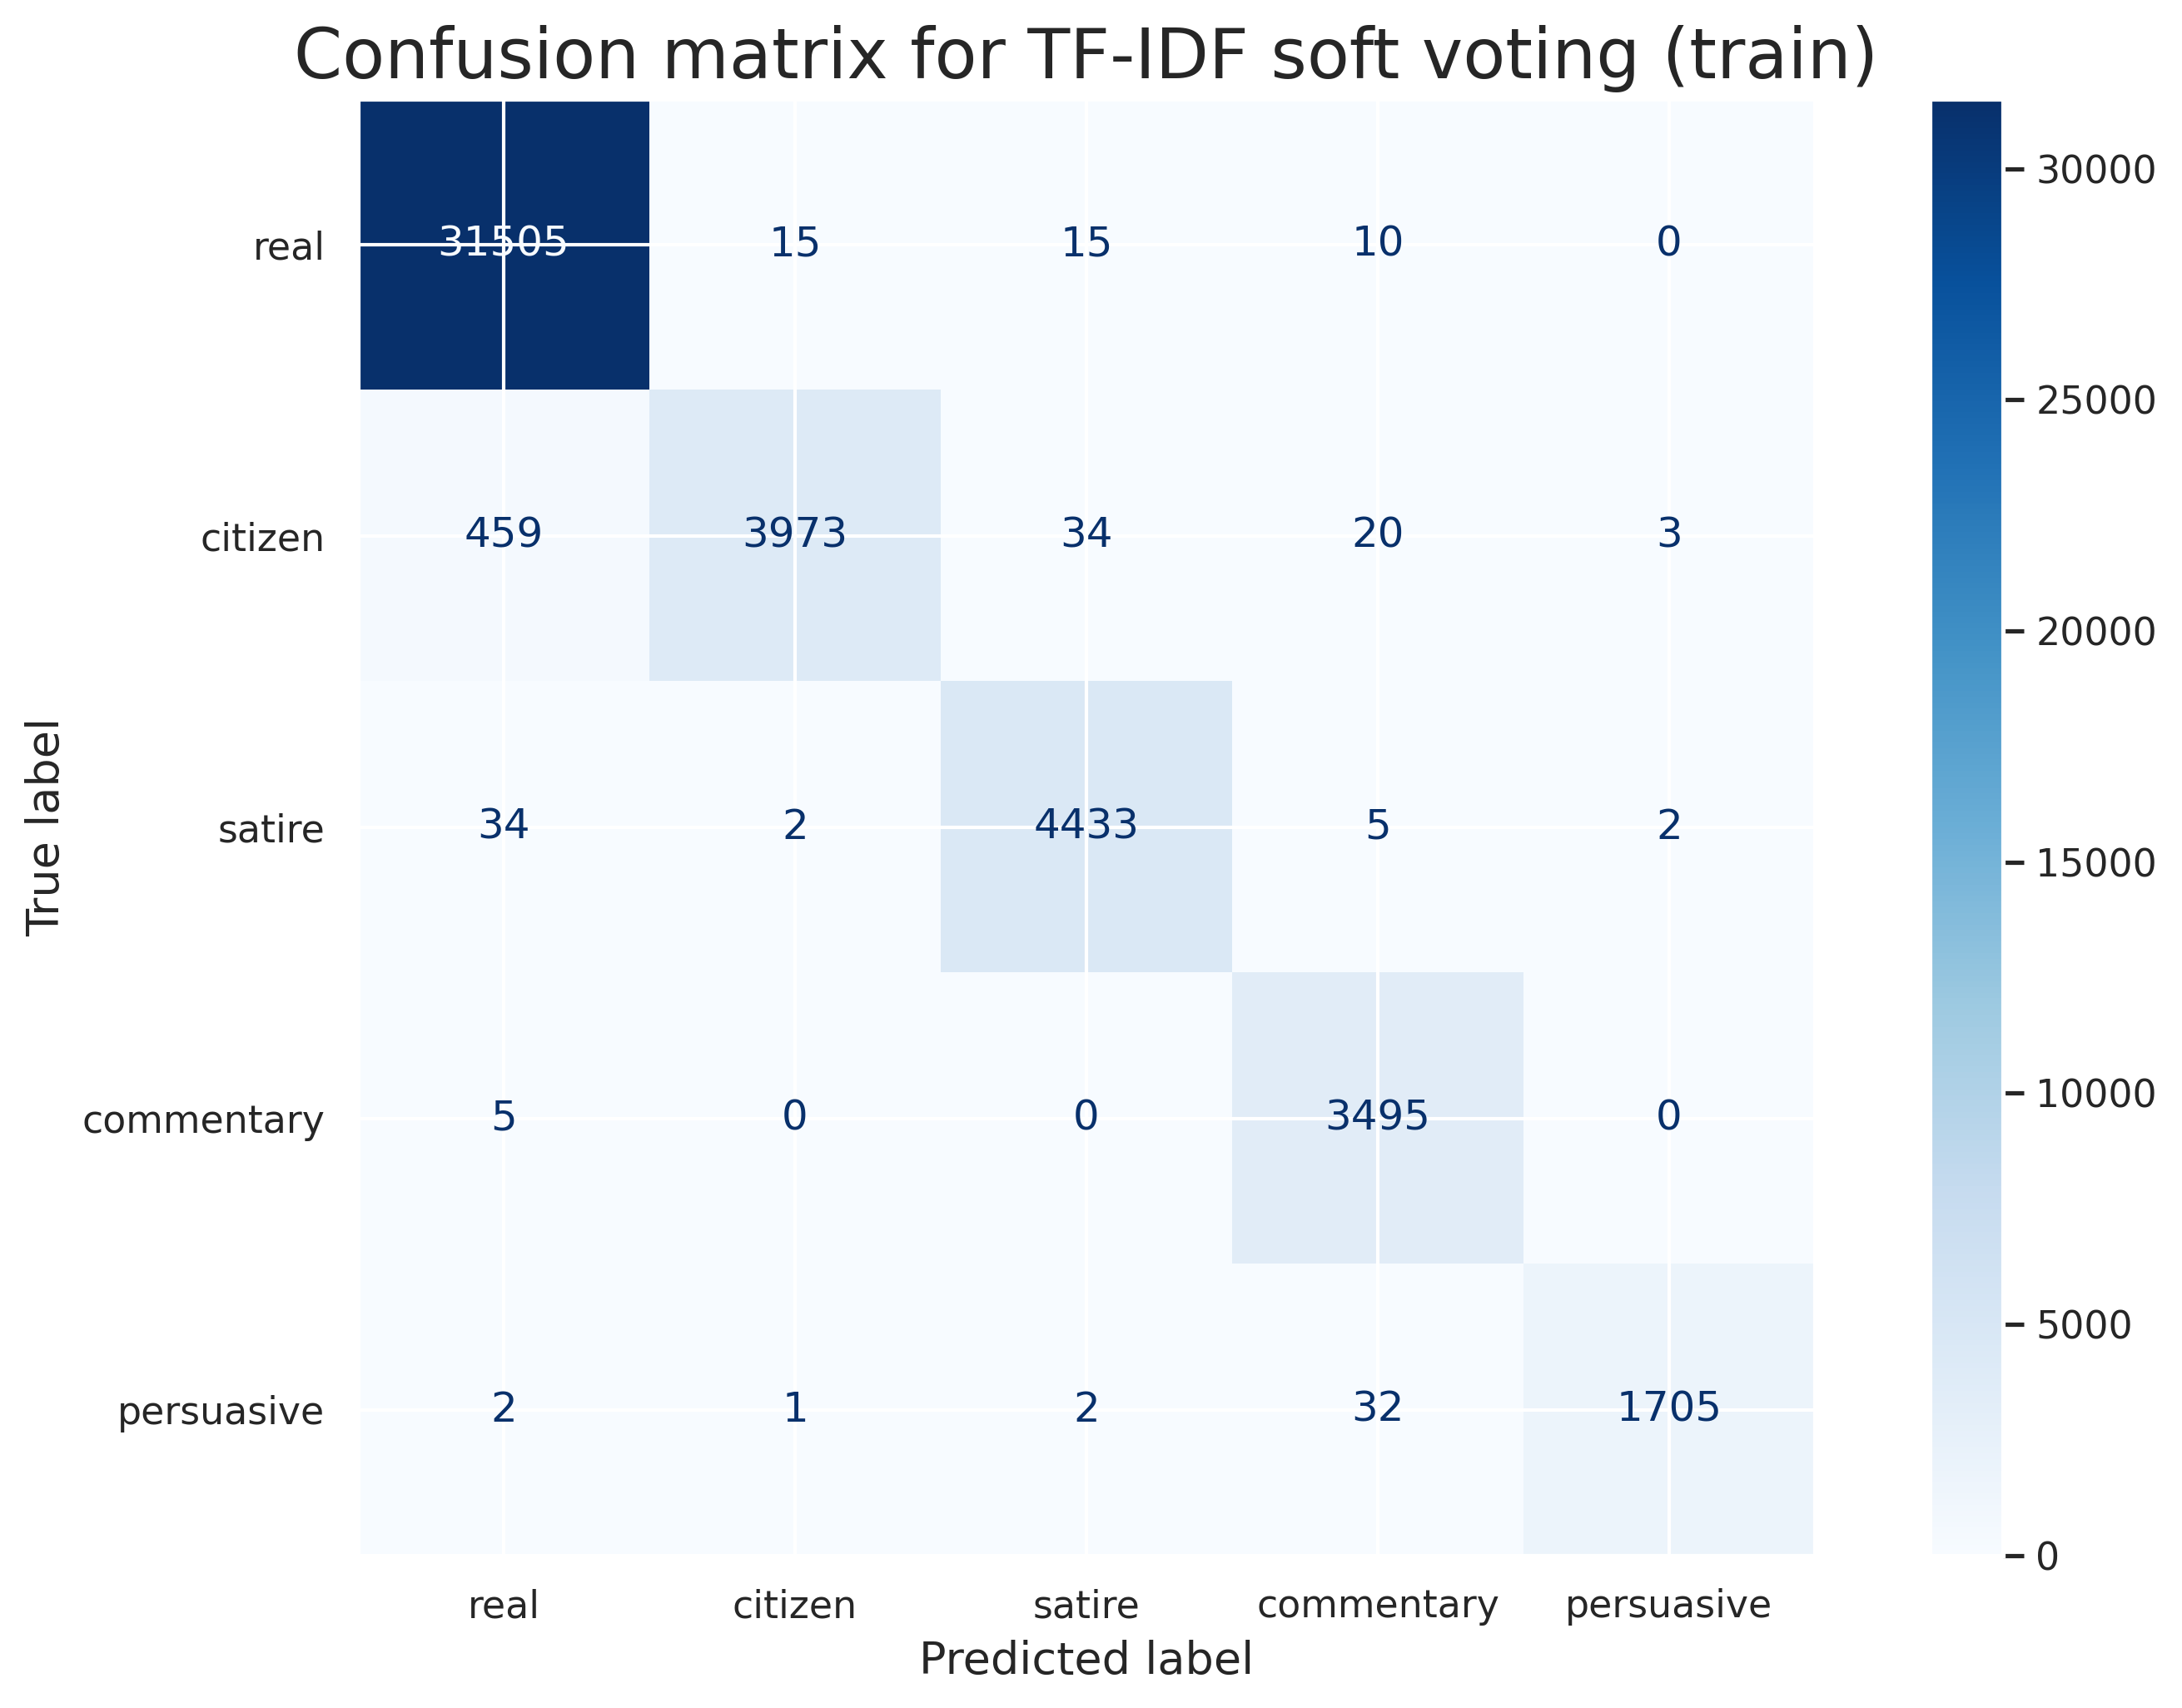

In [52]:
fig, ax = plt.subplots(figsize=(10, 7), dpi=300)
plot_confusion_matrix(tfidf_soft_voting_model, X_train, y_train,
                      display_labels=labels,
                      values_format='d',
                      cmap=plt.cm.Blues,
                      normalize=None,
                      ax=ax)
ax.set_title('Confusion matrix for TF-IDF soft voting (train)')
fig.tight_layout()
fig.savefig('Images/confusion_train.png')
plt.show()

In [53]:
fig, ax = plt.subplots(figsize=(10, 7), dpi=300)
plot_confusion_matrix(tfidf_soft_voting_model, X_valid, y_valid,
                      display_labels=labels,
                      values_format='d',
                      cmap=plt.cm.Greens,
                      normalize=None,
                      ax=ax)
ax.set_title('Confusion matrix for TF-IDF soft voting (validation)')
fig.tight_layout()
fig.savefig('Images/confusion_valid.png')
plt.show()

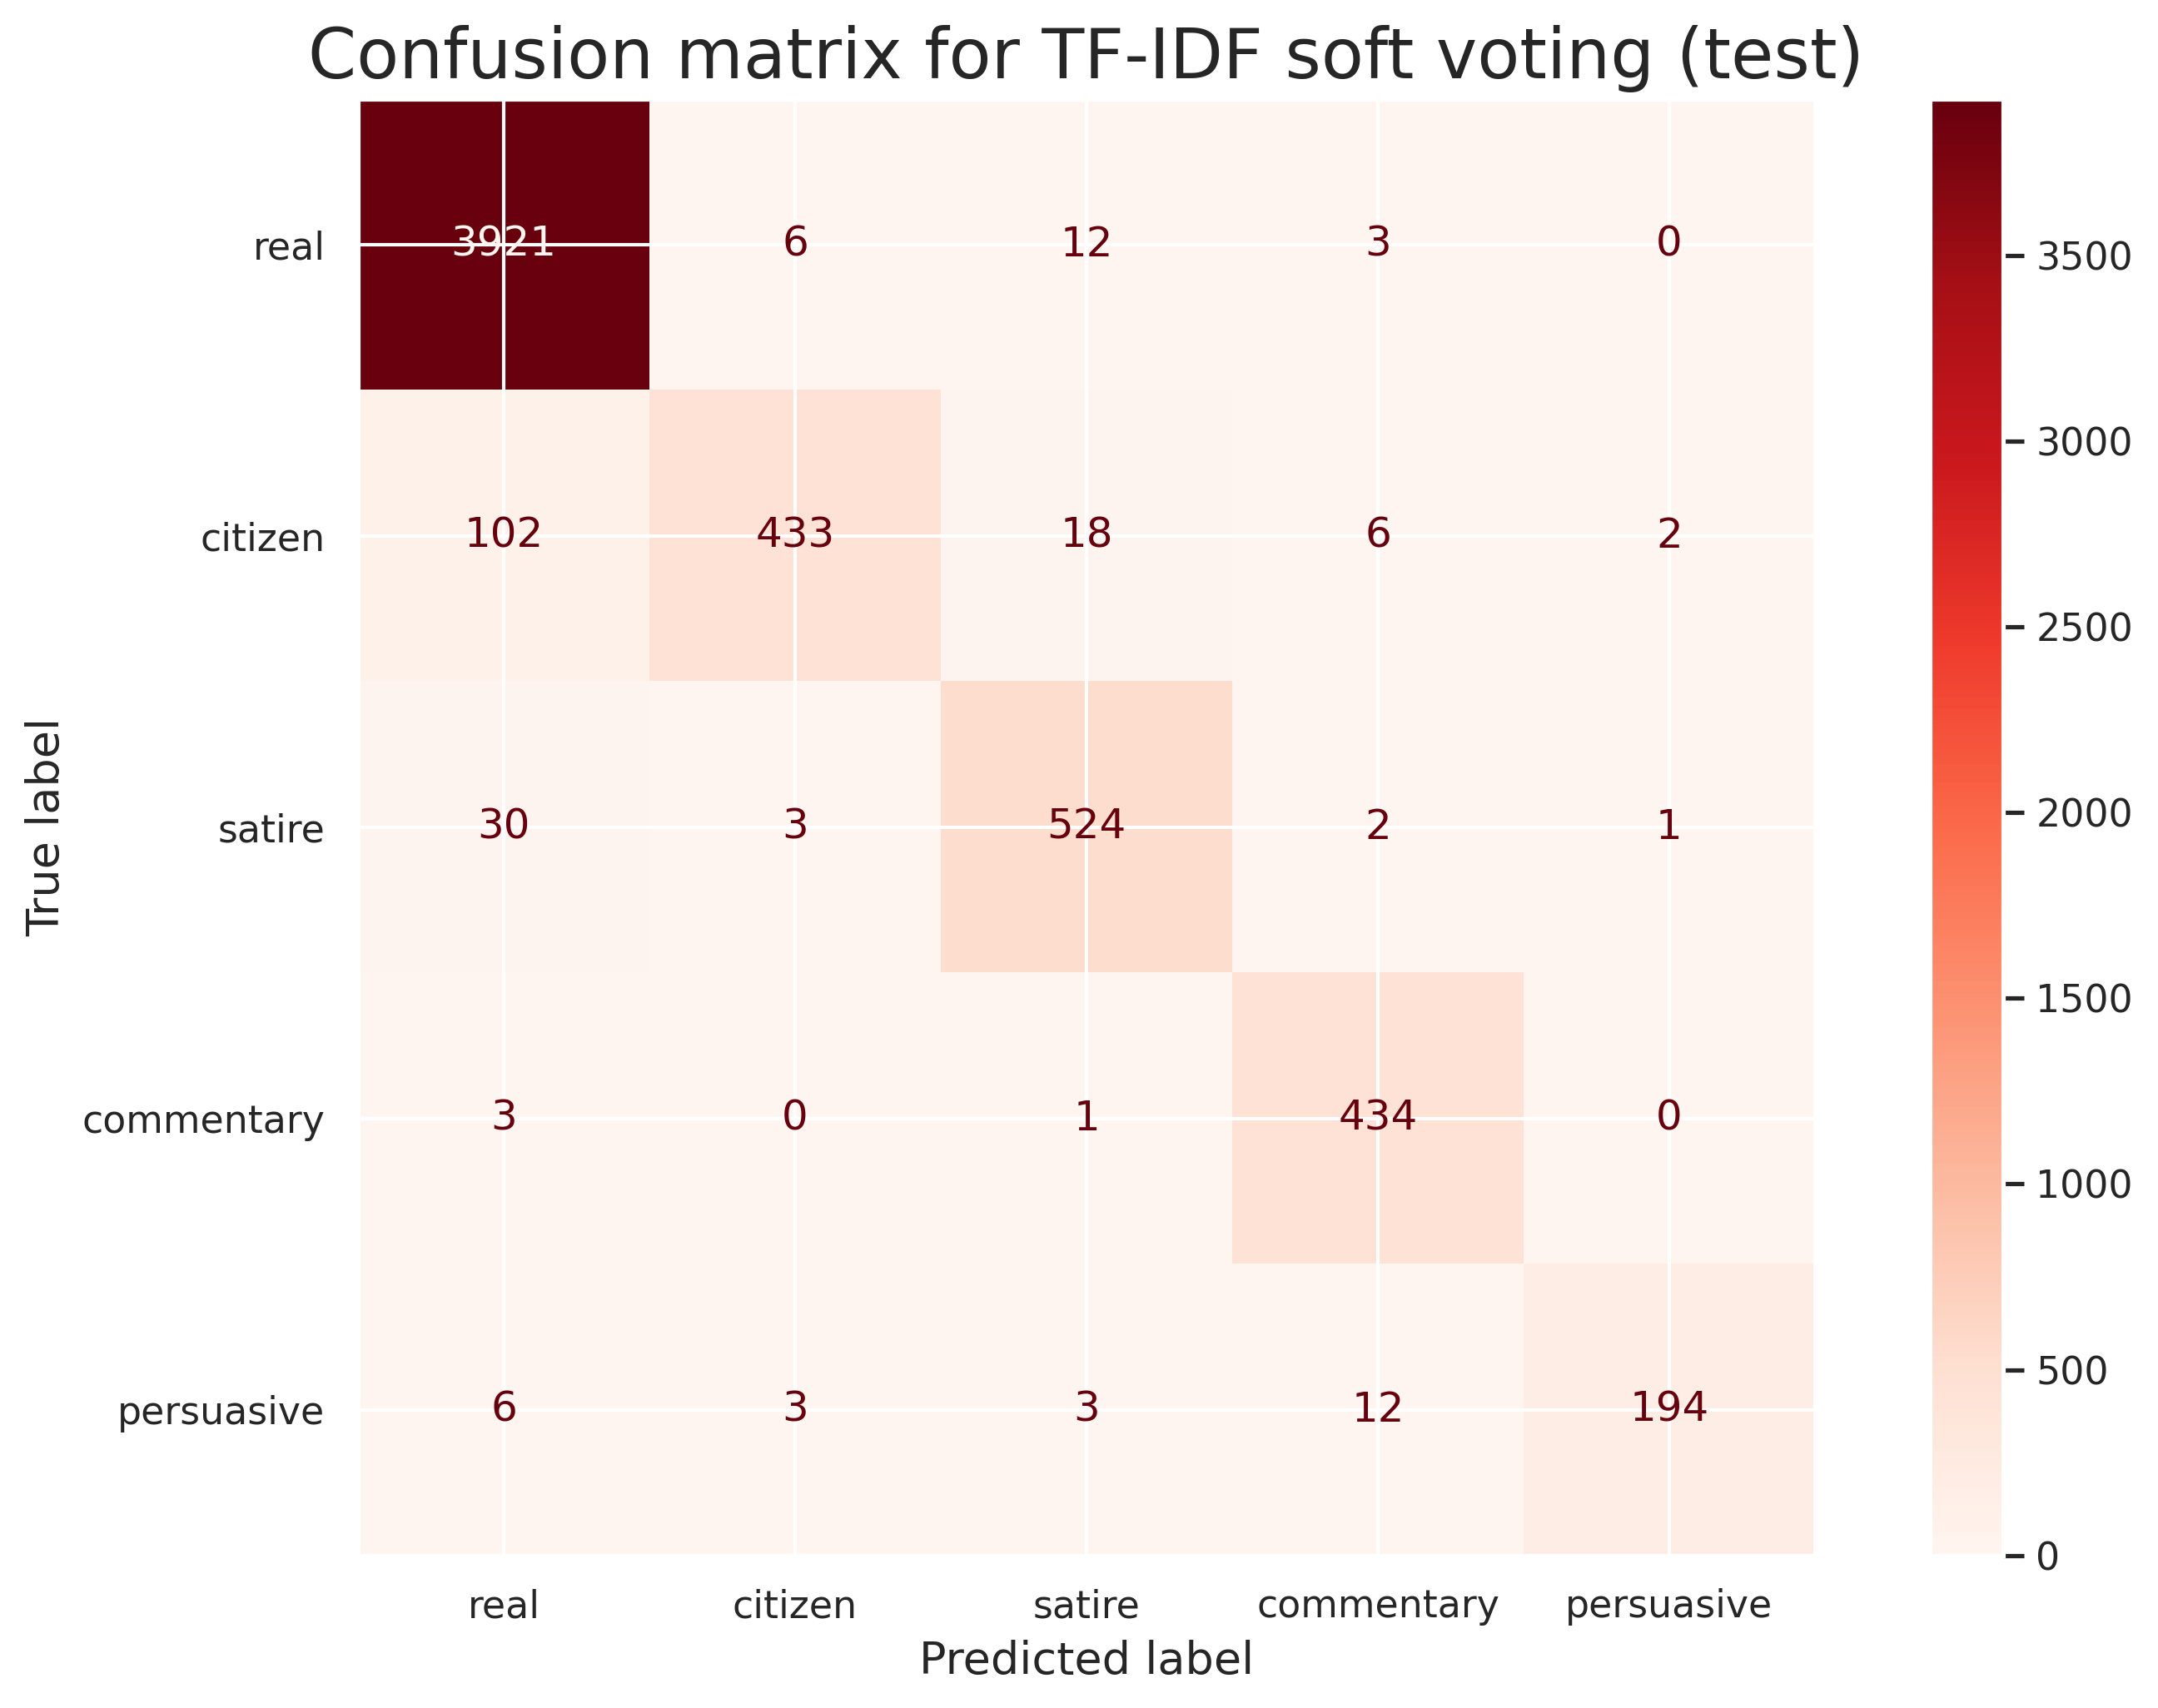

In [54]:
fig, ax = plt.subplots(figsize=(10, 7), dpi=300)
plot_confusion_matrix(tfidf_soft_voting_model, X_test, y_test,
                      display_labels=labels,
                      values_format='d',
                      cmap=plt.cm.Reds,
                      normalize=None,
                      ax=ax)
ax.set_title('Confusion matrix for TF-IDF soft voting (test)')
fig.tight_layout()
fig.savefig('Images/confusion_test.png')
plt.show()

In [ ]:
tfidf_boost_model.feature_importances_.sum()

1.0000001

In [ ]:
tfidf_boost_model.feature_importances_.min()

0.0

In [ ]:
tfidf_boost_model.feature_importances_.max()

0.06834592

In [ ]:
def top_features(model, n=10):
    keys = model.feature_importances_
    idxs = np.arange(X_train.shape[1])
    idxs = sorted(idxs, key=lambda x: keys[x], reverse=True)
    features = [x[0] for x in sorted(tfidf_vect.vocabulary_.items(), key=lambda x: x[1])]
    for idx in idxs[:n]:
        col = features[idx]
        key = keys[idx] * 100
        print(f"{col}: {key:.3f}")

In [ ]:
top_features(tfidf_boost_model, n=10)

. и: 6.835
?: 5.665
матч: 5.550
сообщить: 1.880
скидка: 1.842
. напомнить: 1.795
аней: 1.549
турнир: 1.391
чемпионат: 1.302
тренер: 1.184


In [ ]:
def plot_imps(model, ax, n=10, importance_type='gain', **kwargs):
    imps = model.get_booster().get_score(importance_type=importance_type)
    features = [x[0] for x in sorted(tfidf_vect.vocabulary_.items(), key=lambda x: x[1])]
    labels = []
    for key, val in sorted(imps.items(), key=lambda x: -x[1])[:n]:
        word = features[int(key[1:])]
        labels.append(word)
    plot_importance(model,
                    ax=ax,
                    importance_type=importance_type,
                    max_num_features=n,
                    xlabel='Gain score',
                    **kwargs)
    ax.set_yticklabels(labels[::-1])
    plt.show()

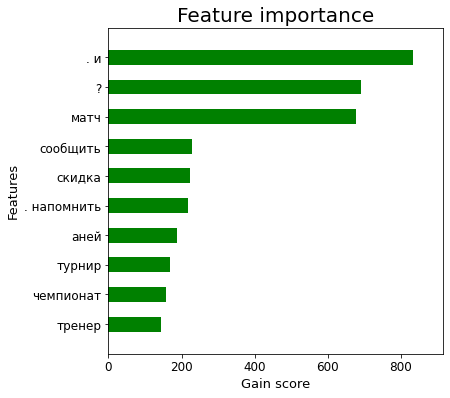

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_imps(tfidf_boost_model,
          ax,
          grid=False,
          height=0.5,
          show_values=False,
          color='green')

# ***Further experiments***

> ## **Estimation: TF-IDF scorer**

In [ ]:
def tfidf_tokenize(text):
    return list(map(lambda word: morph.parse(word)[0].normal_form, text.split()))

In [ ]:
tfidf_X = pickle.load(open('Features/tfidf_X.sav', 'rb'))
tfidf_y = pickle.load(open('Features/tfidf_y.sav', 'rb'))
tfidf_vect = pickle.load(open('Features/tfidf_vect.sav', 'rb'))

train_indices = pickle.load(open('Data for models/train_indices.sav', 'rb'))
mini_train_indices = pickle.load(open('Data for models/mini_train_indices.sav', 'rb'))
valid_indices = pickle.load(open('Data for models/valid_indices.sav', 'rb'))
test_indices = pickle.load(open('Data for models/test_indices.sav', 'rb'))

In [ ]:
tfidf_X[train_indices]

<45752x100000 sparse matrix of type '<class 'numpy.float64'>'
	with 13438629 stored elements in Compressed Sparse Row format>

In [ ]:
X_train = tfidf_X[train_indices]
X_mini_train = tfidf_X[mini_train_indices]
X_valid = tfidf_X[valid_indices]
X_test = tfidf_X[test_indices]

y_train = tfidf_y[train_indices]
y_mini_train = tfidf_y[mini_train_indices]
y_valid = tfidf_y[valid_indices]
y_test = tfidf_y[test_indices]

In [ ]:
X_mini_train.shape, y_mini_train.shape

((5719, 100000), (5719,))

In [ ]:
tfidf_boost_model = XGBClassifier(random_state=RANDOM_STATE,
                                  objective='multi:softprob',
                                  num_class=5)
booster = Booster()
booster.load_model('Best models/tfidf_boost_model.bin')
tfidf_boost_model._Booster = booster

tfidf_logreg_model = pickle.load(open('Best models/tfidf_logreg_model.pkl', 'rb'))

In [ ]:
D_enum_class = {
    'real_news': 0,
    'citizen_journalism': 1,
    'satire': 2,
    'commentary': 3,
    'persuasive_information': 4,
}

In [ ]:
def calc_soft_accuracy(y_true, y_pred, level):
    N = y_true.size
    acc = (y_pred == y_true).sum()
    soft_acc = ((y_pred != y_true) &
                (y_pred != D_enum_class['real_news']) &
                (y_true != D_enum_class['real_news'])).sum()
    return (acc + level * soft_acc) / N

def set_soft_acc_level(level):
    def wrapper(y_true, y_pred):
        return calc_soft_accuracy(y_true, y_pred, level)
    return wrapper

get_soft_accuracy = set_soft_acc_level(0.5)
soft_acc_scorer = make_scorer(get_soft_accuracy, greater_is_better=True)

In [ ]:
def get_score(y_true, y_pred):
    labels = list(set(y_true))
    N = y_true.size

    tp = np.array([sum((y_pred == label) & (y_true == label))
                   for label in labels])
    tn = np.array([sum((y_pred != label) & (y_true != label))
                   for label in labels])
    fp = np.array([sum((y_pred == label) & (y_true != label))
                   for label in labels])
    fn = np.array([sum((y_pred != label) & (y_true == label))
                   for label in labels])

    accuracy = tp.sum() / N
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f1 = (2 * prec * rec) / (prec + rec)

    f1_macro = f1.mean()

    soft_accuracy = get_soft_accuracy(y_true, y_pred)
    
    binary_mcc = tp.sum() * tn.sum() - fp.sum() * fn.sum()
    if binary_mcc:
        binary_mcc /= np.sqrt(tp.sum() + fp.sum()) * np.sqrt(tp.sum() + fn.sum())
        binary_mcc /= np.sqrt(tn.sum() + fp.sum()) * np.sqrt(tn.sum() + fn.sum())
    
    mcc_t = (tp + fn)
    mcc_p = (tp + fp)
    mcc = tp.sum() * N - mcc_t @ mcc_p
    if mcc:
        mcc /= np.sqrt((N * N - mcc_p @ mcc_p) * (N * N - mcc_t @ mcc_t))
    
    return {
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'accuracy': accuracy * 100,
        'soft_accuracy': soft_accuracy * 100,
        'f1_macro': f1_macro * 100,
        'mcc': mcc * 100,
        'binary_mcc': binary_mcc * 100,
    }

In [ ]:
def estimate(model, dataset='train', to_dense=False):
    if dataset == 'mini_train':
        print('Evaluation on mini_train')
        y_pred = model.predict(X_mini_train.toarray() if to_dense else X_mini_train)
        results = get_score(y_mini_train, y_pred)
    elif dataset == 'train':
        print('Evaluation on train')
        y_pred = model.predict(X_train.toarray() if to_dense else X_train)
        results = get_score(y_train, y_pred)
    elif dataset == 'valid':
        print('Evaluation on valid')
        y_pred = model.predict(X_valid.toarray() if to_dense else X_valid)
        results = get_score(y_valid, y_pred)
    elif dataset == 'test':
        print('Evaluation on test')
        y_pred = model.predict(X_test.toarray() if to_dense else X_test)
        results = get_score(y_test, y_pred)
    else:
        raise ValueError(f'Unknown value of attribute "dataset": "{dataset}"')
    
    for key, val in results.items():
        if isinstance(val, float):
            print(f'{key} -> {val:.3f}')
        else:
            print(f'{key} -> {val}')

> ## **Ensemble: stacking (TF-IDF: no MLP)**

In [ ]:
classifiers = [
    tfidf_boost_model,
    tfidf_logreg_model,
]

meta_classifier = LogisticRegression(random_state=RANDOM_STATE,
                                     n_jobs=-1,
                                     max_iter=200,
                                     penalty='l2',
                                     C=1,
                                     multi_class='ovr',
                                     solver='newton-cg')

tfidf_stack_model = StackingClassifier(classifiers,
                                       meta_classifier,
                                       use_clones=False) \
                    .fit(X_train, y_train)

In [ ]:
estimate(tfidf_stack_model, 'mini_train')

Evaluation on mini_train
tp -> [3923  360  525  414   56]
tn -> [1633 5151 5029 5129 5493]
fp -> [143   7 131 152   8]
fn -> [ 20 201  34  24 162]
accuracy -> 92.289
soft_accuracy -> 94.719
f1_macro -> 76.831
mcc -> 84.393
binary_mcc -> 90.361


In [ ]:
estimate(tfidf_stack_model, 'train')

Evaluation on train
tp -> [31394  2897  4284  3346   447]
tn -> [13159 41227 40231 41053 43954]
fp -> [1048   36 1045 1199   56]
fn -> [ 151 1592  192  154 1295]
accuracy -> 92.604
soft_accuracy -> 94.991
f1_macro -> 77.316
mcc -> 85.075
binary_mcc -> 90.755


In [ ]:
estimate(tfidf_stack_model, 'valid')

Evaluation on valid
tp -> [3902  367  513  420   49]
tn -> [1619 5151 5020 5124 5494]
fp -> [158   7 140 156   7]
fn -> [ 40 194  46  19 169]
accuracy -> 91.817
soft_accuracy -> 94.177
f1_macro -> 75.841
mcc -> 83.437
binary_mcc -> 89.771


In [ ]:
estimate(tfidf_stack_model, 'test')

Evaluation on test
tp -> [3909  359  511  406   69]
tn -> [1585 5151 5038 5146 5491]
fp -> [192   7 121 135  10]
fn -> [ 33 202  49  32 149]
accuracy -> 91.869
soft_accuracy -> 93.967
f1_macro -> 77.960
mcc -> 83.417
binary_mcc -> 89.837


> ## **Ensemble: hard voting (TF-IDF: no MLP)**

In [ ]:
classifiers = [
    tfidf_boost_model,
    tfidf_logreg_model,
]

tfidf_soft_voting_model = EnsembleVoteClassifier(classifiers,
                                                 voting='hard',
                                                 refit=False) \
                          .fit(X_train, y_train)

In [ ]:
estimate(tfidf_soft_voting_model, 'mini_train')

Evaluation on mini_train
tp -> [3937  368  385  409  138]
tn -> [1385 5139 5138 5234 5498]
fp -> [391  19  22  47   3]
fn -> [  6 193 174  29  80]
accuracy -> 91.572
soft_accuracy -> 92.315
f1_macro -> 84.185
mcc -> 82.536
binary_mcc -> 89.465


In [ ]:
estimate(tfidf_soft_voting_model, 'train')

Evaluation on train
tp -> [31499  2977  2983  3321  1097]
tn -> [11028 41087 41092 41925 44001]
fp -> [3179  176  184  327    9]
fn -> [  46 1512 1493  179  645]
accuracy -> 91.530
soft_accuracy -> 92.241
f1_macro -> 84.212
mcc -> 82.449
binary_mcc -> 89.413


In [ ]:
estimate(tfidf_soft_voting_model, 'valid')

Evaluation on valid
tp -> [3927  381  331  415  135]
tn -> [1344 5134 5130 5237 5501]
fp -> [433  24  30  43   0]
fn -> [ 15 180 228  24  83]
accuracy -> 90.733
soft_accuracy -> 91.450
f1_macro -> 82.892
mcc -> 80.721
binary_mcc -> 88.416


In [ ]:
estimate(tfidf_soft_voting_model, 'test')

Evaluation on test
tp -> [3934  369  350  400  118]
tn -> [1331 5127 5128 5241 5501]
fp -> [446  31  31  40   0]
fn -> [  8 192 210  38 100]
accuracy -> 90.418
soft_accuracy -> 91.240
f1_macro -> 81.417
mcc -> 80.007
binary_mcc -> 88.022


> ## **Ensemble: soft voting (TF-IDF: no MLP)**

In [ ]:
classifiers = [
    tfidf_boost_model,
    tfidf_logreg_model,
]

tfidf_soft_voting_model = EnsembleVoteClassifier(classifiers,
                                                 voting='soft',
                                                 refit=False) \
                          .fit(X_train, y_train)

In [ ]:
estimate(tfidf_soft_voting_model, 'mini_train')

Evaluation on mini_train
tp -> [3928  422  503  424  191]
tn -> [1591 5146 5133 5260 5495]
fp -> [185  12  27  21   6]
fn -> [ 15 139  56  14  27]
accuracy -> 95.611
soft_accuracy -> 96.057
f1_macro -> 92.561
mcc -> 91.066
binary_mcc -> 94.514


In [ ]:
estimate(tfidf_soft_voting_model, 'train')

Evaluation on train
tp -> [31440  3366  4016  3422  1508]
tn -> [12668 41168 41098 42086 43988]
fp -> [1539   95  178  166   22]
fn -> [ 105 1123  460   78  234]
accuracy -> 95.629
soft_accuracy -> 96.018
f1_macro -> 92.701
mcc -> 91.104
binary_mcc -> 94.536


In [ ]:
estimate(tfidf_soft_voting_model, 'valid')

Evaluation on valid
tp -> [3914  424  460  430  189]
tn -> [1553 5143 5131 5249 5498]
fp -> [224  15  29  31   3]
fn -> [ 28 137  99   9  29]
accuracy -> 94.719
soft_accuracy -> 95.156
f1_macro -> 91.444
mcc -> 89.209
binary_mcc -> 93.399


In [ ]:
estimate(tfidf_soft_voting_model, 'test')

Evaluation on test
tp -> [3923  402  468  420  181]
tn -> [1526 5143 5128 5255 5499]
fp -> [251  15  31  26   2]
fn -> [ 19 159  92  18  37]
accuracy -> 94.317
soft_accuracy -> 94.798
f1_macro -> 90.513
mcc -> 88.367
binary_mcc -> 92.896


> ## **Full-train model: Multi-layer Perceptron (reduced)**

In [ ]:
reduced_mlp_model = MLPClassifier(random_state=RANDOM_STATE,
                                  batch_size=128,
                                  hidden_layer_sizes=(64),
                                  learning_rate='adaptive',
                                  activation='tanh',
                                  solver='adam',
                                  learning_rate_init=0.01,
                                  alpha=1e-3,
                                  max_iter=3) \
                    .fit(X_train, y_train)

In [ ]:
estimate(reduced_mlp_model, dataset='mini_train')

Evaluation on mini_train
tp -> [3922  552  554  435  217]
tn -> [1767 5146 5152 5279 5493]
fp -> [ 9 12  8  2  8]
fn -> [21  9  5  3  1]
accuracy -> 99.318
soft_accuracy -> 99.397
f1_macro -> 98.798
mcc -> 98.636
binary_mcc -> 99.148


In [ ]:
estimate(reduced_mlp_model, dataset='train')

Evaluation on train
tp -> [31421  4427  4423  3447  1737]
tn -> [14119 41197 41227 42230 43938]
fp -> [88 66 49 22 72]
fn -> [124  62  53  53   5]
accuracy -> 99.351
soft_accuracy -> 99.444
f1_macro -> 98.771
mcc -> 98.699
binary_mcc -> 99.189


In [ ]:
estimate(reduced_mlp_model, dataset='valid')

Evaluation on valid
tp -> [3860  492  497  411  214]
tn -> [1687 5095 5107 5268 5474]
fp -> [90 63 53 12 27]
fn -> [82 69 62 28  4]
accuracy -> 95.716
soft_accuracy -> 96.354
f1_macro -> 92.846
mcc -> 91.396
binary_mcc -> 94.645


In [ ]:
estimate(reduced_mlp_model, dataset='test')

Evaluation on test
tp -> [3862  478  496  412  201]
tn -> [1656 5108 5103 5273 5466]
fp -> [121  50  56   8  35]
fn -> [80 83 64 26 17]
accuracy -> 95.279
soft_accuracy -> 95.882
f1_macro -> 91.809
mcc -> 90.461
binary_mcc -> 94.099


In [ ]:
pickle.dump(reduced_mlp_model, open('Best models/reduced_mlp_model.pkl', 'wb'))

In [ ]:
reduced_mlp_model = pickle.load(open('Best models/reduced_mlp_model.pkl', 'rb'))

> ## **Ensemble: stacking (TF-IDF: reduced MLP)**

In [ ]:
classifiers = [
    tfidf_boost_model,
    reduced_mlp_model,
    tfidf_logreg_model,
]

meta_classifier = LogisticRegression(random_state=RANDOM_STATE,
                                     n_jobs=-1,
                                     max_iter=200,
                                     penalty='l2',
                                     C=1,
                                     multi_class='ovr',
                                     solver='newton-cg')

tfidf_stack_model = StackingClassifier(classifiers,
                                       meta_classifier,
                                       use_clones=False) \
                    .fit(X_train, y_train)

In [ ]:
estimate(tfidf_stack_model, 'mini_train')

Evaluation on mini_train
tp -> [3927  364  522  412  207]
tn -> [1677 5108 5049 5262 5493]
fp -> [ 99  50 111  19   8]
fn -> [ 16 197  37  26  11]
accuracy -> 94.982
soft_accuracy -> 96.485
f1_macro -> 90.248
mcc -> 89.860
binary_mcc -> 93.727


In [ ]:
estimate(tfidf_stack_model, 'train')

Evaluation on train
tp -> [31439  2913  4247  3319  1636]
tn -> [13388 40996 40366 42120 43940]
fp -> [819 267 910 132  70]
fn -> [ 106 1576  229  181  106]
accuracy -> 95.196
soft_accuracy -> 96.587
f1_macro -> 90.617
mcc -> 90.310
binary_mcc -> 93.995


In [ ]:
estimate(tfidf_stack_model, 'valid')

Evaluation on valid
tp -> [3891  372  489  407  200]
tn -> [1635 5102 5045 5253 5481]
fp -> [142  56 115  27  20]
fn -> [ 51 189  70  32  18]
accuracy -> 93.705
soft_accuracy -> 95.165
f1_macro -> 88.293
mcc -> 87.220
binary_mcc -> 92.131


In [ ]:
estimate(tfidf_stack_model, 'test')

Evaluation on test
tp -> [3885  362  485  397  194]
tn -> [1589 5099 5058 5262 5472]
fp -> [188  59 101  19  29]
fn -> [ 57 199  75  41  24]
accuracy -> 93.076
soft_accuracy -> 94.396
f1_macro -> 87.254
mcc -> 85.856
binary_mcc -> 91.345


> ## **Ensemble: hard voting (TF-IDF: reduced MLP)**

In [ ]:
classifiers = [
    tfidf_boost_model,
    reduced_mlp_model,
    tfidf_logreg_model,
]

tfidf_soft_voting_model = EnsembleVoteClassifier(classifiers,
                                                 voting='hard',
                                                 refit=False) \
                          .fit(X_train, y_train)

In [ ]:
estimate(tfidf_soft_voting_model, 'mini_train')

Evaluation on mini_train
tp -> [3937  454  528  426  200]
tn -> [1635 5151 5147 5271 5498]
fp -> [141   7  13  10   3]
fn -> [  6 107  31  12  18]
accuracy -> 96.958
soft_accuracy -> 97.194
f1_macro -> 95.101
mcc -> 93.842
binary_mcc -> 96.197


In [ ]:
estimate(tfidf_soft_voting_model, 'train')

Evaluation on train
tp -> [31489  3636  4297  3445  1592]
tn -> [13112 41217 41210 42175 44001]
fp -> [1095   46   66   77    9]
fn -> [ 56 853 179  55 150]
accuracy -> 97.174
soft_accuracy -> 97.329
f1_macro -> 95.559
mcc -> 94.289
binary_mcc -> 96.467


In [ ]:
estimate(tfidf_soft_voting_model, 'valid')

Evaluation on valid
tp -> [3913  441  495  429  195]
tn -> [1592 5144 5134 5261 5499]
fp -> [185  14  26  19   2]
fn -> [ 29 120  64  10  23]
accuracy -> 95.699
soft_accuracy -> 95.978
f1_macro -> 93.304
mcc -> 91.242
binary_mcc -> 94.623


In [ ]:
estimate(tfidf_soft_voting_model, 'test')

Evaluation on test
tp -> [3927  419  501  425  178]
tn -> [1560 5146 5136 5266 5499]
fp -> [217  12  23  15   2]
fn -> [ 15 142  59  13  40]
accuracy -> 95.296
soft_accuracy -> 95.620
f1_macro -> 92.060
mcc -> 90.414
binary_mcc -> 94.120


> ## **Ensemble: soft voting (TF-IDF: reduced MLP)**

> ### Training & testing

In [ ]:
classifiers = [
    tfidf_boost_model,
    reduced_mlp_model,
    tfidf_logreg_model,
]

reduced_soft_voting_model = EnsembleVoteClassifier(classifiers,
                                                   voting='soft',
                                                   refit=False) \
                            .fit(X_train, y_train)

In [ ]:
estimate(reduced_soft_voting_model, 'mini_train')

Evaluation on mini_train
tp -> [3939  498  548  434  214]
tn -> [1704 5157 5156 5274 5499]
fp -> [72  1  4  7  2]
fn -> [ 4 63 11  4  4]
accuracy -> 98.496
soft_accuracy -> 98.584
f1_macro -> 97.805
mcc -> 96.974
binary_mcc -> 98.120


In [ ]:
estimate(reduced_soft_voting_model, 'train')

Evaluation on train
tp -> [31504  4039  4409  3478  1728]
tn -> [13708 41234 41254 42214 44004]
fp -> [499  29  22  38   6]
fn -> [ 41 450  67  22  14]
accuracy -> 98.702
soft_accuracy -> 98.761
f1_macro -> 98.225
mcc -> 97.388
binary_mcc -> 98.377


In [ ]:
estimate(reduced_soft_voting_model, 'valid')

Evaluation on valid
tp -> [3917  467  505  430  209]
tn -> [1647 5143 5136 5264 5495]
fp -> [130  15  24  16   6]
fn -> [25 94 54  9  9]
accuracy -> 96.660
soft_accuracy -> 96.975
f1_macro -> 94.830
mcc -> 93.227
binary_mcc -> 95.825


In [ ]:
estimate(reduced_soft_voting_model, 'test')

Evaluation on test
tp -> [3924  448  507  426  200]
tn -> [1622 5143 5131 5273 5493]
fp -> [155  15  28   8   8]
fn -> [ 18 113  53  12  18]
accuracy -> 96.258
soft_accuracy -> 96.617
f1_macro -> 93.910
mcc -> 92.398
binary_mcc -> 95.323


> ### Errors exploration

In [ ]:
pred = reduced_soft_voting_model.predict(X_train)

In [ ]:
labels = D_enum_class.keys()
for target in labels:
    for label in labels:
        if target != label:
            ids = list(df.loc[train_indices[(pred == D_enum_class[label]) & (y_train == D_enum_class[target])]]['url'])
            if ids:
                print(f'{target} -> {label}: {choice(ids)}')

real_news -> citizen_journalism: http://www.lenta.ru/news/2020/10/22/alliance/
real_news -> satire: http://www.interfax.ru/russia/736663
real_news -> commentary: http://www.interfax.ru/world/718986
real_news -> persuasive_information: http://www.interfax.ru/business/703921
citizen_journalism -> real_news: https://ru.wikinews.org/wiki/В_Азербайджане_закрылись_еще_2_банка
citizen_journalism -> satire: https://ru.wikinews.org/wiki/Украина_отозвала_посла_из_Беларуси
citizen_journalism -> commentary: https://ru.wikinews.org/wiki/Премьера_экшн-драмы_«Подольские_курсанты»_прошла_в_«Каро_11_Октябрь»
citizen_journalism -> persuasive_information: https://ru.wikinews.org/wiki/Бобровский:_в_США_люди_толерантны_и_терпимы_к_тебе
satire -> real_news: https://panorama.pub/27792-tsentr-peterburga-budet-snesen.html
satire -> citizen_journalism: https://panorama.pub/news/zelenskij-priznachiv-azarova-premr-mnstrom-ukrani
satire -> commentary: https://panorama.pub/13641-sosuli-i-sosulki.html
satire -> pers

> ## **Ensemble: stacking (TF-IDF: reduced MLP & no XGBoost)**

In [ ]:
classifiers = [
    reduced_mlp_model,
    tfidf_logreg_model,
]

meta_classifier = LogisticRegression(random_state=RANDOM_STATE,
                                     n_jobs=-1,
                                     max_iter=200,
                                     penalty='l2',
                                     C=1,
                                     multi_class='ovr',
                                     solver='newton-cg')

tfidf_stack_model = StackingClassifier(classifiers,
                                       meta_classifier,
                                       use_clones=False) \
                    .fit(X_train, y_train)

In [ ]:
estimate(tfidf_stack_model, 'mini_train')

Evaluation on mini_train
tp -> [3927  430  525  416  217]
tn -> [1673 5106 5122 5278 5493]
fp -> [103  52  38   3   8]
fn -> [ 16 131  34  22   1]
accuracy -> 96.433
soft_accuracy -> 97.176
f1_macro -> 93.919
mcc -> 92.766
binary_mcc -> 95.541


In [ ]:
estimate(tfidf_stack_model, 'train')

Evaluation on train
tp -> [31442  3446  4259  3342  1737]
tn -> [13368 40981 40983 42212 43938]
fp -> [839 282 293  40  72]
fn -> [ 103 1043  217  158    5]
accuracy -> 96.665
soft_accuracy -> 97.303
f1_macro -> 94.341
mcc -> 93.245
binary_mcc -> 95.831


In [ ]:
estimate(tfidf_stack_model, 'valid')

Evaluation on valid
tp -> [3891  423  491  407  214]
tn -> [1633 5098 5110 5268 5474]
fp -> [144  60  50  12  27]
fn -> [ 51 138  68  32   4]
accuracy -> 94.877
soft_accuracy -> 95.734
f1_macro -> 91.196
mcc -> 89.584
binary_mcc -> 93.596


In [ ]:
estimate(tfidf_stack_model, 'test')

Evaluation on test
tp -> [3886  397  487  404  201]
tn -> [1584 5098 5108 5276 5466]
fp -> [193  60  51   5  35]
fn -> [ 56 164  73  34  17]
accuracy -> 93.985
soft_accuracy -> 94.816
f1_macro -> 89.508
mcc -> 87.706
binary_mcc -> 92.481


> ## **Ensemble: hard voting (TF-IDF: reduced MLP & no XGBoost)**

In [ ]:
classifiers = [
    reduced_mlp_model,
    tfidf_logreg_model,
]

tfidf_soft_voting_model = EnsembleVoteClassifier(classifiers,
                                                 voting='hard',
                                                 refit=False) \
                          .fit(X_train, y_train)

In [ ]:
estimate(tfidf_soft_voting_model, 'mini_train')

Evaluation on mini_train
tp -> [3941  457  527  418  144]
tn -> [1621 5141 5140 5241 5501]
fp -> [155  17  20  40   0]
fn -> [  2 104  32  20  74]
accuracy -> 95.943
soft_accuracy -> 96.599
f1_macro -> 90.903
mcc -> 91.743
binary_mcc -> 94.929


In [ ]:
estimate(tfidf_soft_voting_model, 'train')

Evaluation on train
tp -> [31524  3667  4281  3371  1147]
tn -> [13071 41098 41109 41958 44010]
fp -> [1136  165  167  294    0]
fn -> [ 21 822 195 129 595]
accuracy -> 96.149
soft_accuracy -> 96.810
f1_macro -> 91.156
mcc -> 92.169
binary_mcc -> 95.186


In [ ]:
estimate(tfidf_soft_voting_model, 'valid')

Evaluation on valid
tp -> [3920  441  487  414  147]
tn -> [1587 5121 5119 5240 5499]
fp -> [190  37  41  40   2]
fn -> [ 22 120  72  25  71]
accuracy -> 94.579
soft_accuracy -> 95.436
f1_macro -> 88.938
mcc -> 88.898
binary_mcc -> 93.224


In [ ]:
estimate(tfidf_soft_voting_model, 'test')

Evaluation on test
tp -> [3930  412  492  410  121]
tn -> [1537 5122 5118 5244 5501]
fp -> [240  36  41  37   0]
fn -> [ 12 149  68  28  97]
accuracy -> 93.810
soft_accuracy -> 94.702
f1_macro -> 86.526
mcc -> 87.276
binary_mcc -> 92.263


> ## **Ensemble: soft voting (TF-IDF: reduced MLP & no XGBoost)**

In [ ]:
classifiers = [
    reduced_mlp_model,
    tfidf_logreg_model,
]

reduced_soft_voting_model = EnsembleVoteClassifier(classifiers,
                                                   voting='soft',
                                                   refit=False) \
                            .fit(X_train, y_train)

In [ ]:
estimate(reduced_soft_voting_model, 'mini_train')

Evaluation on mini_train
tp -> [3935  548  554  437  217]
tn -> [1761 5155 5156 5276 5500]
fp -> [15  3  4  5  1]
fn -> [ 8 13  5  1  1]
accuracy -> 99.510
soft_accuracy -> 99.554
f1_macro -> 99.265
mcc -> 99.016
binary_mcc -> 99.388


In [ ]:
estimate(reduced_soft_voting_model, 'train')

Evaluation on train
tp -> [31496  4386  4445  3472  1736]
tn -> [14092 41235 41247 42232 43985]
fp -> [115  28  29  20  25]
fn -> [ 49 103  31  28   6]
accuracy -> 99.526
soft_accuracy -> 99.584
f1_macro -> 99.205
mcc -> 99.047
binary_mcc -> 99.407


In [ ]:
estimate(reduced_soft_voting_model, 'valid')

Evaluation on valid
tp -> [3895  477  507  420  213]
tn -> [1673 5119 5127 5266 5484]
fp -> [104  39  33  14  17]
fn -> [47 84 52 19  5]
accuracy -> 96.380
soft_accuracy -> 96.870
f1_macro -> 94.051
mcc -> 92.675
binary_mcc -> 95.476


In [ ]:
estimate(reduced_soft_voting_model, 'test')

Evaluation on test
tp -> [3897  464  504  417  201]
tn -> [1642 5131 5115 5274 5478]
fp -> [135  27  44   7  23]
fn -> [45 97 56 21 17]
accuracy -> 95.873
soft_accuracy -> 96.363
f1_macro -> 92.926
mcc -> 91.618
binary_mcc -> 94.842
